In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from keras.optimizers import Adam, SGD, Adadelta

In [2]:
x_train_scaled = pd.read_csv('data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                            ...             
55_control    1.000000  0.363133  0.374212  0.611161  ...  0.529274   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...  0.485551   
72_control    0.648401  0.134017  0.200420  0.679453  ...  0.682864   
120_control   0.579519  0.248934  0.759250  0.755407  ...  0.760504   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...  0.601023   
...                ...       ...       ...       ...  ...       ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...  0.403338   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...  0.563382   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...  0.278042   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...  0.455270   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...  0.000000   

              LOC646430  LOC441956     ITGAV    SMCHD1      ASPN    TMEM97  \
Patient_ID                                                                   
55_control          0.0        0.0  0.364776  0.465986  0.922559  0.854193   
168_CD_plain        0.0        0.0  0.522378  0.578564  0.522145  0.692076   
72_control          0.0        0.0  0.042221  0.025102  0.789751  0.878183   
120_control         0.0        0.0  0.517359  0.672548  0.565864  0.505961   
258_CD_plain        0.0        0.0  0.490289  0.858259  0.686037  0.392018   
...                 ...        ...       ...       ...       ...       ...   
15_CD_plain         0.0        0.0  0.568061  0.445374  0.442044  0.695490   
182_CD_plain        0.0        0.0  0.457702  0.485198  0.507829  0.801229   
164_CD_plain        0.0        0.0  0.474069  0.769644  0.659954  0.314433   
53_CD_plain         0.0        0.0  0.506542  0.676451  0.677115  0.459944   
97_CD_plain         0.0        0.0  0.354709  0.345159  0.251259  0.607139   

              LOC389458     PTPN7  RPS12P31  
Patient_ID                                   
55_control     0.224260  0.883418       0.0  
168_CD_plain   0.021080  0.517763       0.0  
72_control     0.048352  0.429987       0.0  
120_control    0.021080  0.490510       0.0  
258_CD_plain   0.021080  0.633386       0.0  
...                 ...       ...       ...  
15_CD_plain    0.021080  0.324311       0.0  
182_CD_plain   0.021080  0.574480       0.0  
164_CD_plain   0.167705  0.847694       0.0  
53_CD_plain    0.021080  0.659798       0.0  
97_CD_plain    0.132905  0.733472       0.0  

[182 rows x 220 columns]

In [3]:
x_test_scaled = pd.read_csv('260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                 ...             
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...  0.799811   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...  0.843182   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...  0.442893   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...  0.511169   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...  0.498080   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.273104   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.540150   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.561707   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.260826   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.598137   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
253_CD_plain             0.0        0.0  0.315927  0.580699  0.652889   
105_CD_plain             0.0        0.0  0.233173  0.420656  0.461041   
2_CD_plain               0.0        0.0  1.044816  0.972319  0.998363   
184_CD_plain             0.0        0.0  0.457879  0.591956  0.665982   
312_CD_plain             0.0        0.0  0.583310  0.741909  0.691929   
...                      ...        ...       ...       ...       ...   
107_CD_plain             0.0        0.0  0.511460  0.571813  0.718136   
279_CD_plain             0.0        0.0  0.967121  0.690670  0.586834   
179_CD_plain             0.0        0.0  0.532892  0.827410  0.584298   
70_CD_deep_ulcer         0.0        0.0  0.353435  0.470313  0.693233   
256_CD_deep_ulcer        0.0        0.0  0.550635  0.712620  0.543815   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
253_CD_plain       0.283662   0.021080  0.271046       0.0  
105_CD_plain       0.783732   0.050226  0.510625       0.0  
2_CD_plain         0.013298   0.021080  0.674434       0.0  
184_CD_plain       0.460966   0.066515  0.616797       0.0  
312_CD_plain       0.483119   0.021080  0.646119       0.0  
...                     ...        ...       ...       ...  
107_CD_plain       0.624635   0.021080  0.939056       0.0  
279_CD_plain       0.731743   0.021080  0.312015       0.0  
179_CD_plain       0.217127   0.195470  0.876301       0.0  
70_CD_deep_ulcer   0.466546   0.045757  0.799992       0.0  
256_CD_deep_ulcer  0.510634   0.021080  0.597887       0.0  

[78 rows x 220 columns]

In [4]:
full_ds = pd.concat([x_train_scaled, x_test_scaled])
full_ds

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
55_control         0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain       0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control         0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control        0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain       0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                 ...             
55_control         1.000000  0.363133  0.374212  0.611161  ...  0.529274   
168_CD_plain       0.311962  0.251356  0.553554  0.441131  ...  0.485551   
72_control         0.648401  0.134017  0.200420  0.679453  ...  0.682864   
120_control        0.579519  0.248934  0.759250  0.755407  ...  0.760504   
258_CD_plain       0.370517  0.244987  0.445387  0.798000  ...  0.601023   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.273104   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.540150   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.561707   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.260826   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.598137   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
55_control               0.0        0.0  0.364776  0.465986  0.922559   
168_CD_plain             0.0        0.0  0.522378  0.578564  0.522145   
72_control               0.0        0.0  0.042221  0.025102  0.789751   
120_control              0.0        0.0  0.517359  0.672548  0.565864   
258_CD_plain             0.0        0.0  0.490289  0.858259  0.686037   
...                      ...        ...       ...       ...       ...   
107_CD_plain             0.0        0.0  0.511460  0.571813  0.718136   
279_CD_plain             0.0        0.0  0.967121  0.690670  0.586834   
179_CD_plain             0.0        0.0  0.532892  0.827410  0.584298   
70_CD_deep_ulcer         0.0        0.0  0.353435  0.470313  0.693233   
256_CD_deep_ulcer        0.0        0.0  0.550635  0.712620  0.543815   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
55_control         0.854193   0.224260  0.883418       0.0  
168_CD_plain       0.692076   0.021080  0.517763       0.0  
72_control         0.878183   0.048352  0.429987       0.0  
120_control        0.505961   0.021080  0.490510       0.0  
258_CD_plain       0.392018   0.021080  0.633386       0.0  
...                     ...        ...       ...       ...  
107_CD_plain       0.624635   0.021080  0.939056       0.0  
279_CD_plain       0.731743   0.021080  0.312015       0.0  
179_CD_plain       0.217127   0.195470  0.876301       0.0  
70_CD_deep_ulcer   0.466546   0.045757  0.799992       0.0  
256_CD_deep_ulcer  0.510634   0.021080  0.597887       0.0  

[260 rows x 220 columns]

In [5]:
train_set = x_train_scaled.copy()

In [6]:
test_set = x_test_scaled.copy()

### Dimensionality reduction with PCA

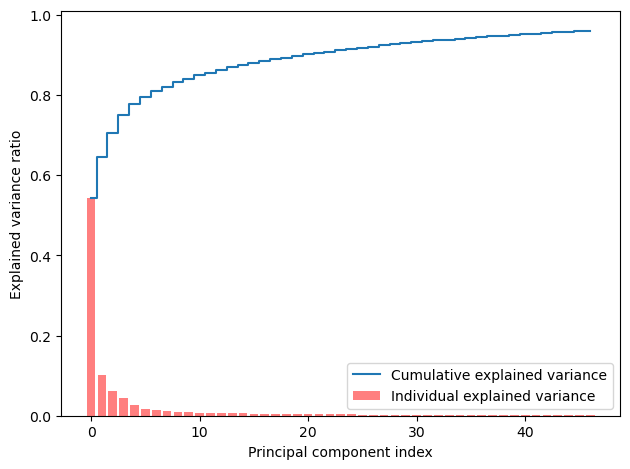

In [7]:
#https://vitalflux.com/pca-explained-variance-concept-python-example/#google_vignette

pca = PCA()
pca = PCA(n_components=.96)
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(train_set)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='r',label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [8]:
# https://www.datacamp.com/tutorial/principal-component-analysis-in-python

def encode_pca(dataset):
    pca_x_test = PCA(n_components=32)
    principalComponents_x_test = pca_x_test.fit_transform(dataset)
    if isinstance(dataset,np.ndarray):
        index = None
    else:
        index=dataset.index
    pca_x_test_ds = pd.DataFrame(data = principalComponents_x_test, 
                                       index=index)
    return pca_x_test_ds, pca_x_test

full_pca_dataset, pca_x = encode_pca(full_ds)
split_pt = int(0.7 * len(full_pca_dataset))
pca_test_dataset = full_pca_dataset[split_pt:]
pca_train_dataset = full_pca_dataset[:split_pt]

In [9]:
pca_train_dataset

0         1         2         3         4         5   \
Patient_ID                                                                 
55_control   -1.442102  0.423583 -0.771329  1.259458 -0.649900  0.528059   
168_CD_plain  0.391899 -0.779308  0.090023  0.396271 -0.589533 -0.446545   
72_control   -2.578385 -0.278593  0.888523  1.465165  0.252230  0.456526   
120_control   0.447236 -1.043545 -0.527135 -0.335315  0.451502 -0.135029   
258_CD_plain -0.987156  0.075976 -0.810296 -0.325627  0.190557 -0.418370   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.504535  2.430353  2.005170 -0.205547 -0.126590  0.029256   
182_CD_plain  0.882705 -1.050871  0.118741 -0.292277 -0.606780  0.369299   
164_CD_plain -1.951028  1.447491 -0.791561 -0.127819 -0.246209  0.184016   
53_CD_plain   0.109943 -0.310815 -0.473481 -0.383649 -0.608027  0.310525   
97_CD_plain  -0.782895 -1.255322 -0.736489  0.600703  0.453699 -0.042639   

                    6         7         8         9   ...        22        23  \
Patient_ID                                            ...                       
55_control   -0.470250  0.878353  0.827023 -0.342229  ...  0.107015 -0.368678   
168_CD_plain  0.371764  0.265636  0.022147 -0.104053  ...  0.008378 -0.197563   
72_control    0.056637 -0.331665 -0.217561 -0.181177  ...  0.218739 -0.121655   
120_control  -0.021976 -0.186347  0.129778 -0.154341  ... -0.114079  0.114948   
258_CD_plain -0.346951  0.060615  0.091755 -0.025873  ...  0.058848  0.071869   
...                ...       ...       ...       ...  ...       ...       ...   
15_CD_plain   0.332393  0.563023 -0.244974 -0.399149  ... -0.387458  0.211940   
182_CD_plain -0.137077 -0.079653  0.156238  0.133992  ...  0.273747 -0.026296   
164_CD_plain -0.424491 -0.180734 -0.023414 -0.336657  ... -0.191210  0.147831   
53_CD_plain  -0.132897 -0.088808  0.212416  0.213297  ... -0.033186 -0.002065   
97_CD_plain  -0.463990  0.155545 -1.118827  0.393104  ...  0.073154  0.051735   

                    24        25        26        27        28        29  \
Patient_ID                                                                 
55_control    0.159819  0.048672  0.034202  0.580354  0.339282  0.179175   
168_CD_plain -0.144208 -0.394304  0.021647 -0.560333  0.057313 -0.022891   
72_control   -0.007930 -0.314677  0.217659 -0.089813  0.123012 -0.183375   
120_control   0.052603 -0.259390 -0.002918  0.297557 -0.173319 -0.124066   
258_CD_plain -0.004576 -0.013813 -0.317813 -0.029274  0.018820  0.272456   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.131444  0.162377  0.001257 -0.342317  0.074094 -0.024259   
182_CD_plain  0.002835  0.006973 -0.138783  0.184802 -0.231047 -0.049446   
164_CD_plain -0.292369  0.277706  0.374931 -0.050942  0.049321 -0.259026   
53_CD_plain   0.168797 -0.164334  0.177686 -0.116223 -0.167166  0.019277   
97_CD_plain  -0.218473  0.096850  0.131762  0.123696 -0.051832 -0.122019   

                    30        31  
Patient_ID                        
55_control    0.152994  0.016017  
168_CD_plain -0.017347 -0.354982  
72_control   -0.352774  0.069533  
120_control  -0.018911  0.104921  
258_CD_plain -0.052392 -0.002692  
...                ...       ...  
15_CD_plain   0.075507 -0.082951  
182_CD_plain -0.003814  0.072130  
164_CD_plain  0.147622  0.004268  
53_CD_plain  -0.138938  0.100448  
97_CD_plain  -0.208962 -0.275942  

[182 rows x 32 columns]

In [10]:
# pca_train_dataset.to_csv("pca_train_dataset.csv")

In [11]:
print('Explained variation per principal component: {}'.format(pca_x.explained_variance_ratio_))
print("Total variance explained:",np.sum(pca_x.explained_variance_ratio_))

Explained variation per principal component: [0.54939203 0.09266768 0.06237725 0.04118218 0.03166017 0.01641165
 0.01425854 0.01077274 0.00977077 0.00921761 0.00836657 0.00654567
 0.0061617  0.00605624 0.00522338 0.0051358  0.00481203 0.00448673
 0.00417956 0.00392997 0.00363744 0.00351152 0.00344542 0.00327552
 0.00303987 0.00294433 0.00289943 0.00283878 0.00271683 0.00252468
 0.00244688 0.00234232]
Total variance explained: 0.9282312782213495


In [12]:
# pc1_var, pc2_var = np.round(pca_x_test.explained_variance_ratio_ * 100, 1)
# pc1_var

### Dimensionality reduction with autoencoder

In [13]:
def load_encoder():
    n_inputs = 220
    n_bottleneck = 32
    encoder = Sequential(
                [

#                     Input(shape=(n_inputs,)),
                    # encoder level 1
                    Dense(n_inputs*2),
                    BatchNormalization(),
                    LeakyReLU(),
                    # encoder level 2
                    Dense(n_inputs),
                    BatchNormalization(),
                    LeakyReLU(),
                    # bottleneck
                    Dense(n_bottleneck)
                ]
            )

    sh = test_set.head(1).shape
    encoder.load_weights("data/models/cd_encoder")
    encoder.build(sh) 
#     encoder.summary()
    return encoder

In [14]:
def ae_encode_dataset(dataset):
    encoder = load_encoder()
    latent_var = np.arange(32)
    print(type(dataset))
    if isinstance(dataset,np.ndarray):
        recon = encoder(dataset)
        index=None
    else:
        recon = encoder(dataset.values)
        index = dataset.index
    r = pd.DataFrame(recon, columns=latent_var, index=index)
    return r
    
full_ae_dataset = ae_encode_dataset(full_ds)

split_pt = int(0.7 * len(full_ae_dataset))
ae_test_dataset = full_ae_dataset[split_pt:]
ae_train_dataset = full_ae_dataset[:split_pt]

<class 'pandas.core.frame.DataFrame'>


In [15]:
ae_train_dataset

0         1         2         3         4         5   \
Patient_ID                                                                 
55_control    0.288272 -0.912222 -2.318454 -0.320546  1.268911  2.224520   
168_CD_plain  0.617792  0.560944 -2.132833 -0.541686  2.144836 -0.296827   
72_control    2.245337 -2.268267 -1.849064  3.110421 -0.694425  2.271128   
120_control   0.327902  2.334573 -2.790015  0.043855  1.738452 -0.424148   
258_CD_plain  0.919541  0.287959 -1.332597  1.184896  1.399894  0.259297   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain  -3.104249 -0.106958  4.295158 -2.531187 -4.684196 -4.884666   
182_CD_plain -0.005594  1.153794 -1.786321 -0.575366  2.336784  0.114578   
164_CD_plain  0.064562 -1.769992 -0.070868  1.733026 -0.652339 -0.290598   
53_CD_plain   0.649489  0.653974 -1.695457  0.762790  1.725251  0.128519   
97_CD_plain   2.466618  0.549934 -3.779703  1.611472  2.291438  1.995342   

                    6         7         8         9   ...        22        23  \
Patient_ID                                            ...                       
55_control   -0.328318 -3.315060  0.521105 -0.944953  ...  1.669983 -2.329685   
168_CD_plain  0.539860  0.168316 -1.985117 -0.993657  ... -0.738990  2.024782   
72_control    1.943480 -6.510586 -0.055970  2.216743  ...  3.514814 -3.817818   
120_control   0.400502  2.242007 -1.077926  0.316365  ... -1.411829  2.214214   
258_CD_plain  0.036335 -1.001636 -0.418281  0.037940  ...  0.284094 -1.326436   
...                ...       ...       ...       ...  ...       ...       ...   
15_CD_plain  -1.193016 -1.500154  1.356784 -1.586145  ...  1.378454 -2.228350   
182_CD_plain -0.605222  2.335521 -2.052289  0.038775  ... -1.729915  2.812875   
164_CD_plain -0.491476 -4.296665 -0.062128  1.059310  ...  1.562004 -3.730137   
53_CD_plain  -0.713699  1.363795 -1.514113 -0.033022  ... -0.852918  1.644637   
97_CD_plain   0.456571 -0.952700 -1.123916  0.069520  ...  0.461570  0.663762   

                    24        25        26        27        28        29  \
Patient_ID                                                                 
55_control   -1.266584  0.550923  1.825620 -0.377354 -0.718790  0.142199   
168_CD_plain  0.174337  1.667323  0.069790 -0.365362 -0.883698  0.040605   
72_control   -2.816581 -1.167202 -0.326387  4.436590  1.402645 -0.082535   
120_control   0.162392  0.514658  0.704023 -1.249208 -0.342787 -0.083903   
258_CD_plain -0.371230 -0.544548  0.369103  1.299755  0.712142 -1.254723   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.873032 -1.953398 -2.895312 -2.410545 -1.231102 -0.127444   
182_CD_plain  0.744357  1.669864  0.731818 -1.094109 -1.374574  0.388919   
164_CD_plain -0.913423 -2.066986 -0.202371  2.061640  0.734920 -1.722816   
53_CD_plain   0.223291  0.968334  0.516150 -0.200102 -1.135693 -0.273547   
97_CD_plain  -1.458017  0.752101  1.651342  1.639773 -0.223511 -0.644786   

                    30        31  
Patient_ID                        
55_control    1.174915 -2.928070  
168_CD_plain -2.605453  1.860293  
72_control    3.760460 -2.334291  
120_control  -1.710508 -0.074929  
258_CD_plain  1.106250 -0.770983  
...                ...       ...  
15_CD_plain   3.748322  0.840136  
182_CD_plain -2.334359  1.671605  
164_CD_plain  4.670454 -2.195275  
53_CD_plain  -1.640038  0.280390  
97_CD_plain   0.168581 -0.087310  

[182 rows x 32 columns]

## True labels

In [16]:
train_patient_ids = np.array(pca_train_dataset.index)


In [17]:
test_patient_ids = np.array(pca_test_dataset.index)


In [18]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

train_disease_labels = vec(train_patient_ids)
test_disease_labels = vec(test_patient_ids)

In [19]:
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

## KMeans clustering

### Fit KMeans (PCA & tSNE dimensionality reduction)

In [20]:
def compute_silh_scores(datapoints, cluster_labels):
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(datapoints, cluster_labels)


    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(datapoints, cluster_labels)
    
    return silhouette_avg, sample_silhouette_values

def plot_silhouette(n_clusters, cluster_labels, sample_silhouette_values, silhouette_avg, ax):
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [21]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html


def plot_kmeans(Y, disease_labels, k_labels, centers, radii, reduction, num_c=4, test_set=True, plot_sil=False, selected_patient_idx=None):

    num_rows = 2 if plot_sil else 1
    dim_h = 12 if plot_sil else 6
    dim_w = 15 if plot_sil else 15
    (fig, subplots) = plt.subplots(num_rows, 2, figsize=(dim_w, dim_h))
    


    label_sets = [k_labels, disease_labels]
    num_clusters = 3
    dset = "test" if test_set else "train"


    for i, label_set in enumerate(label_sets):
        
        ax = subplots[0][i] if plot_sil else subplots[i]

        dset = "test" if test_set else "train"

        if i==0:
            num_clusters = num_c
            cluster_names = ["Cluster " + str(i) for i in range(num_clusters)]
            colours = ["chocolate", "darkblue", "magenta", "yellow", "blue"]
            ax.set_title("KMeans clustering on " + dset + " set with cluster labels shown \n (" + reduction + " dimensionality reduction)",
                         wrap=True)
        else:
            num_clusters = 3
            cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
            colours = ["green", "orange", "red"]
            ax.set_title("KMeans clustering on " + dset + " set with true labels shown \n (" + reduction + " dimensionality reduction)",
                         wrap=True)
        for i in range(num_clusters):
            ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 



        for c, r in zip(centers, radii):
            ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

        if selected_patient_idx is not None:
            ax.scatter(Y[selected_patient_idx, 0], Y[selected_patient_idx, 1], c="cyan", s=400, marker='*',edgecolor='black', linewidth=.7, label="Selected patient")

        ax.legend()

        ax.axis("tight")
        
    if plot_sil:
        silhouette_avg, sample_silhouette_values = compute_silh_scores(Y, k_labels)
        plot_silhouette(num_c, k_labels, sample_silhouette_values, silhouette_avg, subplots[1][0])
        subplots[1][1].axis('off')
        
    
    plt.show()
    if plot_sil:
        print("The average silhouette_score is :",silhouette_avg)




### Training

In [22]:
def train_kmeans(full_dataset, perplexity):
    # compress to 2D with tSNE
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_dataset)
    X_test = X[split_pt:]
    X_train = X[:split_pt]
    # X_train = np.concatenate([X[:split_pt], X[-num_c:]])

    num_c=4
    kmeans = KMeans(num_c, random_state=0).fit(X_train)
    k_labels_train = kmeans.predict(X_train)
    k_labels_test = kmeans.predict(X_test)


    # representation of the KMeans model (both)
    # centers = X[-num_c:]
    centers = kmeans.cluster_centers_
    radii = [cdist(X_train[k_labels_train == i], [center]).max()
             for i, center in enumerate(centers)]
    
    return kmeans, X_train, X_test, k_labels_train, k_labels_test, centers, radii

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 10


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


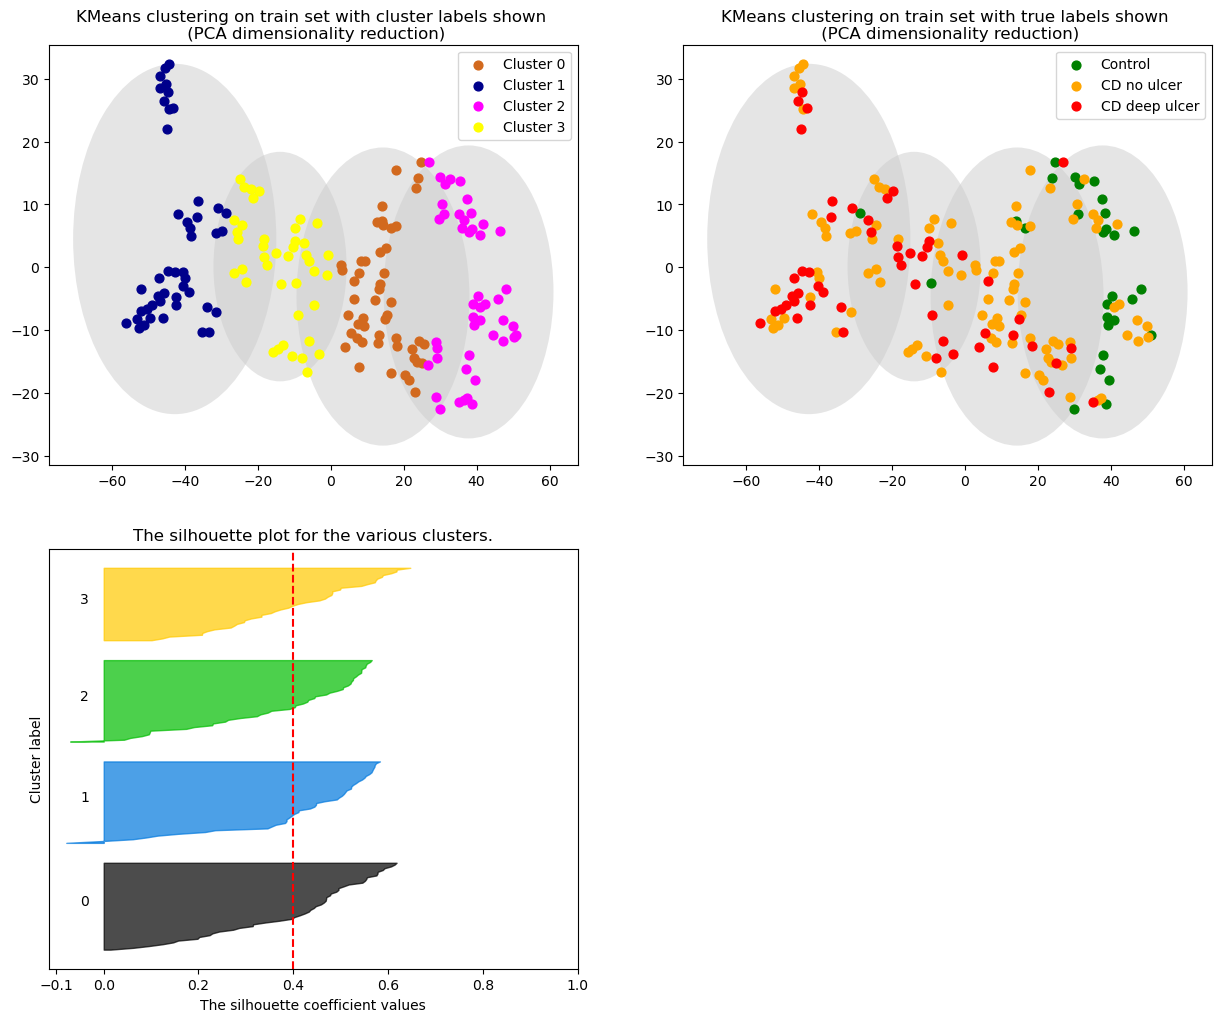

The average silhouette_score is : 0.40028125


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 20


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


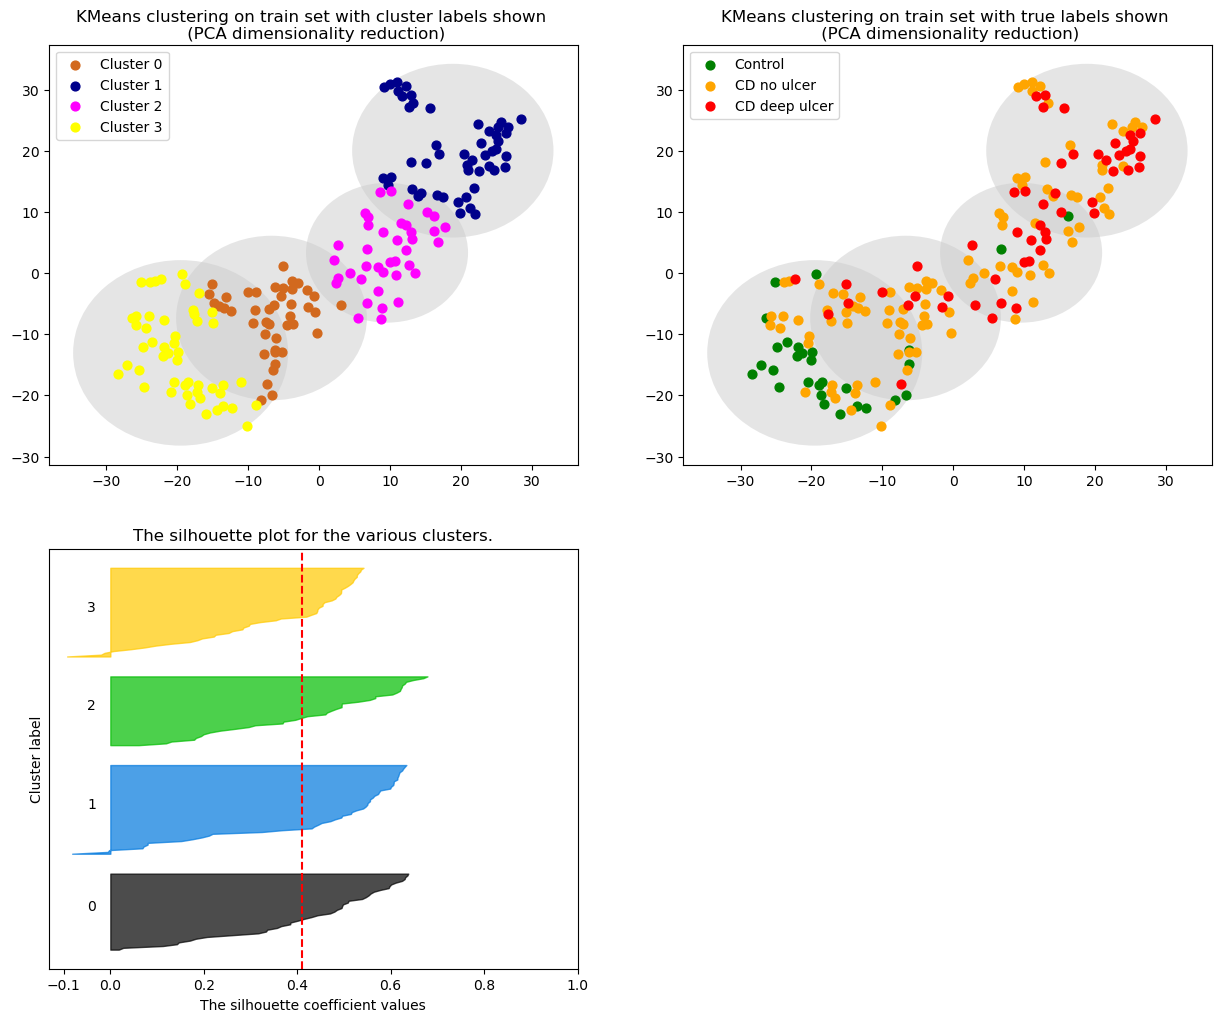

The average silhouette_score is : 0.4104439


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 50


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


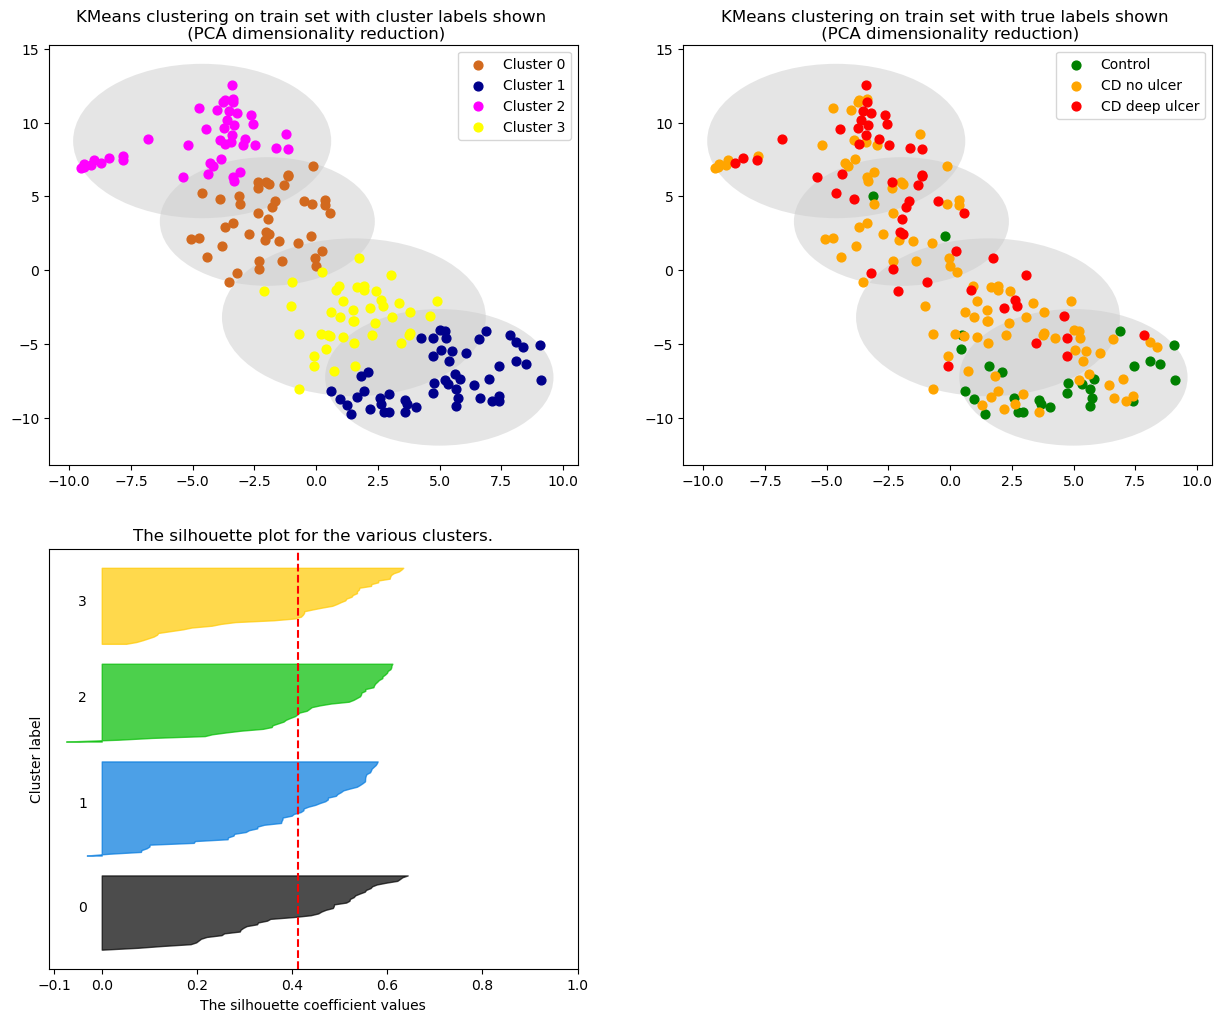

The average silhouette_score is : 0.4133814


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 70


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


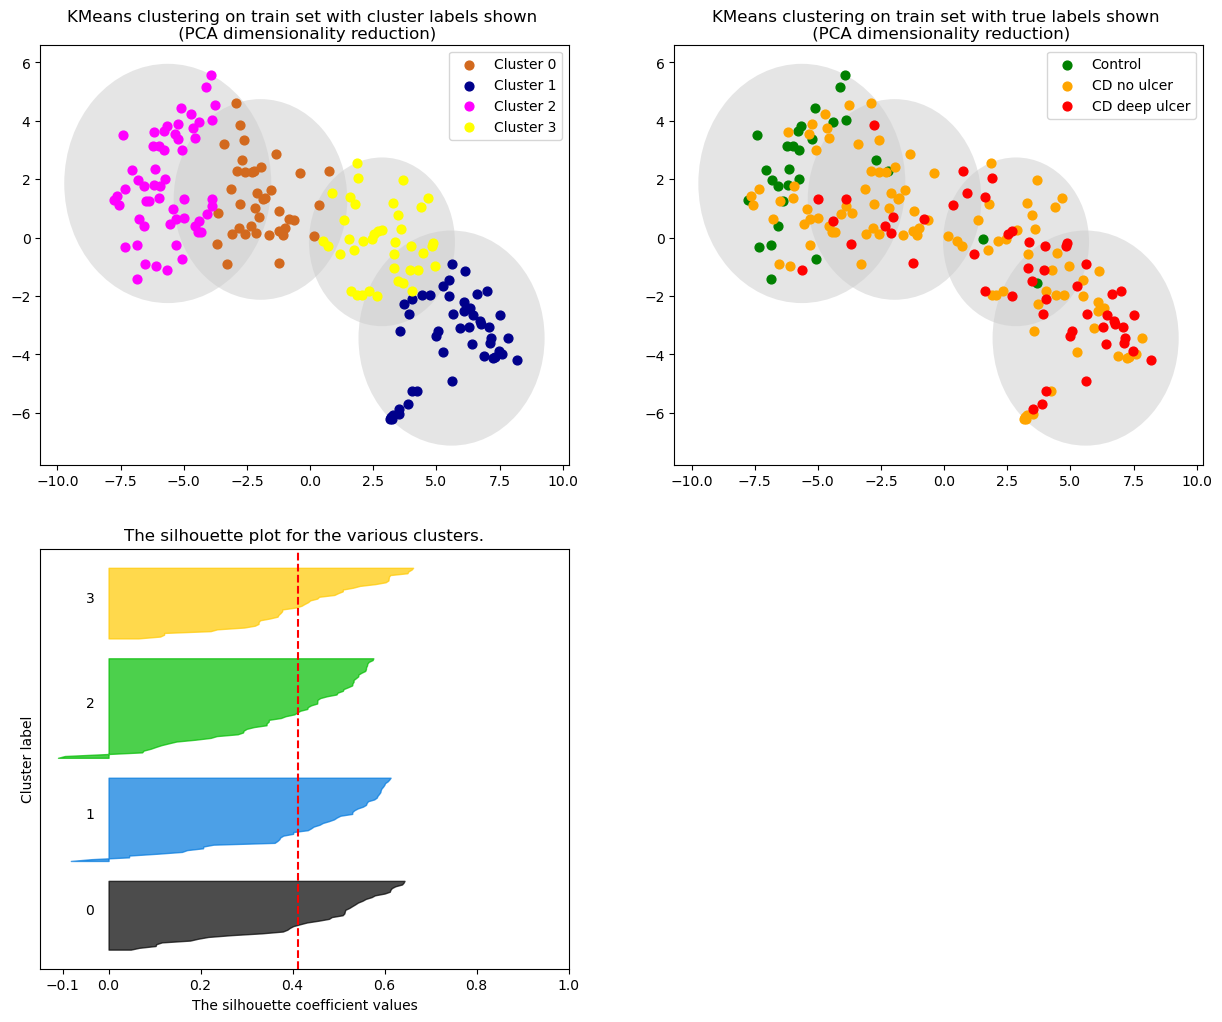

The average silhouette_score is : 0.41169268


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 100


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


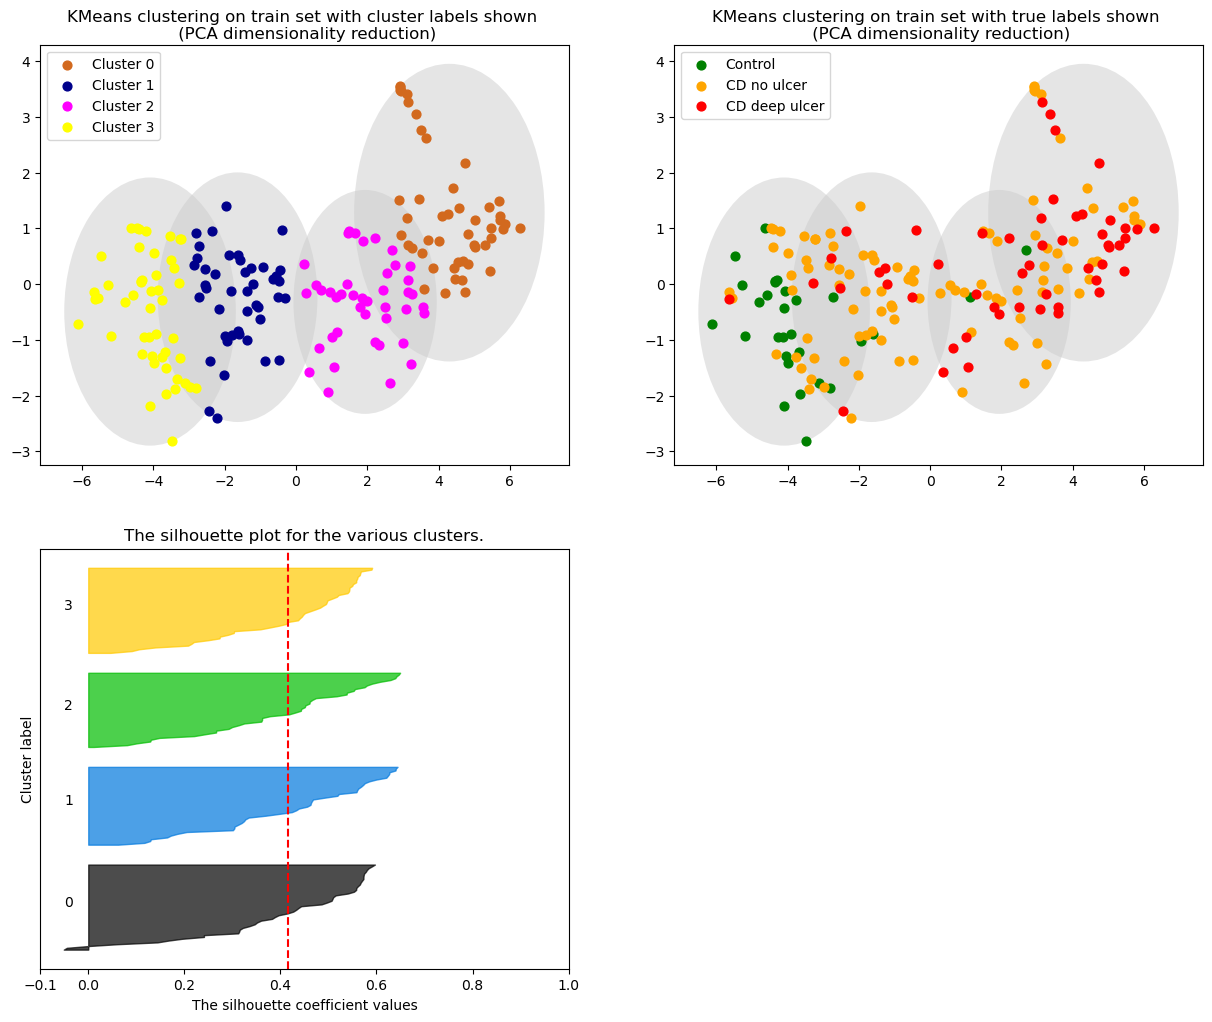

The average silhouette_score is : 0.4149765


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 150


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


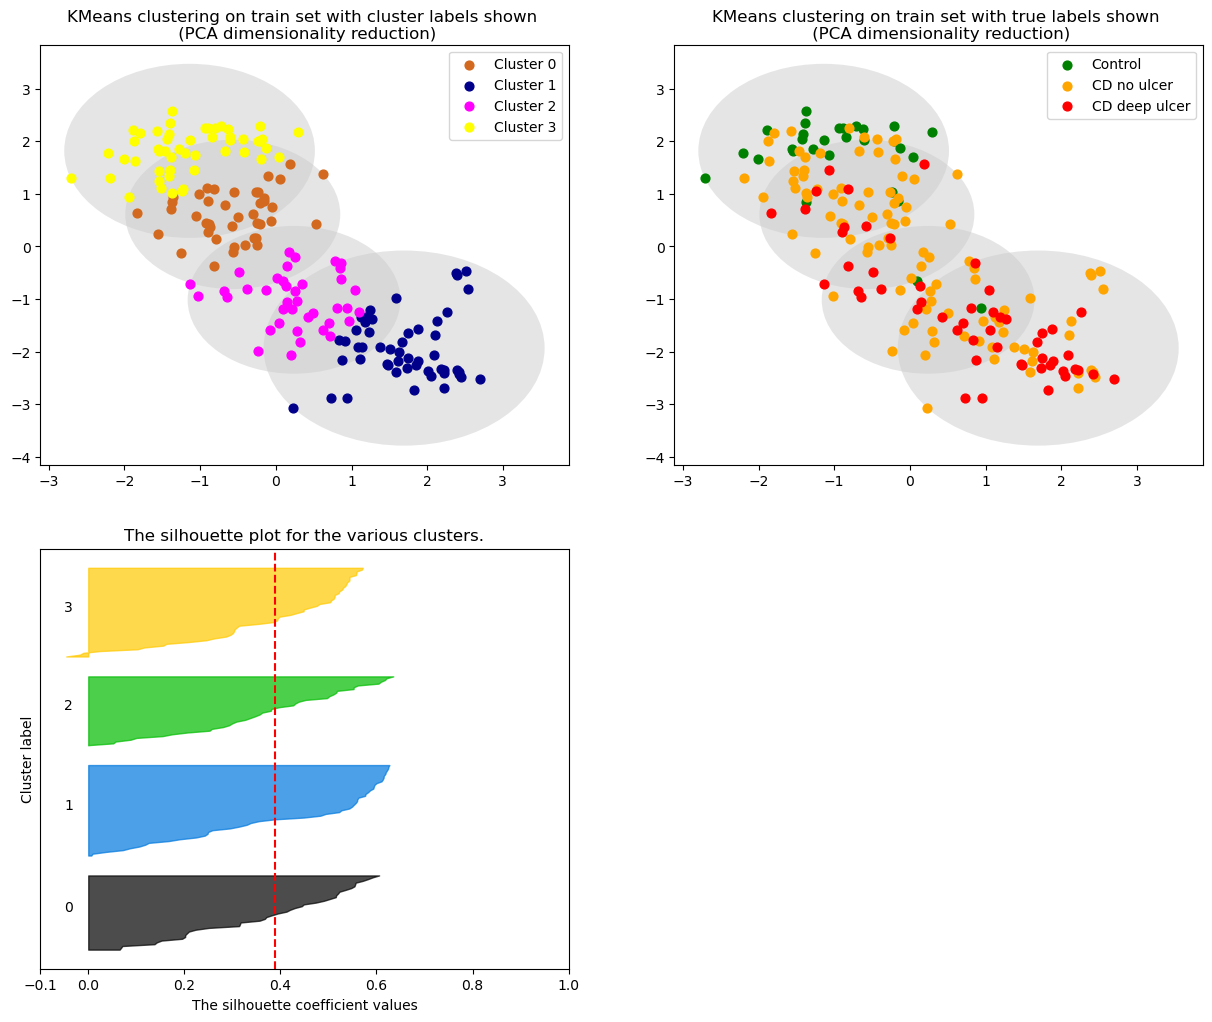

The average silhouette_score is : 0.38869497


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 200


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


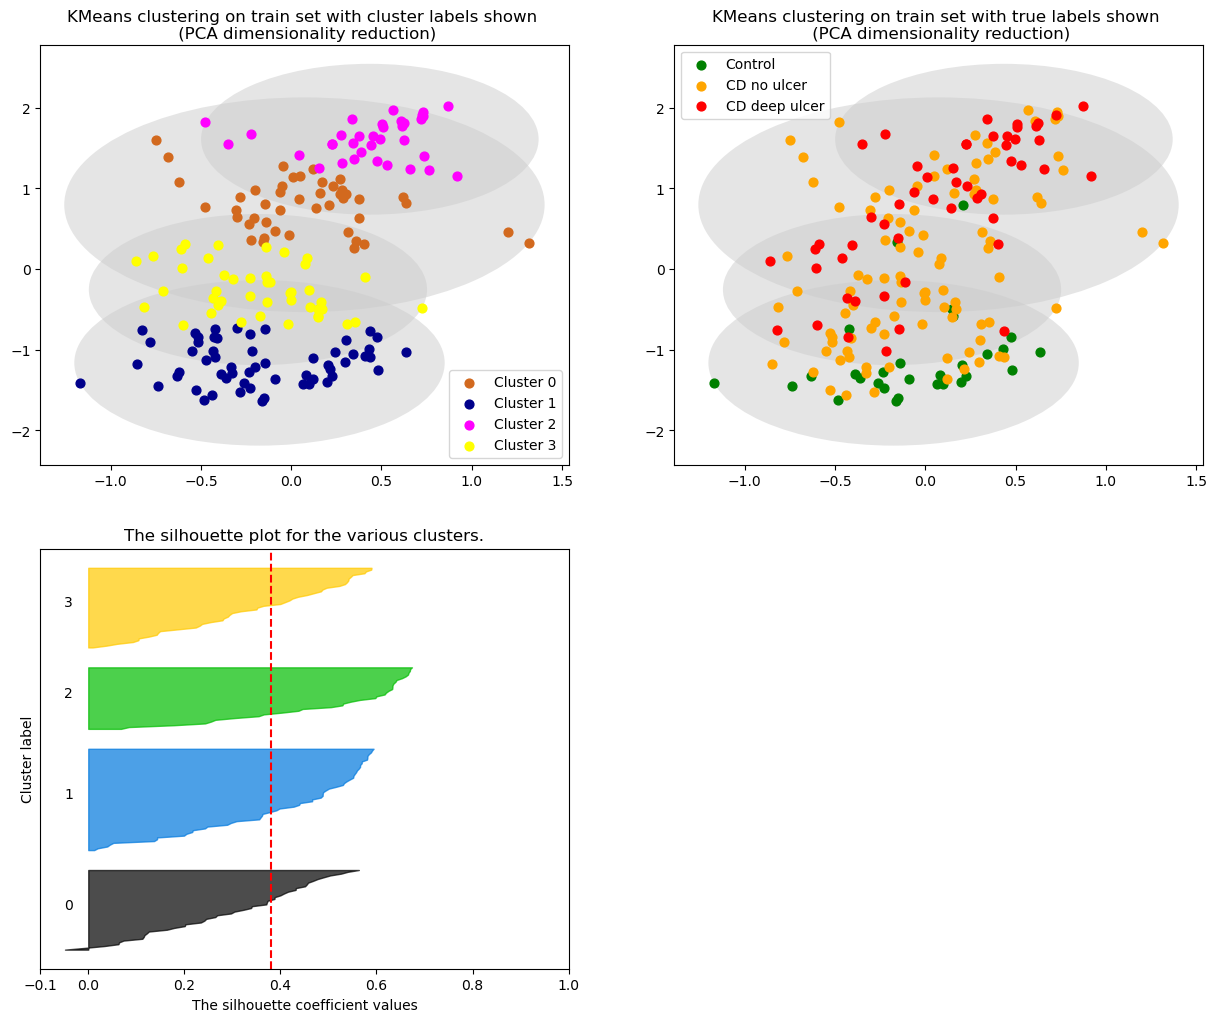

The average silhouette_score is : 0.38136467


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 250


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


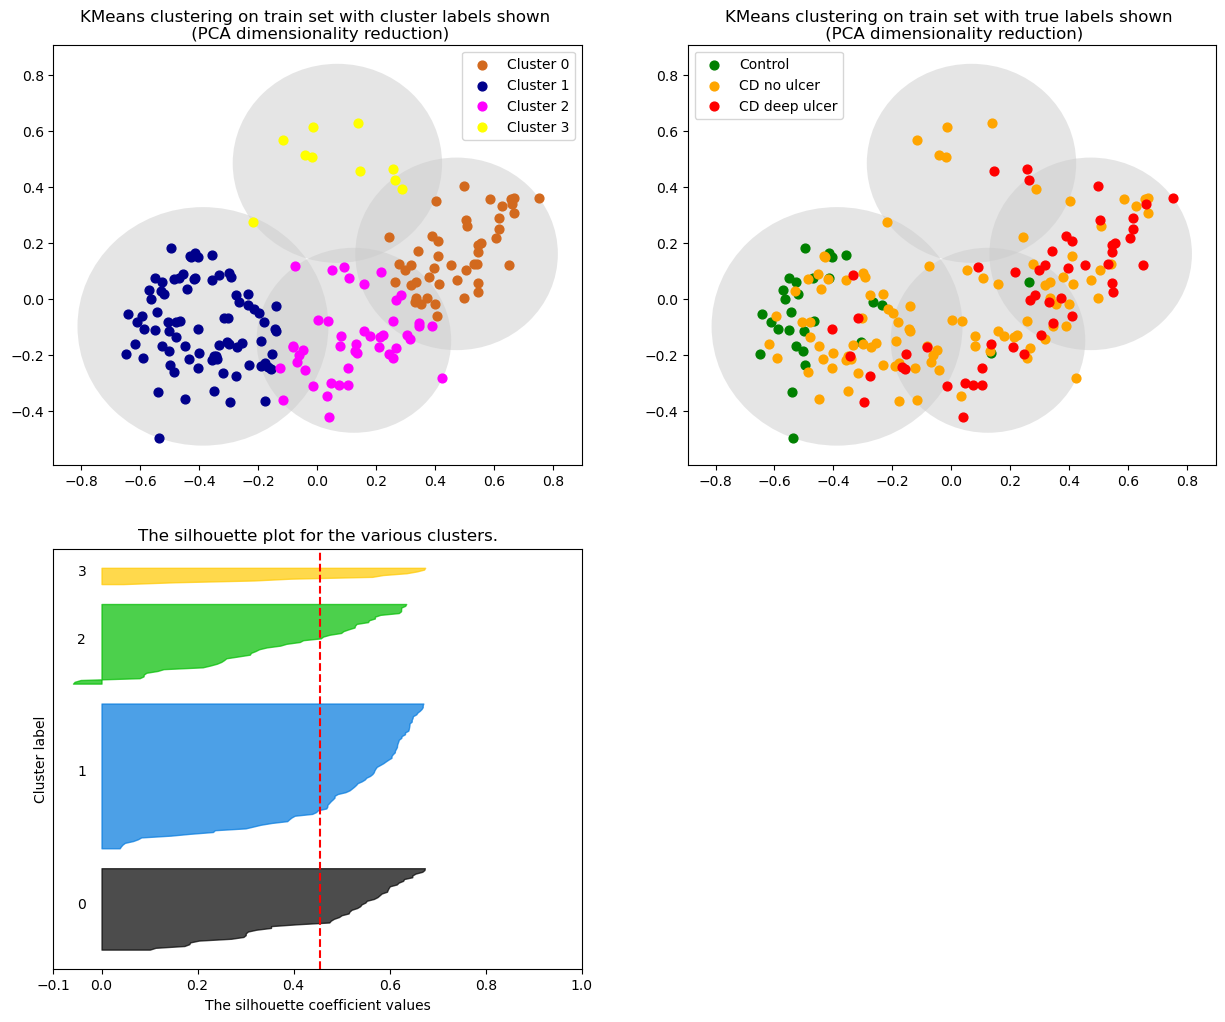

The average silhouette_score is : 0.45472047


In [31]:
perplexities = [10, 20, 50, 70, 100, 150, 200, 250]
# perplexities = [200, 300]

for perplexity in perplexities:
    kmeans_pca, X_train_pca, X_test_pca, k_labels_train_pca, k_labels_test_pca, centers_pca, radii_pca = train_kmeans(full_pca_dataset, perplexity)
    print("Perplexity =",perplexity)
#     print(k_labels_train_pca)
    plot_kmeans(X_train_pca, train_disease_labels, k_labels_train_pca, centers_pca, radii_pca, "PCA", test_set=False, plot_sil=True)

### Testing

In [27]:
X_test_pca.shape

(78, 2)

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 50


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


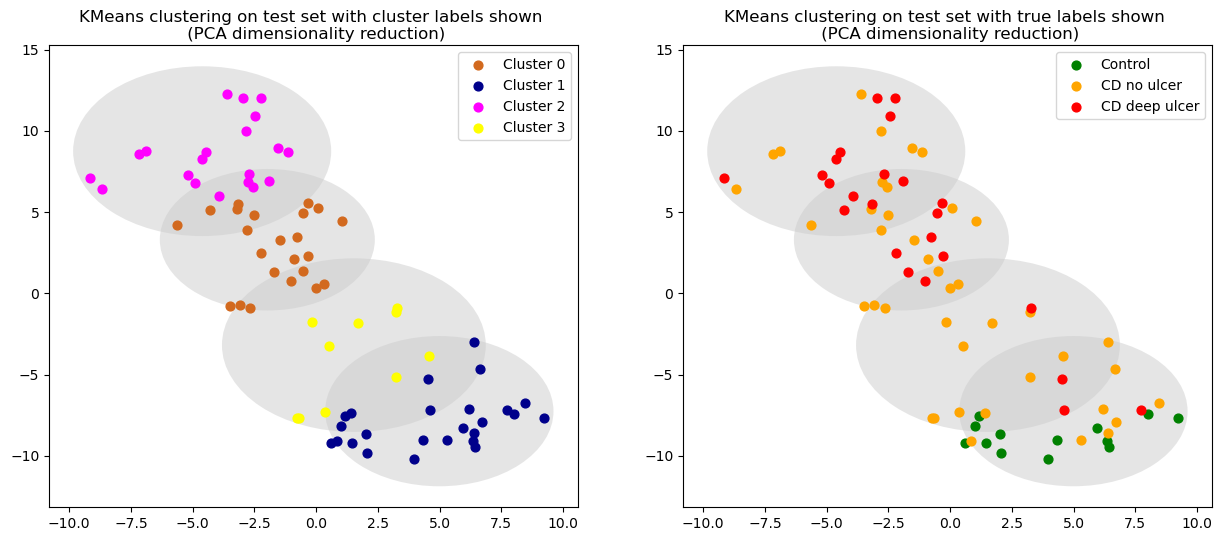

In [32]:
# plot with chosen tsne
perplexity = 50
kmeans_pca, X_train_pca, X_test_pca, k_labels_train_pca, k_labels_test_pca, centers_pca, radii_pca = train_kmeans(full_pca_dataset, perplexity)
print("Perplexity =",perplexity)
plot_kmeans(X_test_pca, test_disease_labels, k_labels_test_pca, centers_pca, radii_pca, "PCA", test_set=True)

### Fit KMeans (Autoencoder & tSNE dimensionality reduction)

### Training

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 10


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


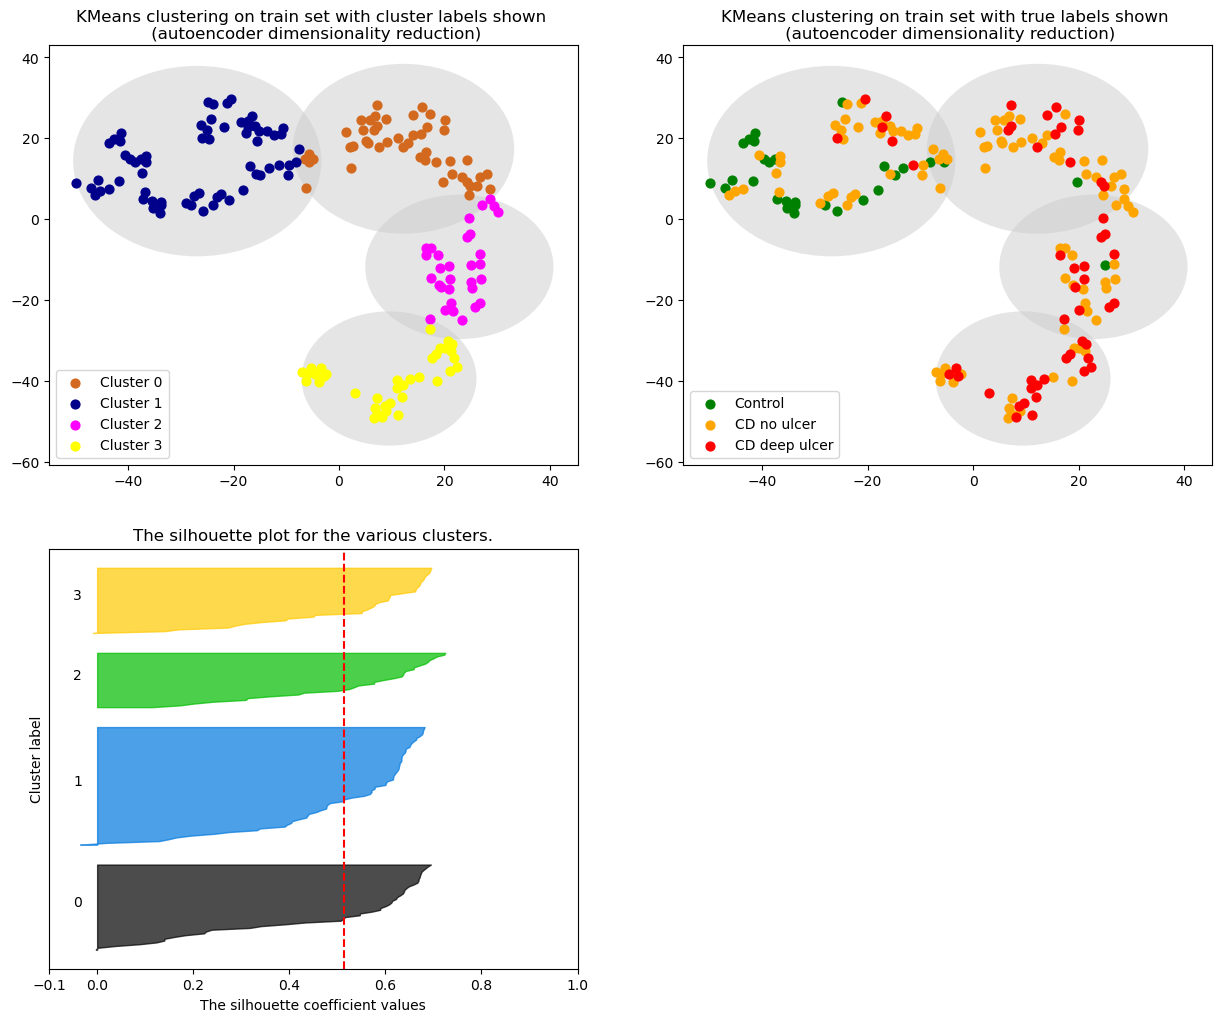

The average silhouette_score is : 0.51311


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 20


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


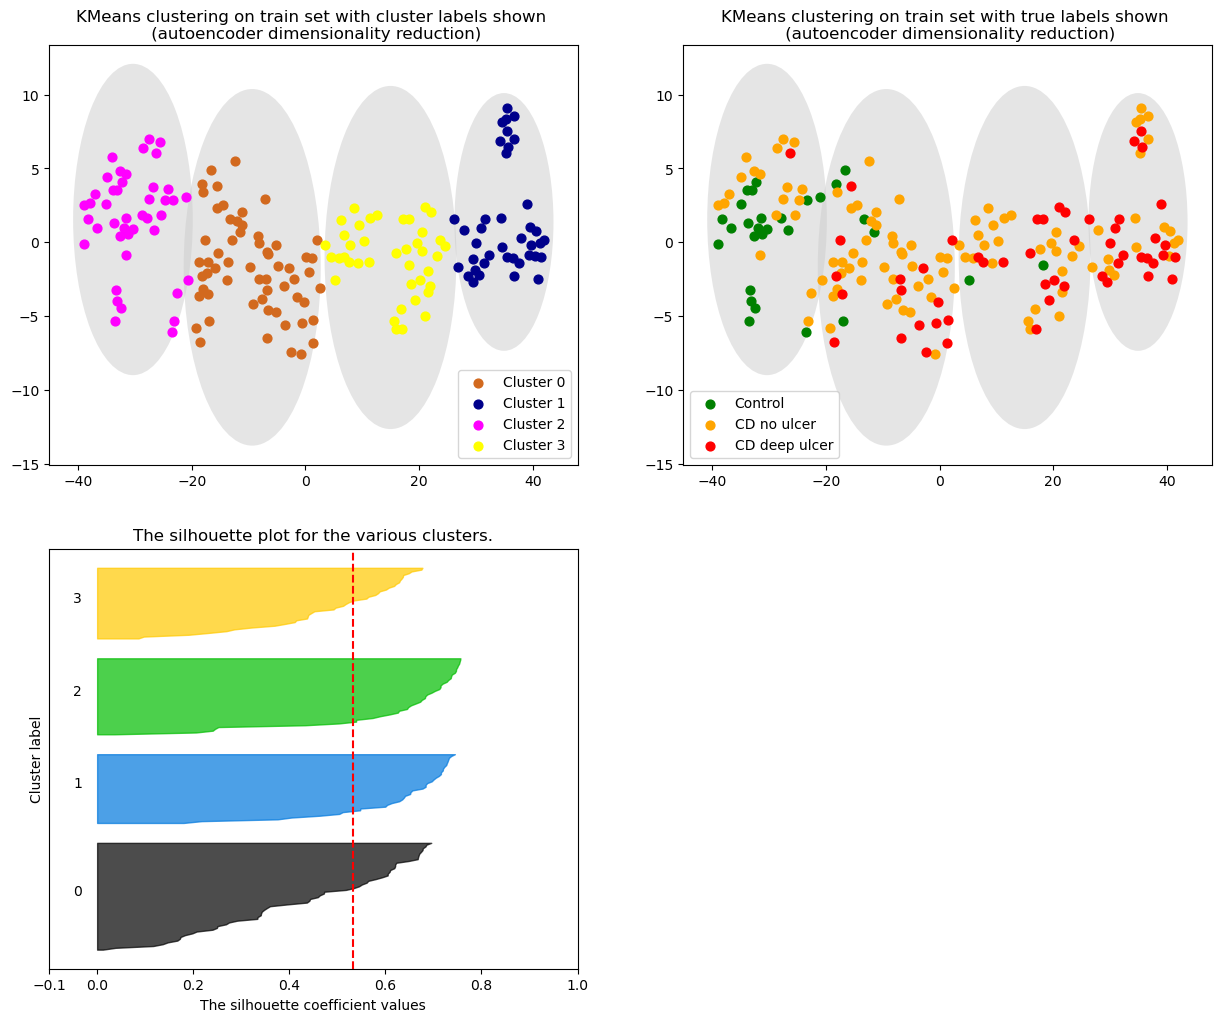

The average silhouette_score is : 0.5318949


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 50


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


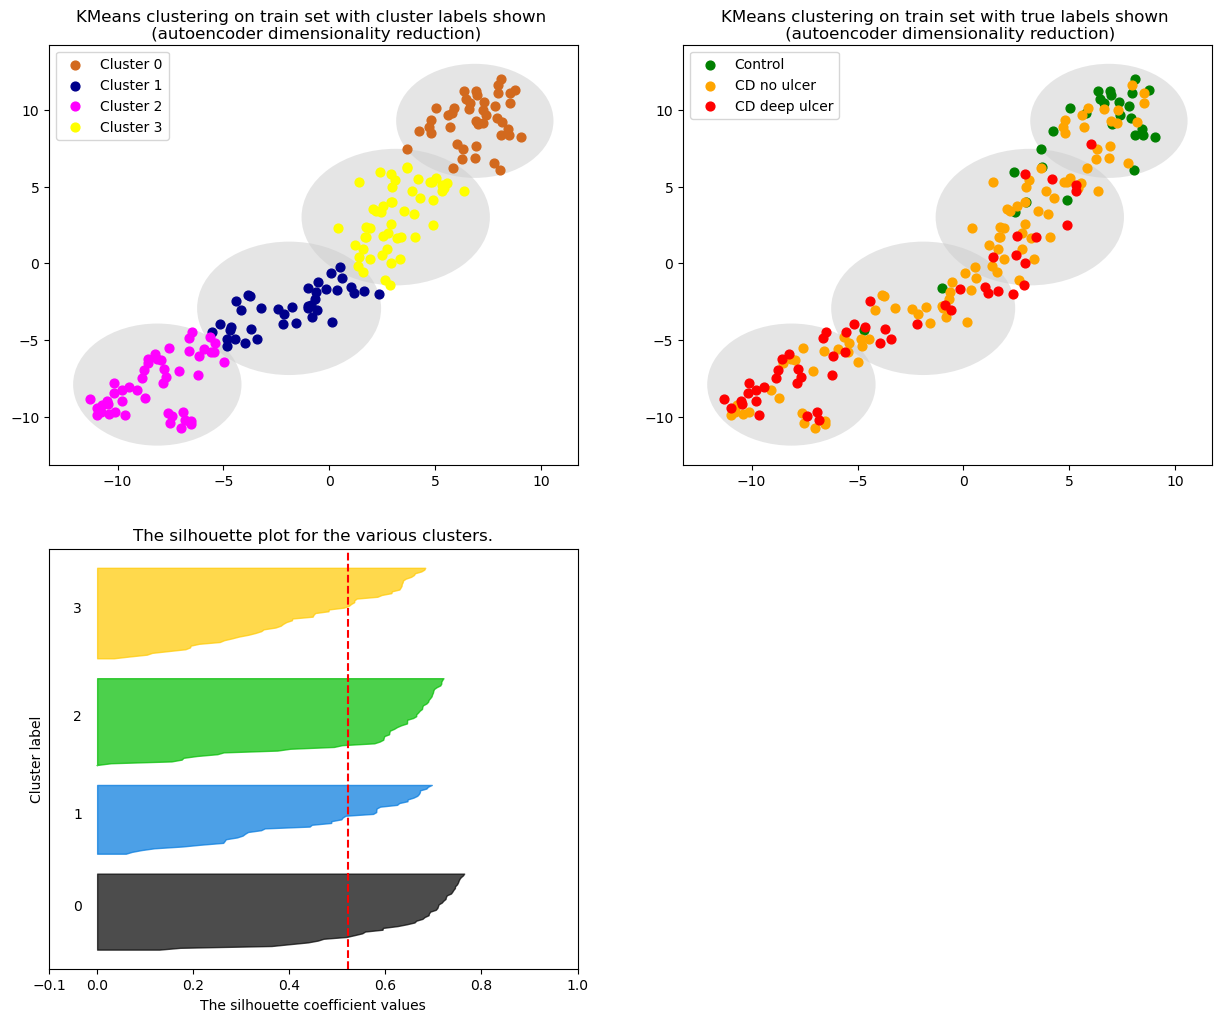

The average silhouette_score is : 0.5213408


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 70


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


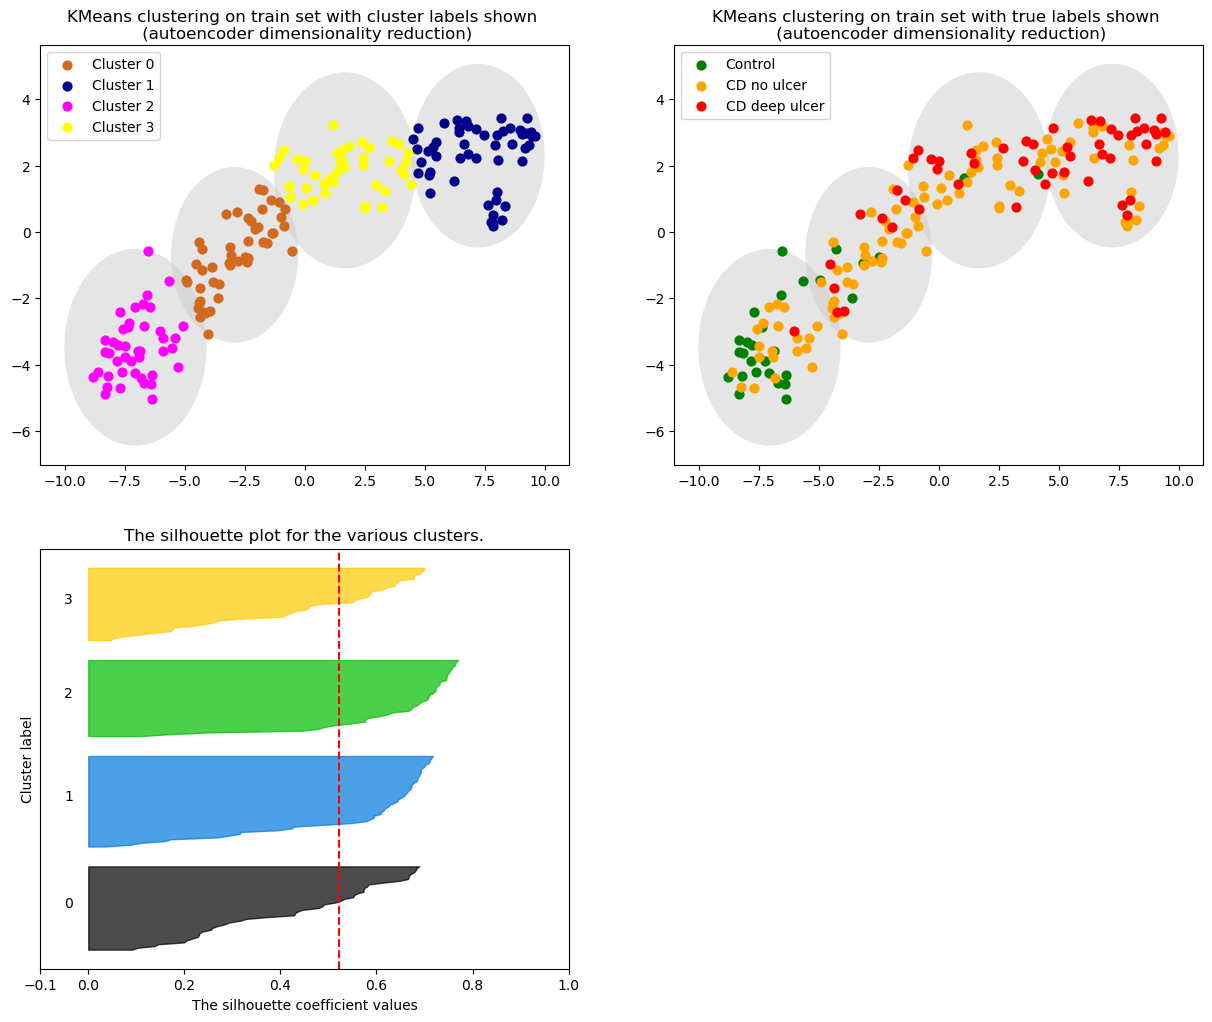

The average silhouette_score is : 0.5216258


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 100


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


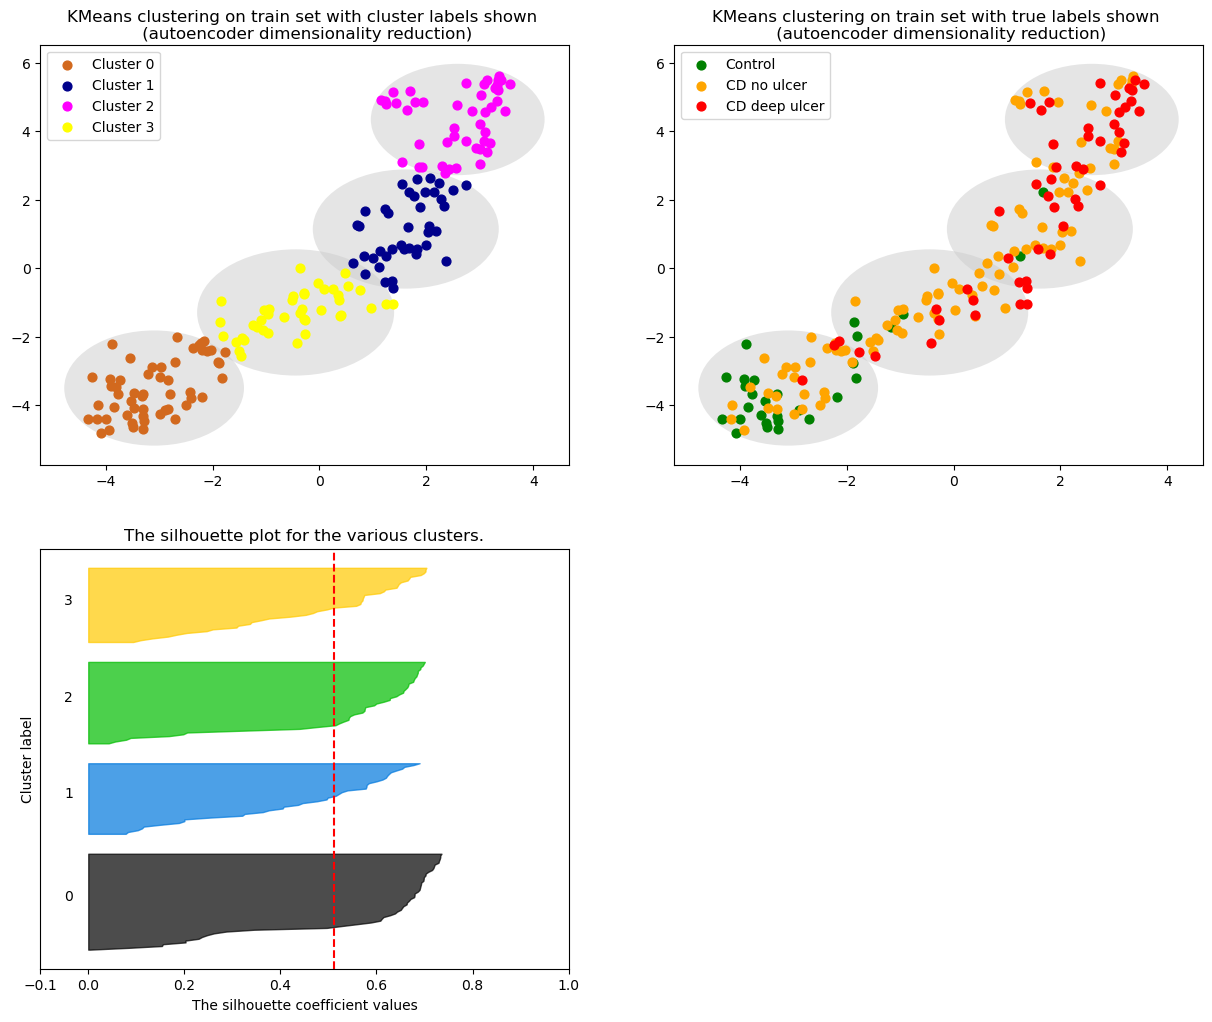

The average silhouette_score is : 0.5107157


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 150


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


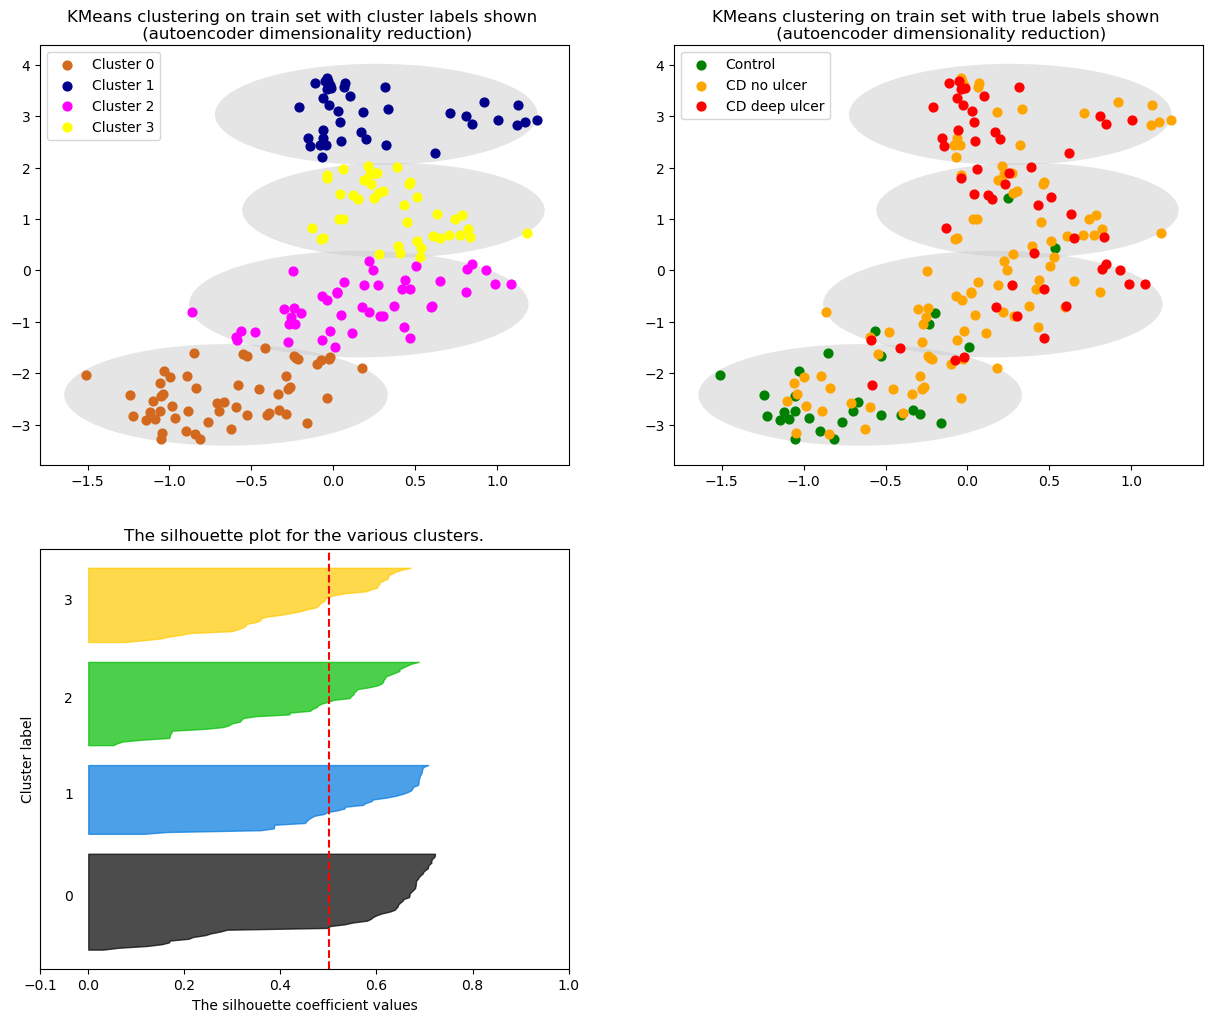

The average silhouette_score is : 0.50033575


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 200


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


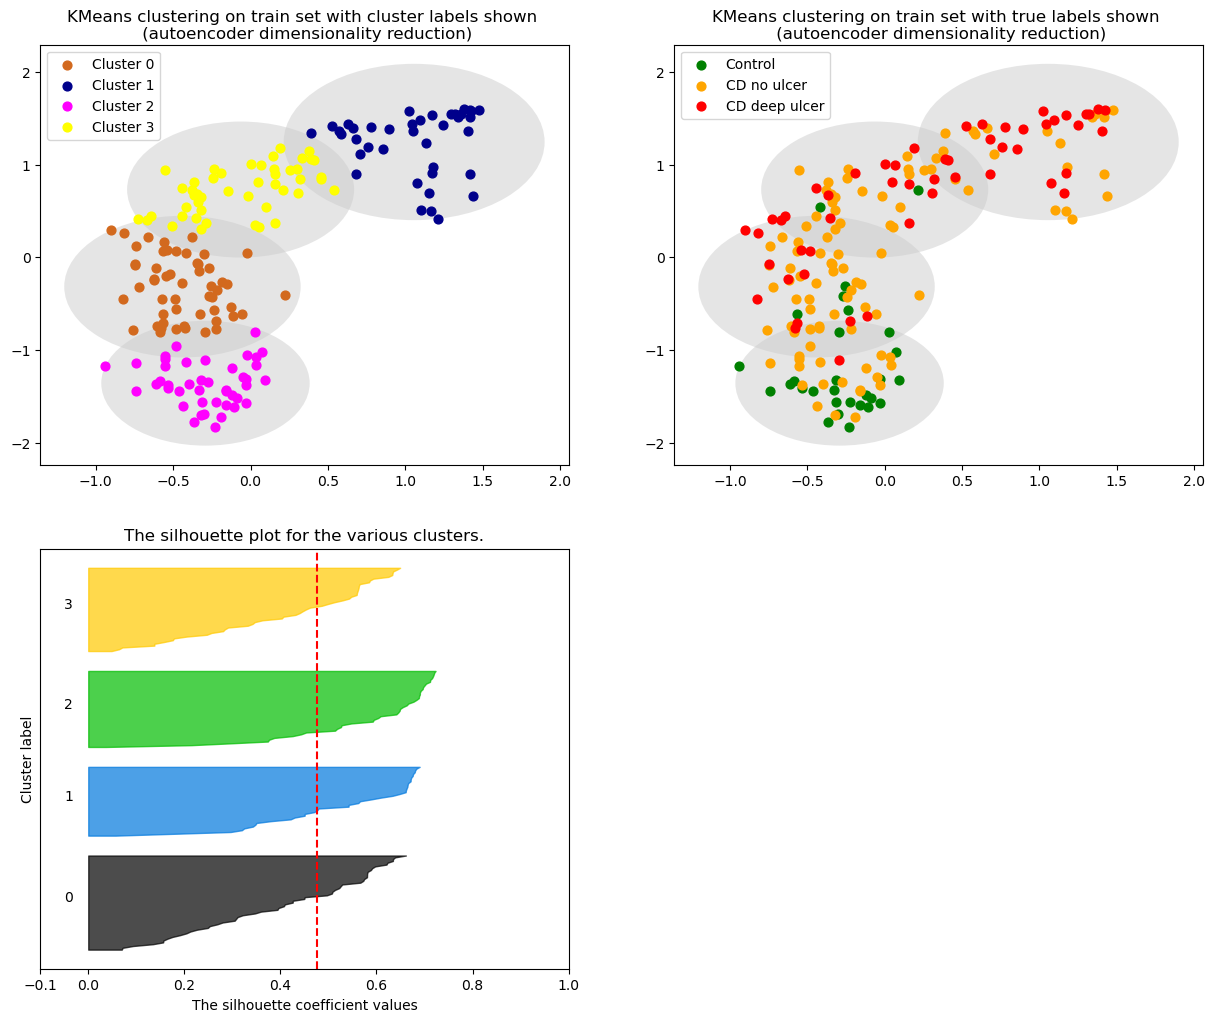

The average silhouette_score is : 0.47695345


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 250


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


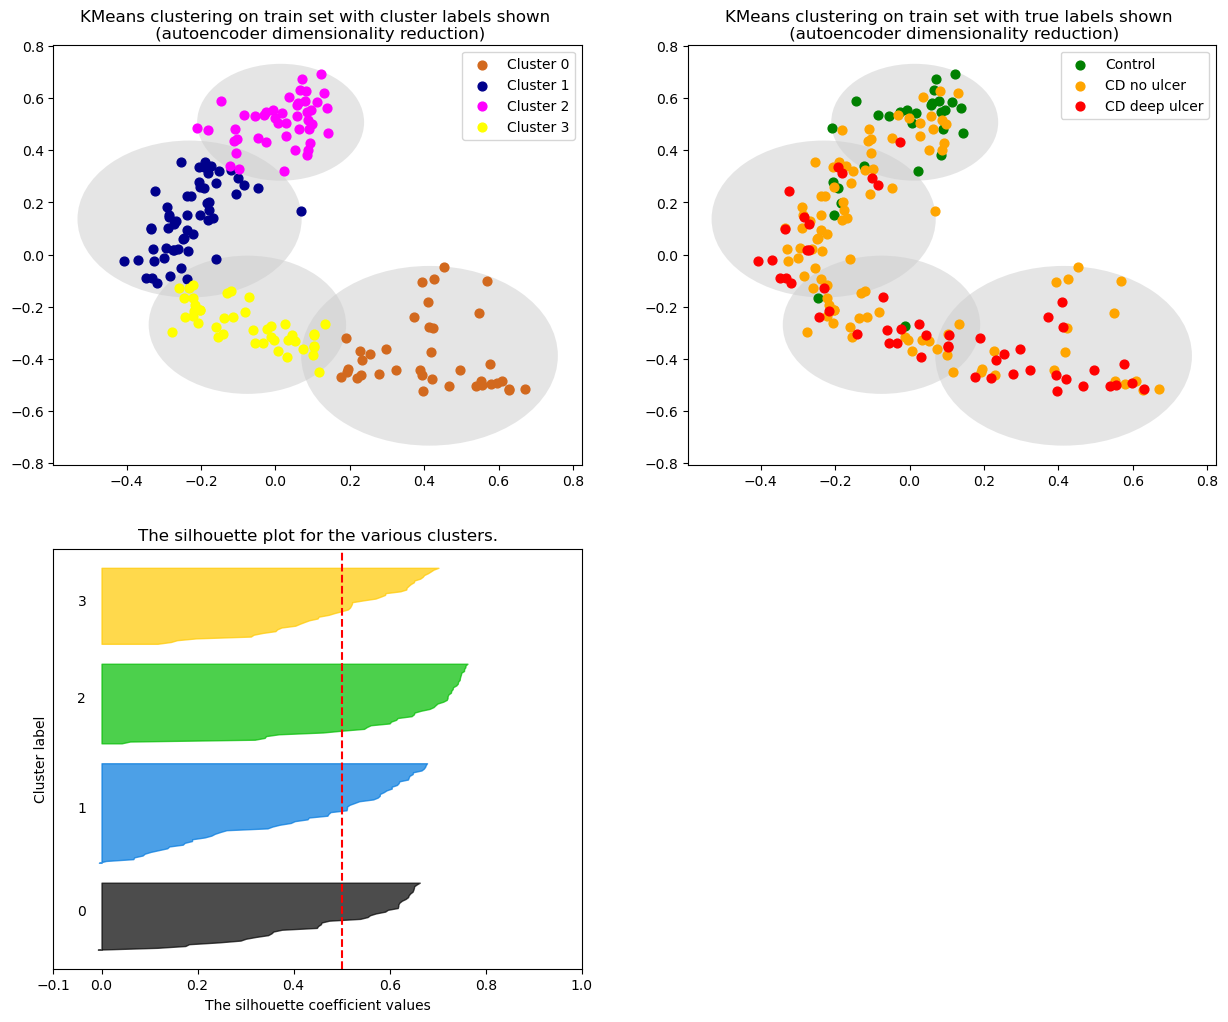

The average silhouette_score is : 0.500013


In [34]:
# perplexities = [10, 20, 50, 70]
perplexities = [10, 20, 50, 70, 100, 150, 200, 250]

for perplexity in perplexities:
    kmeans_ae, X_train_ae, X_test_ae, k_labels_train_ae, k_labels_test_ae, centers_ae, radii_ae = train_kmeans(full_ae_dataset, perplexity)
    print("Perplexity =",perplexity)
    plot_kmeans(X_train_ae, train_disease_labels, k_labels_train_ae, centers_ae, radii_ae, "autoencoder", test_set=False, plot_sil=True)

### Testing

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 50


C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


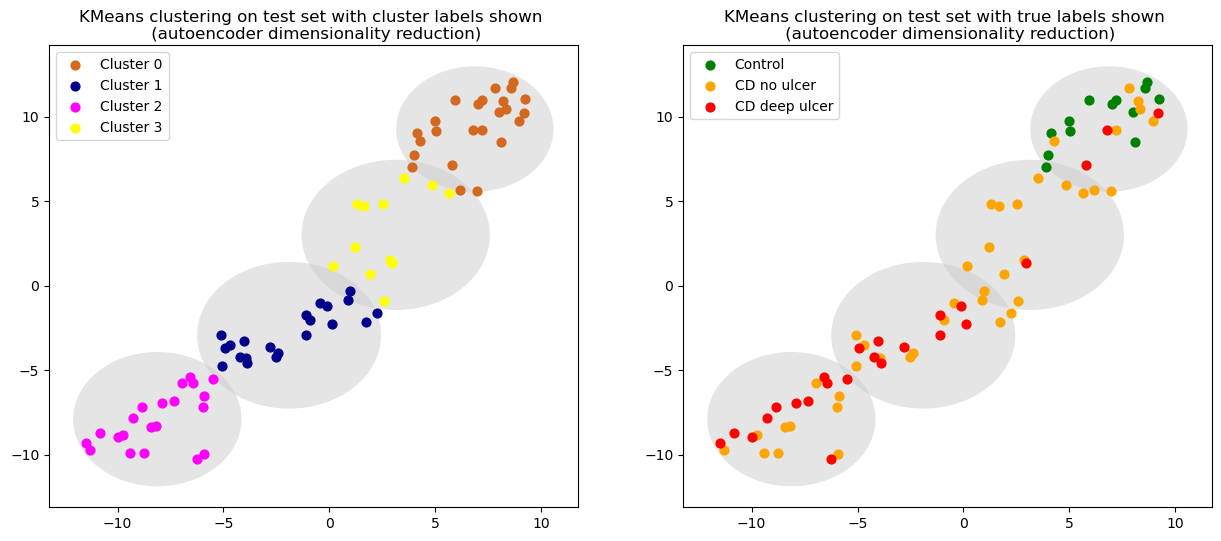

In [35]:
# plot with chosen tsne
perplexity = 50
kmeans_ae, X_train_ae, X_test_ae, k_labels_train_ae, k_labels_test_ae, centers_ae, radii_ae = train_kmeans(full_ae_dataset, perplexity)
print("Perplexity =",perplexity)
plot_kmeans(X_test_ae, test_disease_labels, k_labels_test_ae, centers_ae, radii_ae, "autoencoder", test_set=True)

## Process KMeans models

In [36]:
def pair_repeat(dup, cls_assignments, num_c, amounts):
    all_clusters = np.arange(num_c)
    # replace one of the duplicates with max of remaining clusters
    replace_class = np.where(cls_assignments == dup[0])[0][0]
    rem_cluster_a, rem_cluster_b = np.setdiff1d(all_clusters,cls_assignments)
    # rem_cluster_b
    if amounts[replace_class][rem_cluster_a] > amounts[replace_class][rem_cluster_b]:
        cls_assignments[replace_class] = rem_cluster_a
    else:
        cls_assignments[replace_class] = rem_cluster_b
        
    return cls_assignments

def handle_duplicates(cls_assignments, dup, c, num_c, amounts):
#     print("c:",c)
    if len(c) != 1:
        
        cls_assignments = pair_repeat(dup, cls_assignments, num_c, amounts)
    else: # 3 repeats of same thing
        # reassign class least associated to next most associated cluster
        given_cluster = dup[0]
        cls_least = np.argmin(amounts[:,given_cluster])
#         print(cls_least)
        class_amounts = amounts[cls_least,:]
        class_amounts[given_cluster] = -1
        next_cluster = np.argmax(class_amounts)
        cls_assignments[cls_least] = next_cluster
#         print("intermediate assignments",cls_assignments)
        
        # handle other duplicate pair
        u, c = np.unique(cls_assignments, return_counts=True)
        dup = u[c > 1]
        cls_assignments = pair_repeat(dup, cls_assignments, num_c, amounts)

    return cls_assignments


def softmax(x): 
    return np.exp(x)/sum(np.exp(x))

In [37]:

    
def process_clusters(amounts, X_train, num_c):
    all_clusters = np.arange(num_c)

    
    cls_assignments = np.argmax(amounts, axis=1) # assigned to class 0, 1, 2
    print("initial cls assignments:",cls_assignments)
    
    # check for and handle duplicates
    u, c = np.unique(cls_assignments, return_counts=True)
    dup = u[c > 1]
#     print("dup:",dup[0])
    if len(dup) > 0:
        cls_assignments = handle_duplicates(cls_assignments, dup, c, num_c, amounts)
        
            
    class_assignment_amounts = np.max(amounts, axis=1) 
    
    assignments = [None] * 3
    
    assigned = 0
    while assigned < num_c - 1:
        curr_max_class = np.argmax(class_assignment_amounts)
        assigned_cluster = cls_assignments[curr_max_class]
        if assignments[curr_max_class] is None:
            assignments[curr_max_class] = [assigned_cluster]
        else:
            assignments[curr_max_class].append(assigned_cluster)
        class_assignment_amounts[curr_max_class] = -1
        assigned += 1

    # Assign remaining cluster
    
    rem_cluster = np.setdiff1d(all_clusters,cls_assignments)[0]
    
    rem_cls_assignment = np.argmax(amounts[:,rem_cluster], axis=0)
    assignments[rem_cls_assignment].append(rem_cluster)
    couple = assignments[rem_cls_assignment]
    # clusters assigned to disease class 0, 1, 2 (control, CD_no_ulcer, CD_deep_ulcer)
    
#     print(assignments)
#     print(couple)
    return assignments, couple

In [38]:
def get_class_from_label(label, couple, assignments):
    if label in couple:
        search_term = couple
    else:
        search_term = [label]
    try:
        cls = assignments.index(search_term)
    except:
        return None
    return cls


In [39]:
def get_final_clusters(assignments, couple, labels):
    test_set_clusters = []
    for label in labels:
        cls = get_class_from_label(label, couple, assignments)
        test_set_clusters.append(cls)

    test_set_clusters = np.array(test_set_clusters)
    return test_set_clusters

In [40]:
# centers = kmeans.cluster_centers_
# centers

In [41]:
num_c = 4

In [42]:
def get_count_matrix_km(kmeans, X_train, train_disease_labels):

    
    # make matrix to record number of each class in each cluster
    amounts = np.zeros((3, num_c))
    
    
    classes = ["control", "CD_no_ulcer", "CD_deep_ulcer"]
    centers = kmeans.cluster_centers_
    for c, cls in enumerate(classes):
        for pt in X_train[train_disease_labels==c]:
            pt = pt.reshape(1,-1)
            distances = cdist(centers, pt, 'euclidean')
            closest_cluster = np.argmin(distances)
            amounts[c][closest_cluster] += 1
    

#     print(amounts)
    #                cluster 0, cluster 1, cluster 2, cluster 3
    # control 
    # CD no ulcer
    # CD deep ulcer
    
    return amounts

In [43]:
# get_count_matrix_km(kmeans, X_train, train_disease_labels)

### Apply resulting models to test sets

In [44]:
centers_pca

array([[-1.9751167,  3.2997756],
       [ 4.991225 , -7.2524295],
       [-4.614312 ,  8.750343 ],
       [ 1.5304382, -3.1872623]], dtype=float32)

In [45]:
km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]


In [46]:
# X_test_ae

C:\Users\shard\AppData\Local\Temp\ipykernel_27428\3233753954.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


initial cls assignments: [0 3 2]
initial cls assignments: [1 3 2]


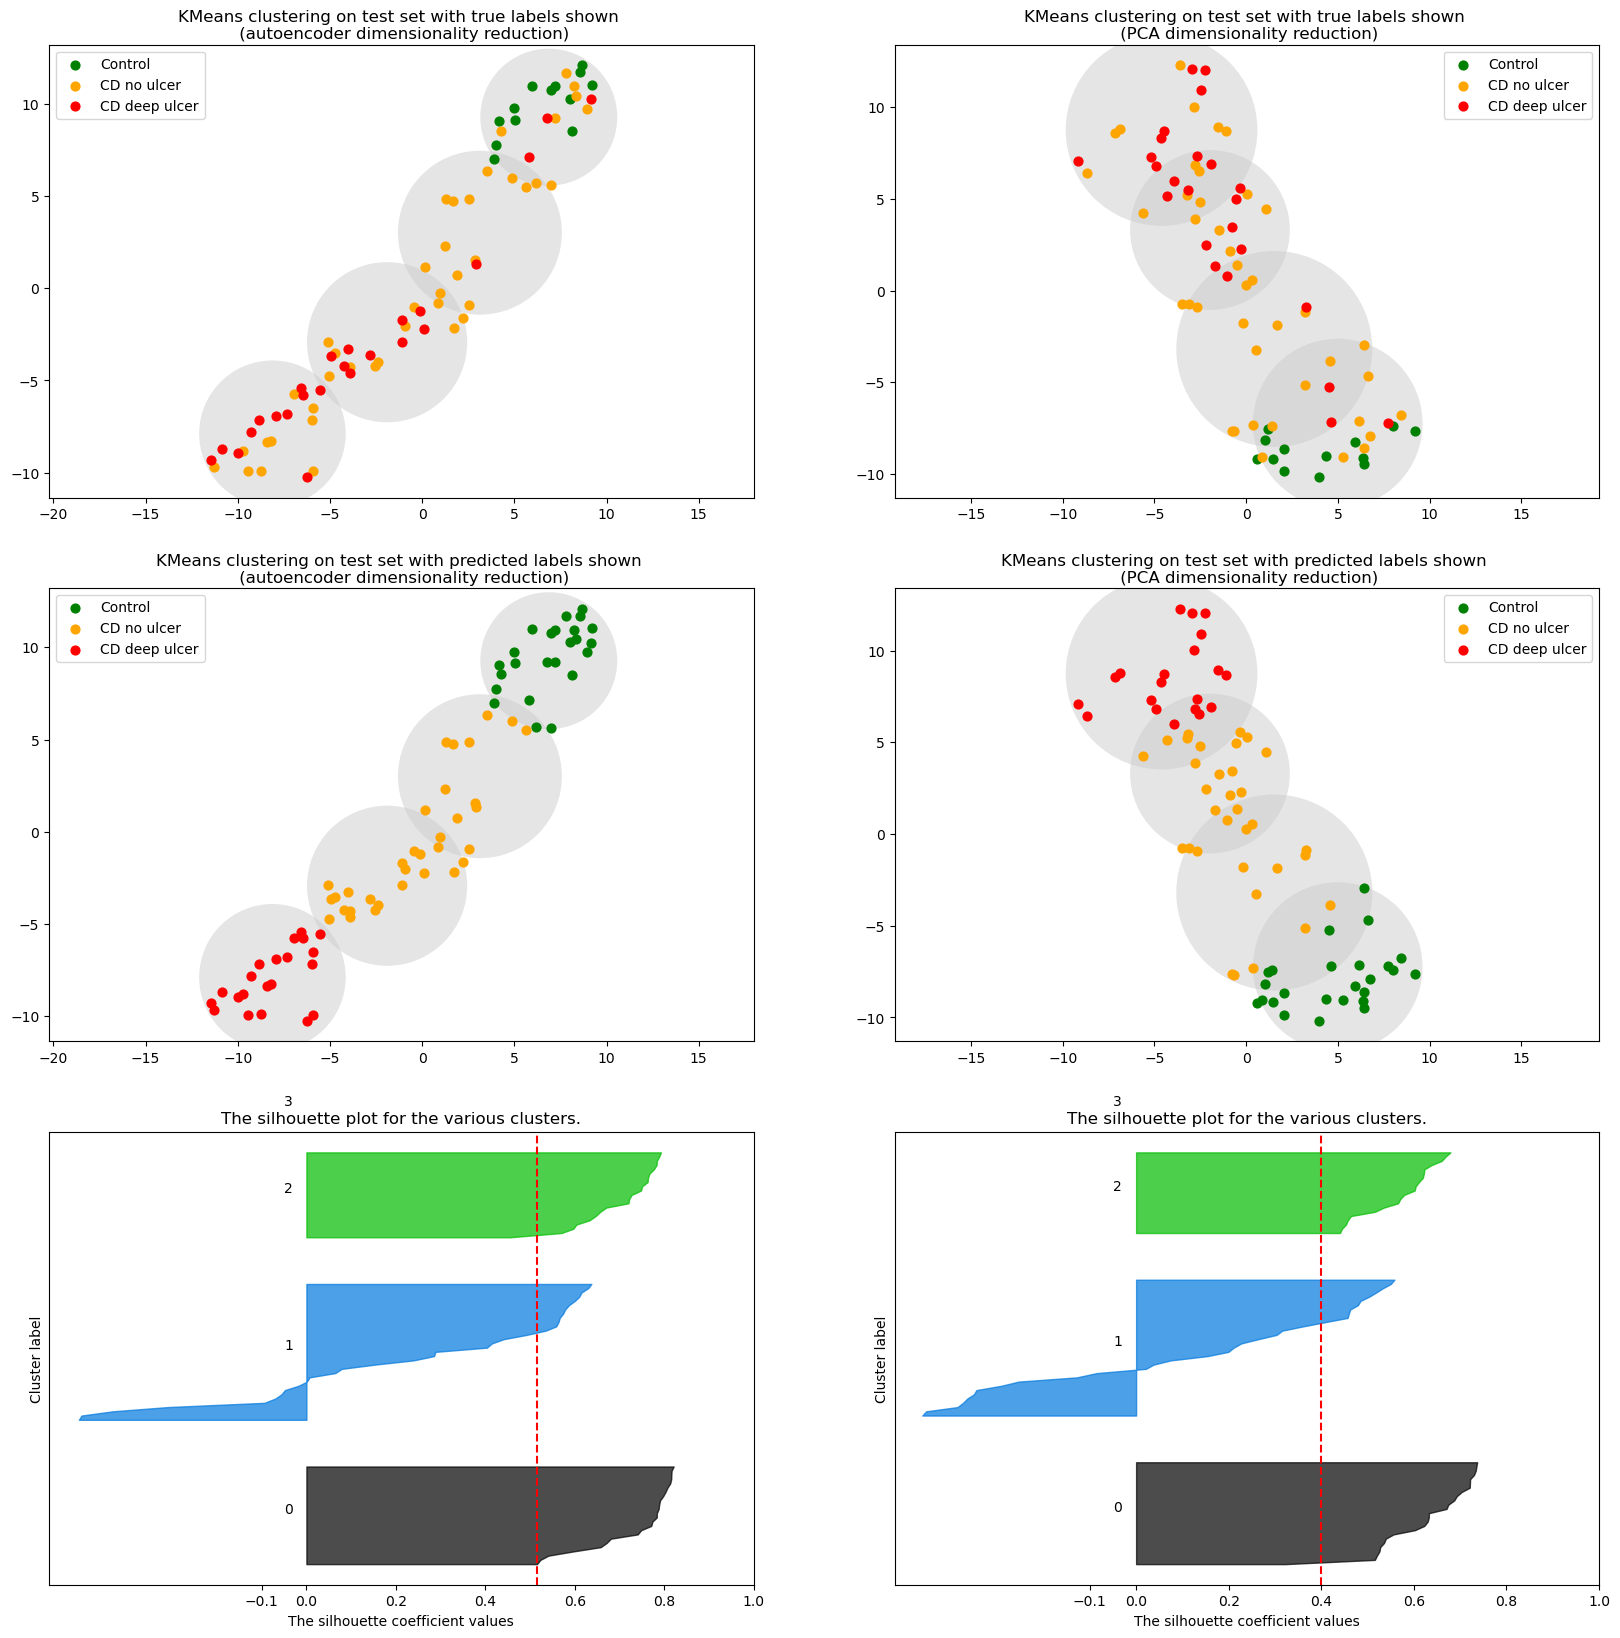

Autoencoder: average silhouette score = 0.5160543
PCA: average silhouette score = 0.39906225


In [47]:
def plot_final_km_models(labels_list, models_list, train_set_list, test_set_list, centers_list, radii_list, num_c):

    (fig, subplots) = plt.subplots(3, 2, figsize=(20,20))
    reduction = ["autoencoder", "PCA"]
    final_clusters_lst = []
    label_type = ["true","predicted"]
    for t in range(2):
        label = label_type[t]
        for i in range(len(models_list)):
    #         print(i)
            ax = subplots[t][i]
            km = models_list[i]
            km_labels = labels_list[i]
            X_train = train_set_list[i]
            X_test = test_set_list[i]
            centers = centers_list[i]
            radii = radii_list[i]
            if t > 0:
                amounts = get_count_matrix_km(km, X_train, train_disease_labels)
                assignments, couple = process_clusters(amounts, X_train, num_c)
                test_set_clusters = get_final_clusters(assignments, couple, km_labels)
                final_clusters_lst.append(test_set_clusters)
            else:
                test_set_clusters = test_disease_labels
    #         print("gmmlabels:",gmm_labels)
    #         print("tsclusters:",test_set_clusters)
    #         print("asgn:",assignments)
            

#             if t > 0:
#                 test_set_clusters, probs = final_gmm_model_get_clusters(gmm, X_train, X_test, train_disease_labels)
#                 final_clusters_lst.append(test_set_clusters)
#                 final_probs_lst.append(probs)
#             else:
#                 test_set_clusters = test_disease_labels


            reduc = reduction[i]
            num_clusters = 3
            cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
            colours = ["green", "orange", "red"]
            ax.set_title("KMeans clustering on test set with "+label+" labels shown \n (" + reduc + " dimensionality reduction)",
                        wrap=True)

            for i in range(num_clusters):
                ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 

            ax.axis('equal')


            for c, r in zip(centers, radii):
                ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

            ax.legend()

    s_avgs = []
    for j in range(2):
        ax = subplots[2][j]
        X_test = test_set_list[j]
        test_clusters = final_clusters_lst[j]

        silhouette_avg, sample_silhouette_values = compute_silh_scores(X_test, test_clusters)
        s_avgs.append(silhouette_avg)
        plot_silhouette(num_c, test_clusters, sample_silhouette_values, silhouette_avg, ax)

    plt.show()

    print("Autoencoder: average silhouette score =",s_avgs[0])
    print("PCA: average silhouette score =",s_avgs[1])

    return final_clusters_lst
        
final_clusters_ae, final_clusters_pca = plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c)

In [48]:
final_clusters_ae

array([0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1,
       0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, 2, 2,
       0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1])

## Gaussian Mixture Models

In [49]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

from matplotlib.patches import Ellipse
from sklearn import mixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, true_labels, reduction, num_c=3, test=False, plot_sil=False):
    
    
    num_rows = 2 if plot_sil else 1
    dim_h = 12 if plot_sil else 6
    dim_w = 15 if plot_sil else 15
    (fig, subplots) = plt.subplots(num_rows, 2, figsize=(dim_w, dim_h))
    

    gmm_labels = gmm.predict(X)
#     (fig, subplots) = plt.subplots(1, 2, figsize=(15, 6))
#     ax = ax or plt.gca()
    labels = [gmm_labels, true_labels]
    num_clusters = 3
    dset = "test" if test else "train"
    for i, label_set in enumerate(labels):
        ax = subplots[0][i] if plot_sil else subplots[i]
#         left = -8
#         right = 8
#         ax.set_xlim(left, right)
#         ax.set_ylim(left, right)
        
        
        if i==0:
            num_clusters = num_c
            cluster_names = ["Cluster " + str(i) for i in range(num_clusters)]
            colours = ["chocolate", "darkblue", "magenta", "yellow", "blue"]
            ax.set_title("GMM soft clustering on " + dset + " set with cluster labels shown \n (" + reduction + " dimensionality reduction)",
                         wrap=True)
        else:
            num_clusters = 3
            cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
            colours = ["green", "orange", "red"]
            ax.set_title("GMM soft clustering on " + dset + " set with true labels shown \n (" + reduction + " dimensionality reduction)",
                        wrap=True)
            
        for i in range(num_clusters):
            ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 

        ax.axis('equal')
        

        w_factor = 0.2 / gmm.weights_.max()
        for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
            draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)
        ax.legend()
        
        
    if plot_sil:
        silhouette_avg, sample_silhouette_values = compute_silh_scores(X, gmm_labels)
        plot_silhouette(num_c, gmm_labels, sample_silhouette_values, silhouette_avg, subplots[1][0])
        subplots[1][1].axis('off')
        
    
    plt.show()
    
    if plot_sil:
        print("The average silhouette_score is :",silhouette_avg)
        
    return gmm_labels

        
# def get_tsne_ds_true_labels():
#     tsne = manifold.TSNE(
#         n_components=2,
#         init="random",
#         random_state=0,
#         perplexity=24,
#         n_iter=750,
#         method='exact'
#     )
#     X = tsne.fit_transform(test_set)

In [237]:
# gmm.means_
# gmm.covariances_
# gmm.weights_

### Fit GMM with PCA dimensionality reduction

#### Training

In [52]:
num_c = 4

def fit_gmm(full_dataset, perplexity, num_c):
    gmm = mixture.GaussianMixture(n_components=num_c,covariance_type='full', random_state=42)
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_dataset)
    X_test = X[split_pt:]
    X_train = X[:split_pt]
    gmm.fit(X_train)
    
    return gmm, X_train, X_test

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 10


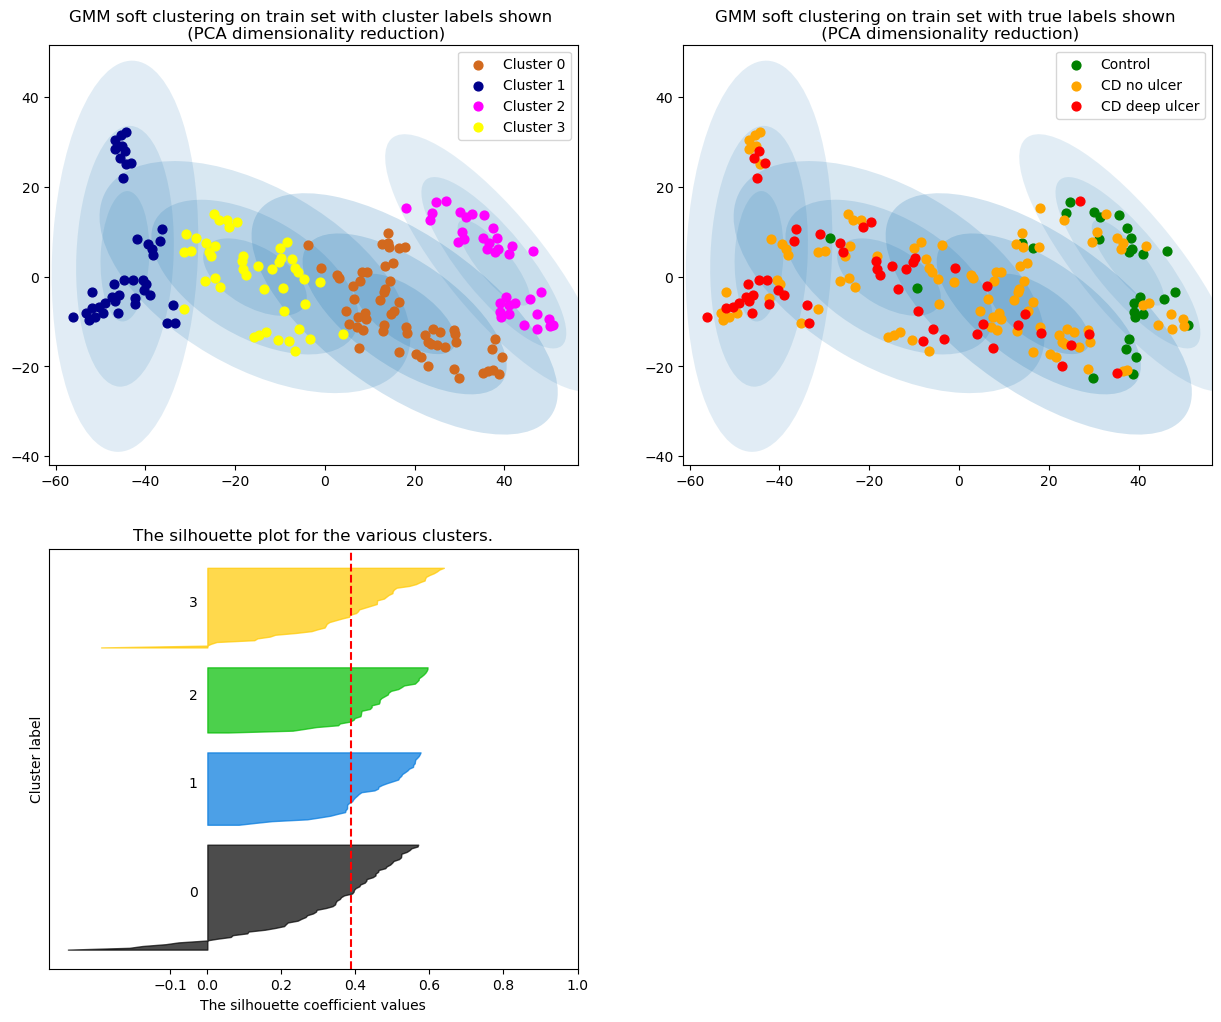

The average silhouette_score is : 0.38819537


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 20


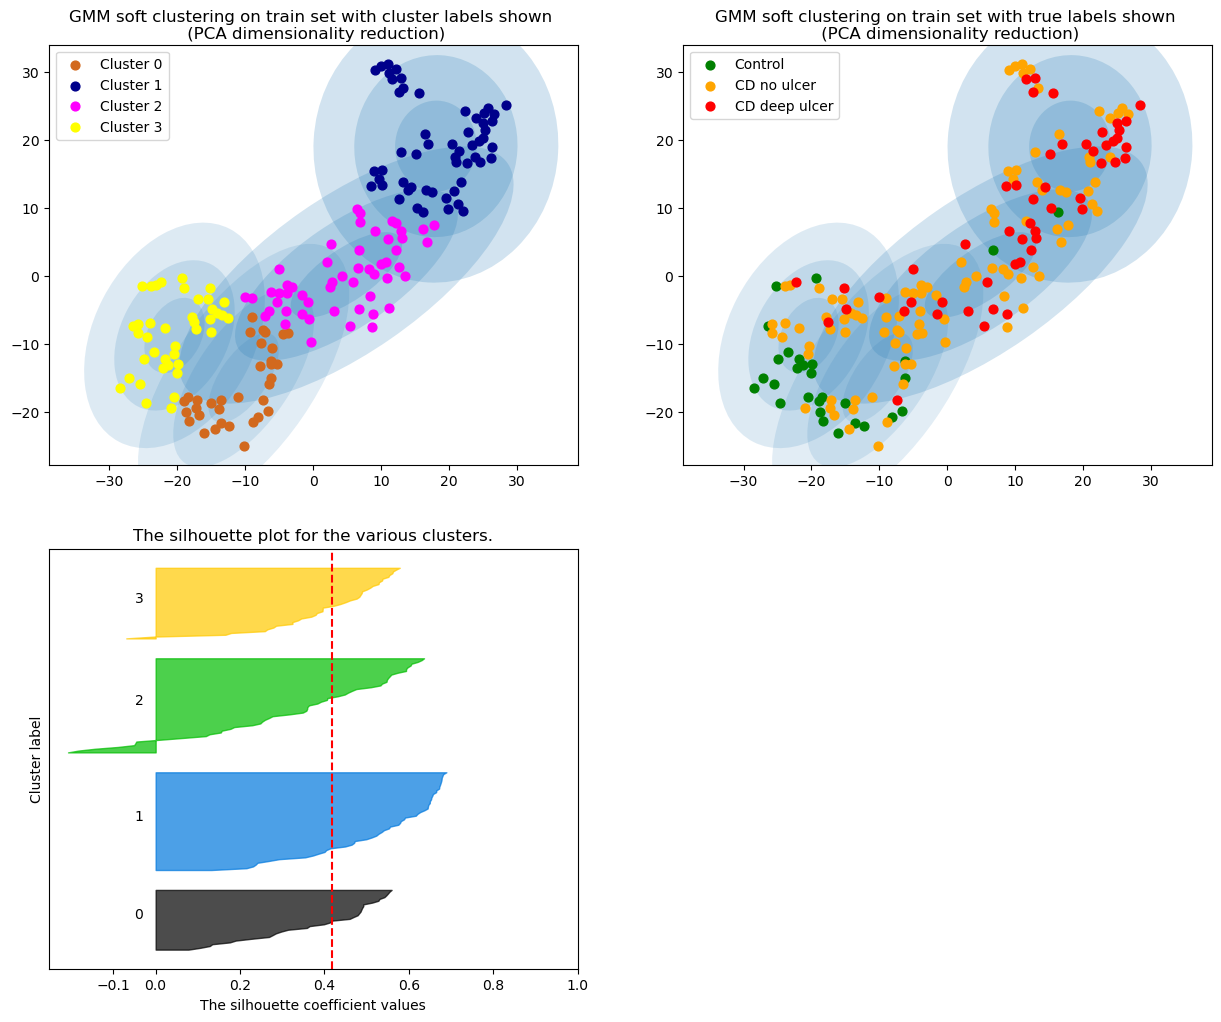

The average silhouette_score is : 0.41918492


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 50


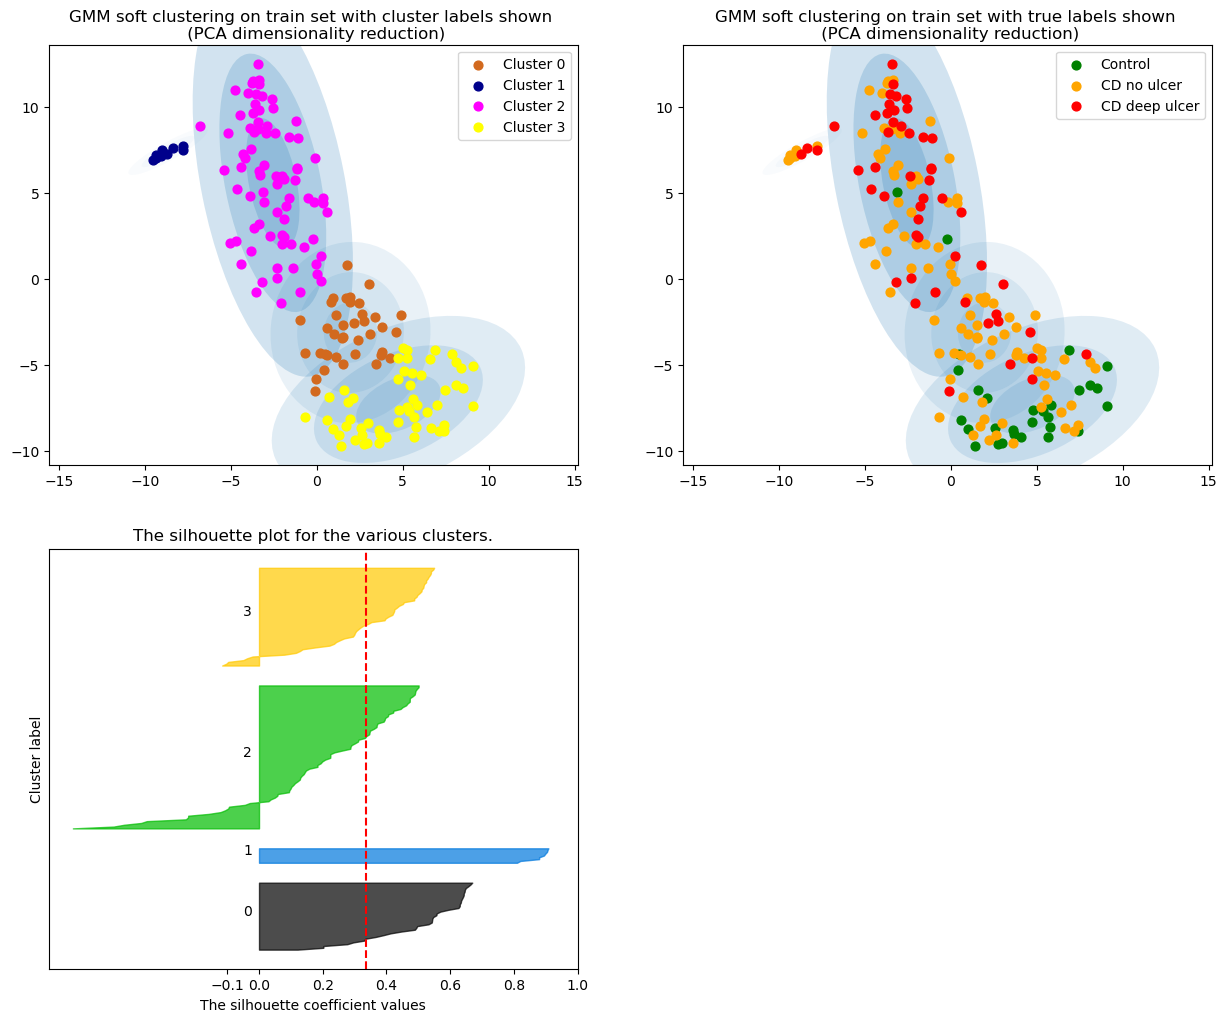

The average silhouette_score is : 0.33673298


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 70


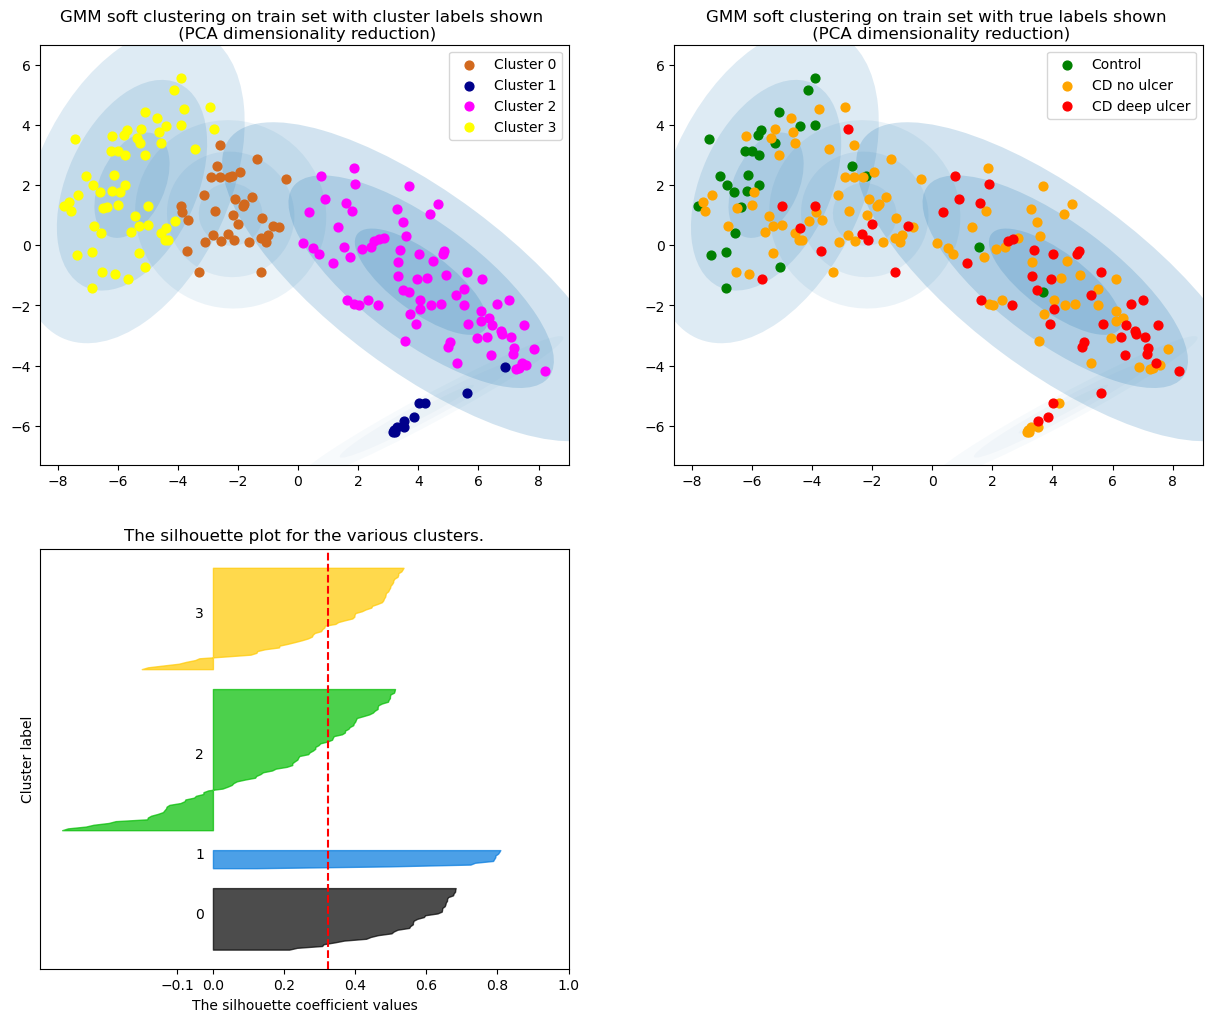

The average silhouette_score is : 0.32211795


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 100


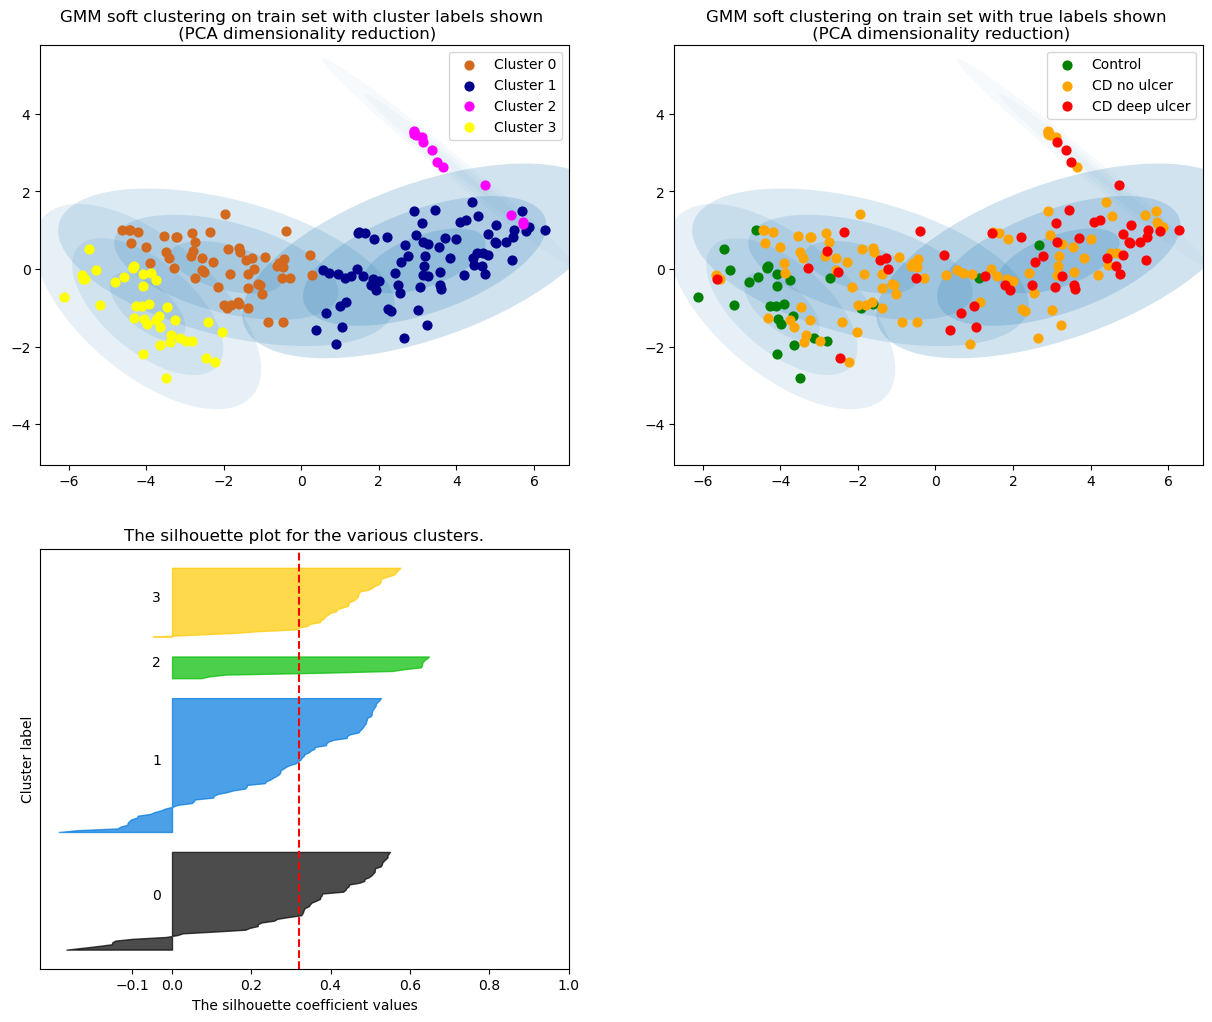

The average silhouette_score is : 0.32138085


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 150


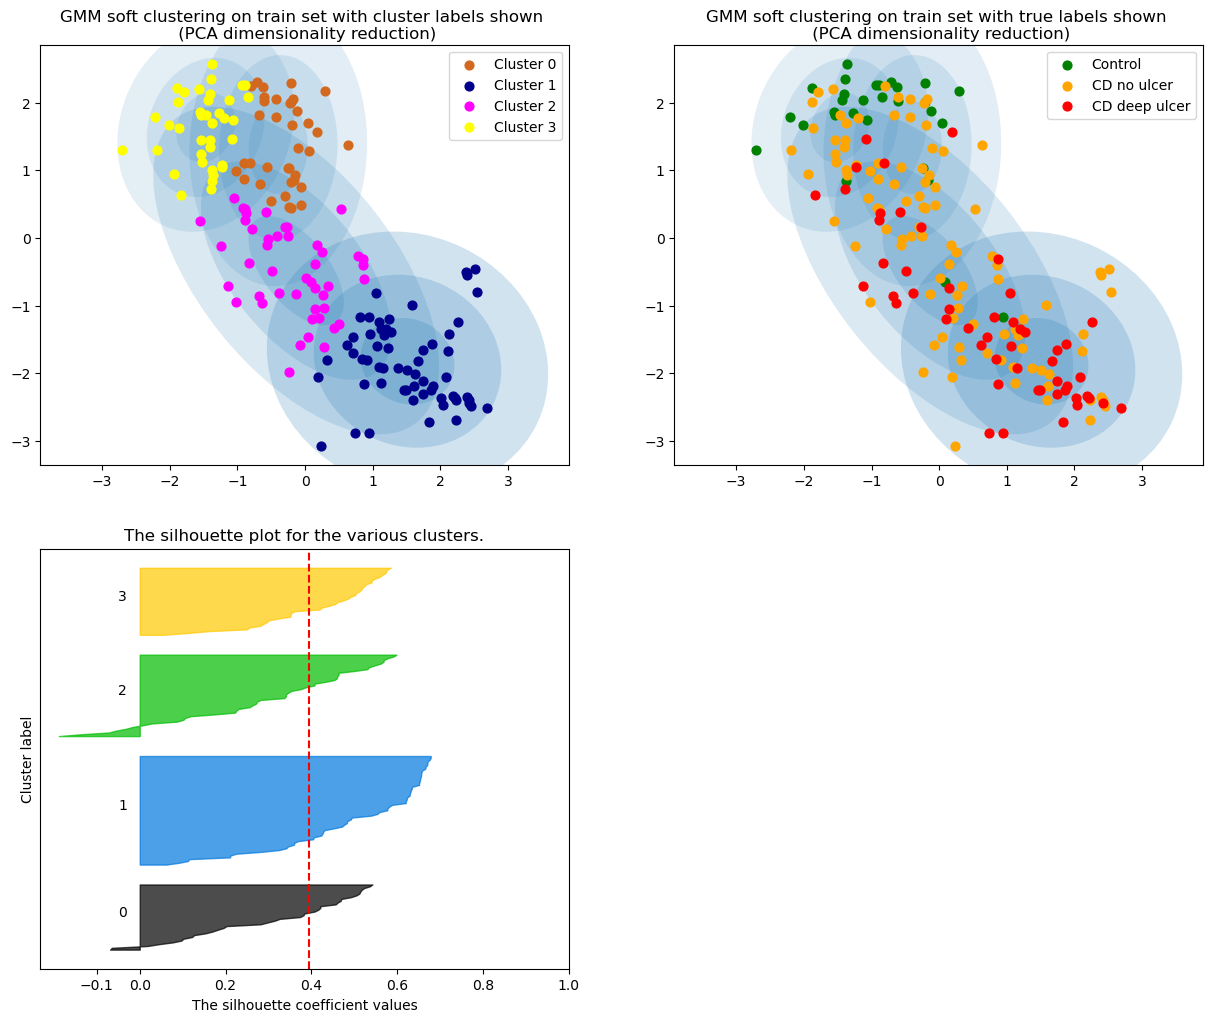

The average silhouette_score is : 0.3956199


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 200


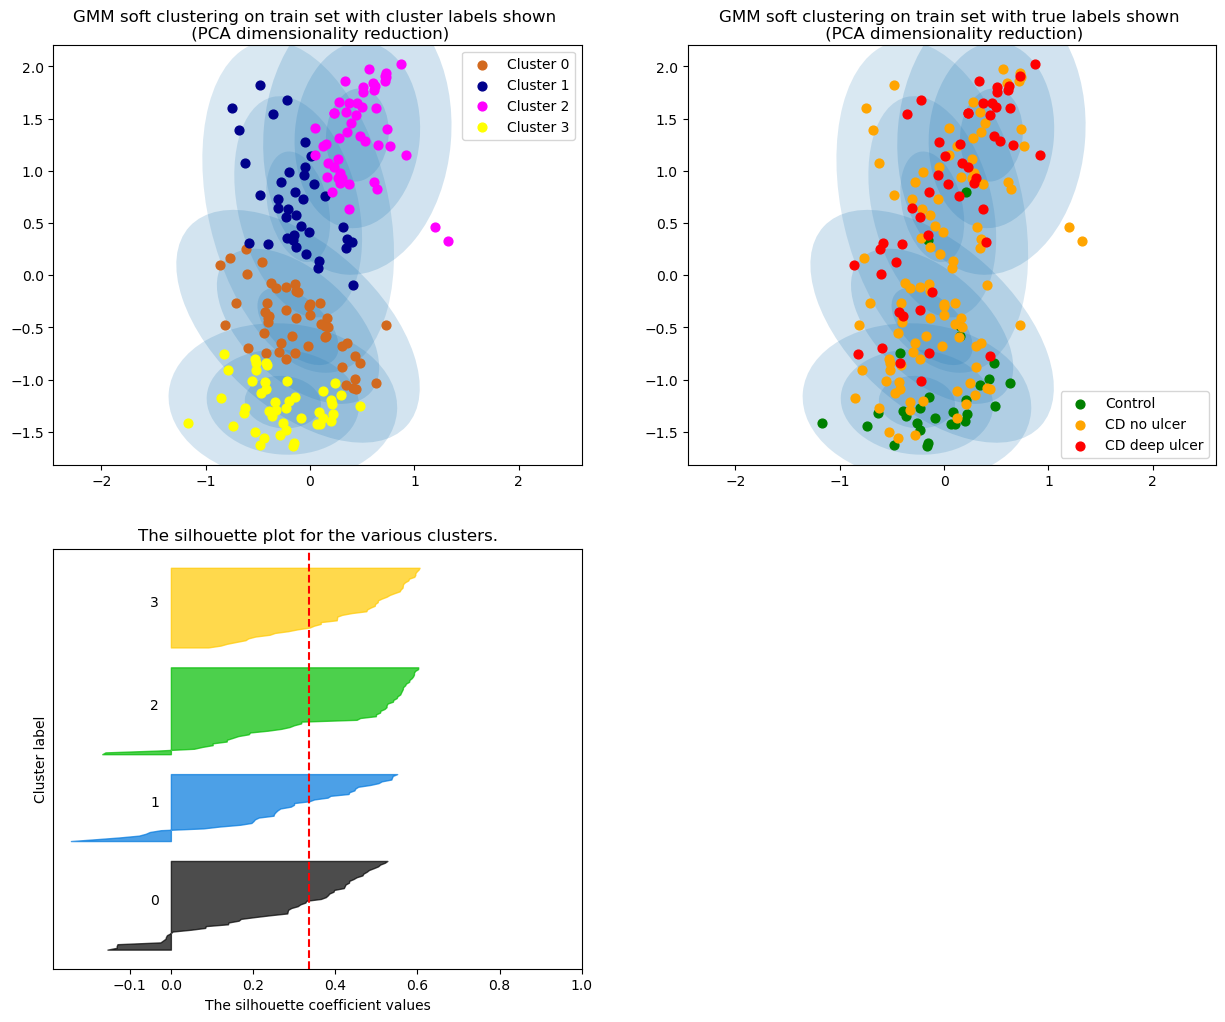

The average silhouette_score is : 0.3366563


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 250


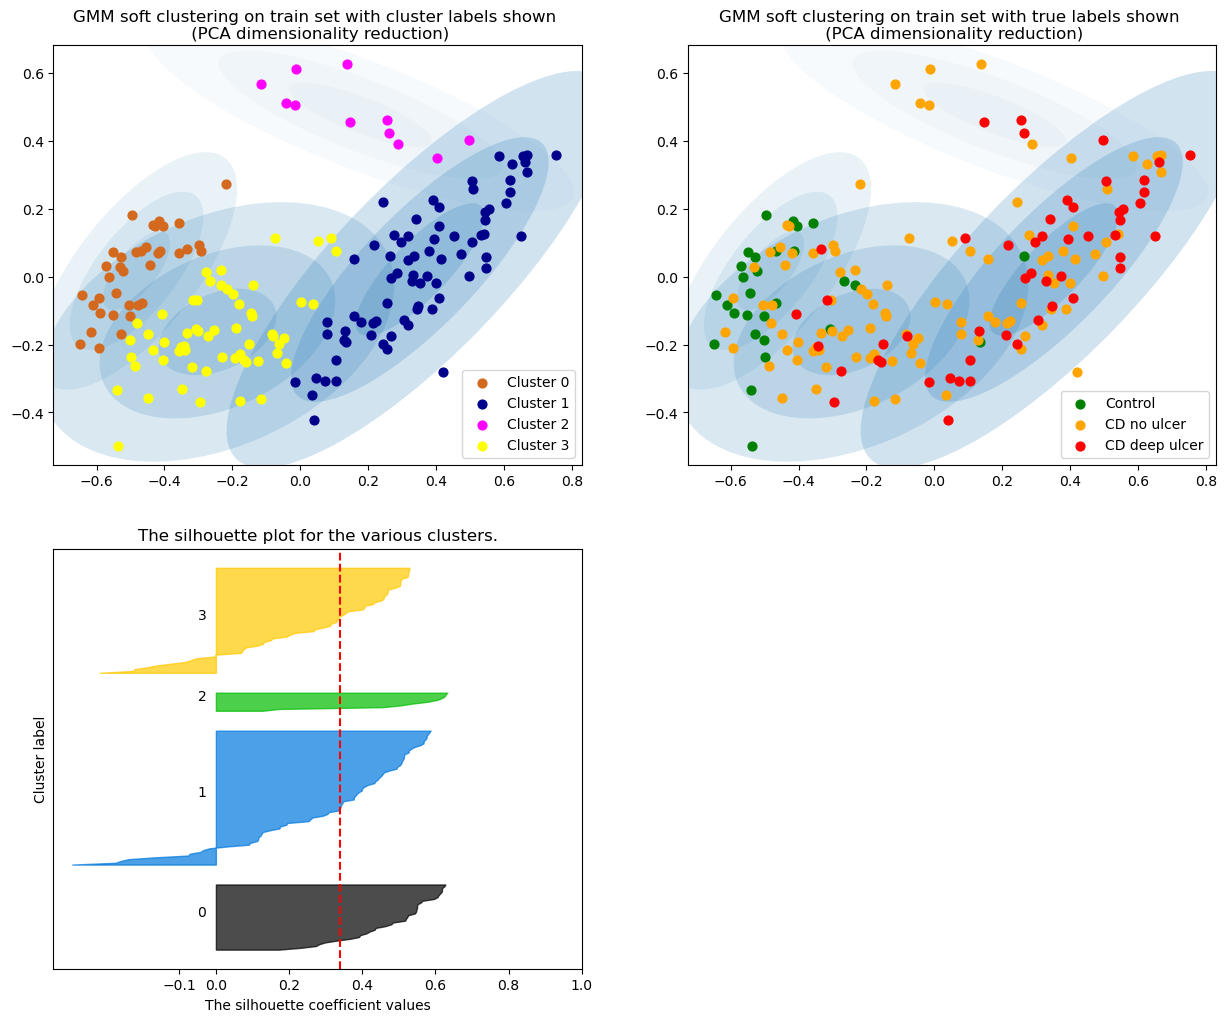

The average silhouette_score is : 0.33961973


In [53]:

# perplexities = [10, 20, 50, 70]
perplexities = [10, 20, 50, 70, 100, 150, 200, 250]
# perplexity = 24
for perplexity in perplexities:
    gmm_pca, X_train_pca, X_test_pca = fit_gmm(full_pca_dataset, perplexity, num_c)
    print("Perplexity =",perplexity)
    plot_gmm(gmm_pca, X_train_pca, train_disease_labels, "PCA", num_c=num_c, plot_sil=True)


#### Testing

In [54]:
full_ds


AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
55_control         0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain       0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control         0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control        0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain       0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                 ...             
55_control         1.000000  0.363133  0.374212  0.611161  ...  0.529274   
168_CD_plain       0.311962  0.251356  0.553554  0.441131  ...  0.485551   
72_control         0.648401  0.134017  0.200420  0.679453  ...  0.682864   
120_control        0.579519  0.248934  0.759250  0.755407  ...  0.760504   
258_CD_plain       0.370517  0.244987  0.445387  0.798000  ...  0.601023   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.273104   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.540150   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.561707   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.260826   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.598137   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
55_control               0.0        0.0  0.364776  0.465986  0.922559   
168_CD_plain             0.0        0.0  0.522378  0.578564  0.522145   
72_control               0.0        0.0  0.042221  0.025102  0.789751   
120_control              0.0        0.0  0.517359  0.672548  0.565864   
258_CD_plain             0.0        0.0  0.490289  0.858259  0.686037   
...                      ...        ...       ...       ...       ...   
107_CD_plain             0.0        0.0  0.511460  0.571813  0.718136   
279_CD_plain             0.0        0.0  0.967121  0.690670  0.586834   
179_CD_plain             0.0        0.0  0.532892  0.827410  0.584298   
70_CD_deep_ulcer         0.0        0.0  0.353435  0.470313  0.693233   
256_CD_deep_ulcer        0.0        0.0  0.550635  0.712620  0.543815   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
55_control         0.854193   0.224260  0.883418       0.0  
168_CD_plain       0.692076   0.021080  0.517763       0.0  
72_control         0.878183   0.048352  0.429987       0.0  
120_control        0.505961   0.021080  0.490510       0.0  
258_CD_plain       0.392018   0.021080  0.633386       0.0  
...                     ...        ...       ...       ...  
107_CD_plain       0.624635   0.021080  0.939056       0.0  
279_CD_plain       0.731743   0.021080  0.312015       0.0  
179_CD_plain       0.217127   0.195470  0.876301       0.0  
70_CD_deep_ulcer   0.466546   0.045757  0.799992       0.0  
256_CD_deep_ulcer  0.510634   0.021080  0.597887       0.0  

[260 rows x 220 columns]

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


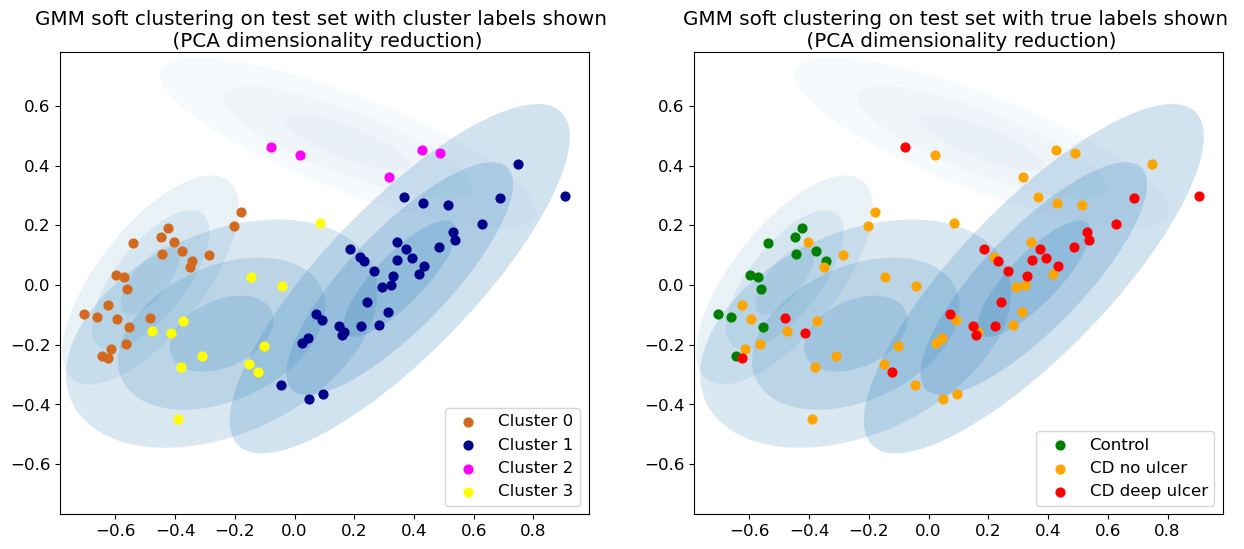

In [129]:
perplexity = 250
gmm_pca, X_train_pca, X_test_pca = fit_gmm(full_pca_dataset, perplexity, num_c)
gmm_labels_pca = plot_gmm(gmm_pca, X_test_pca, test_disease_labels, "PCA", num_c=num_c, test=True)


### Fit GMM with autoencoder dimensionality reduction

#### Training

In [242]:
# X_train_ae

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 10


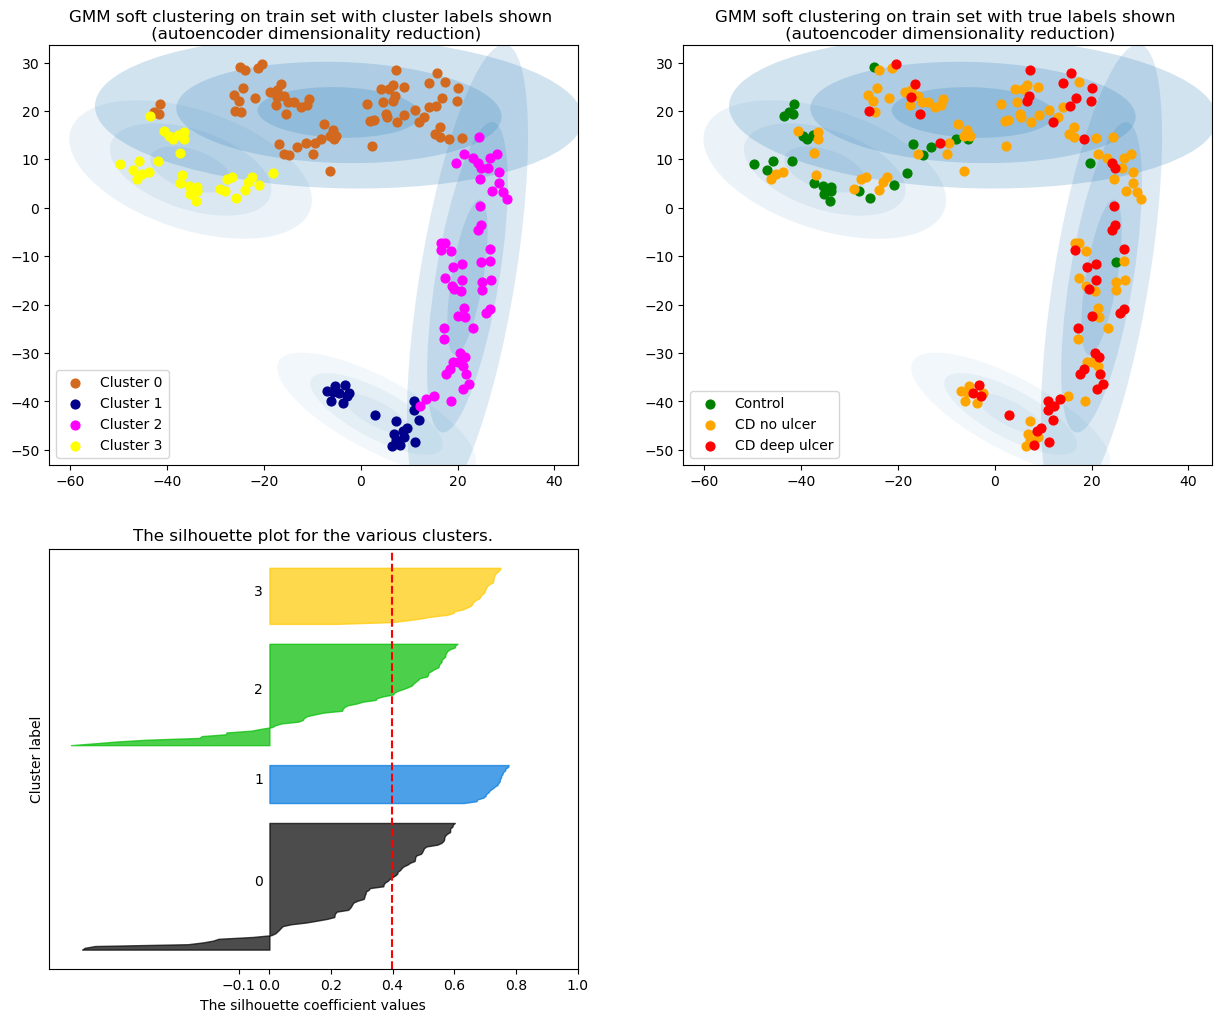

The average silhouette_score is : 0.3990782


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 20


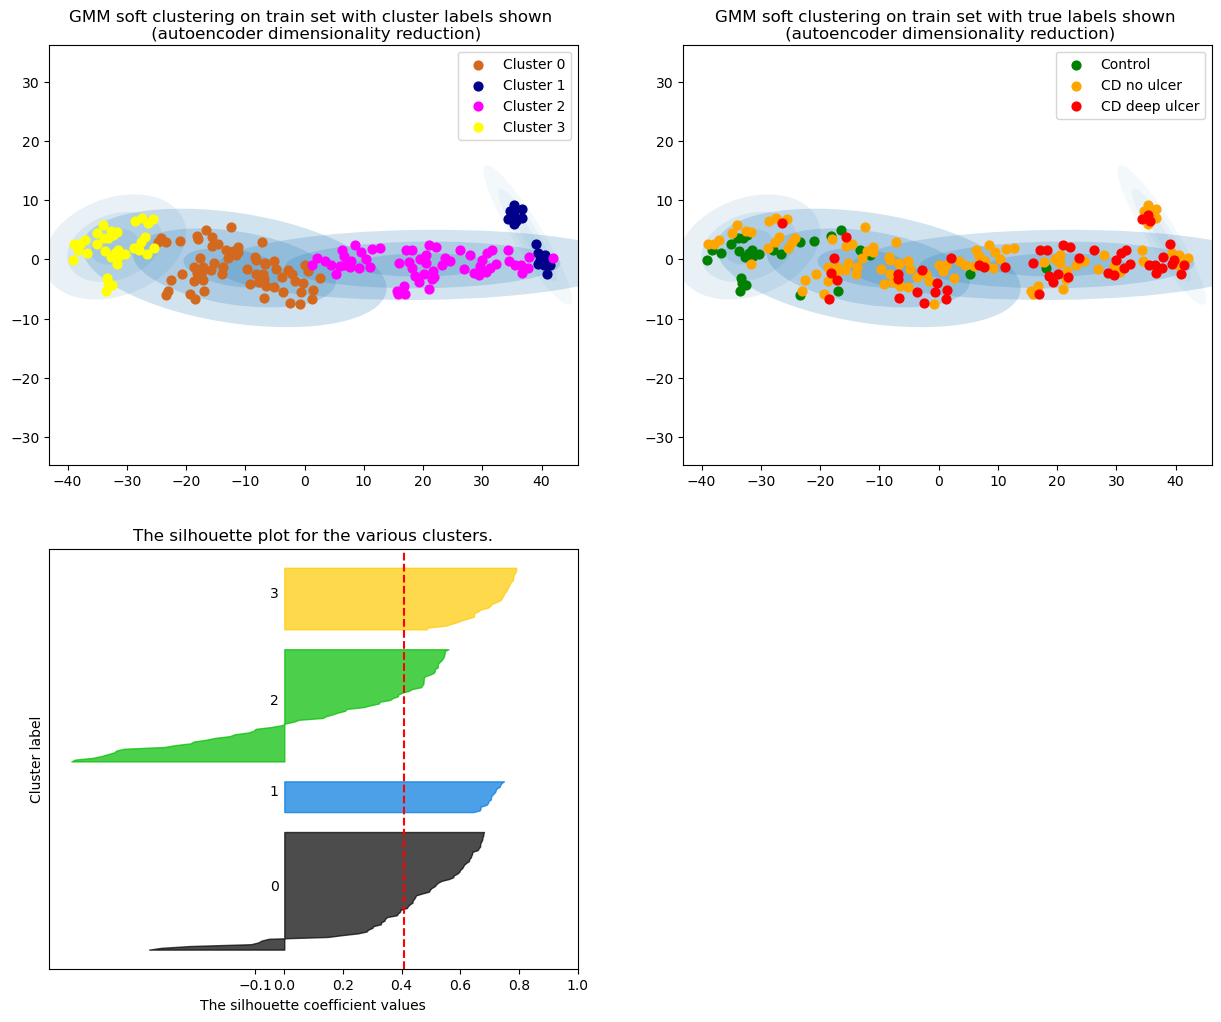

The average silhouette_score is : 0.4076123


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 24


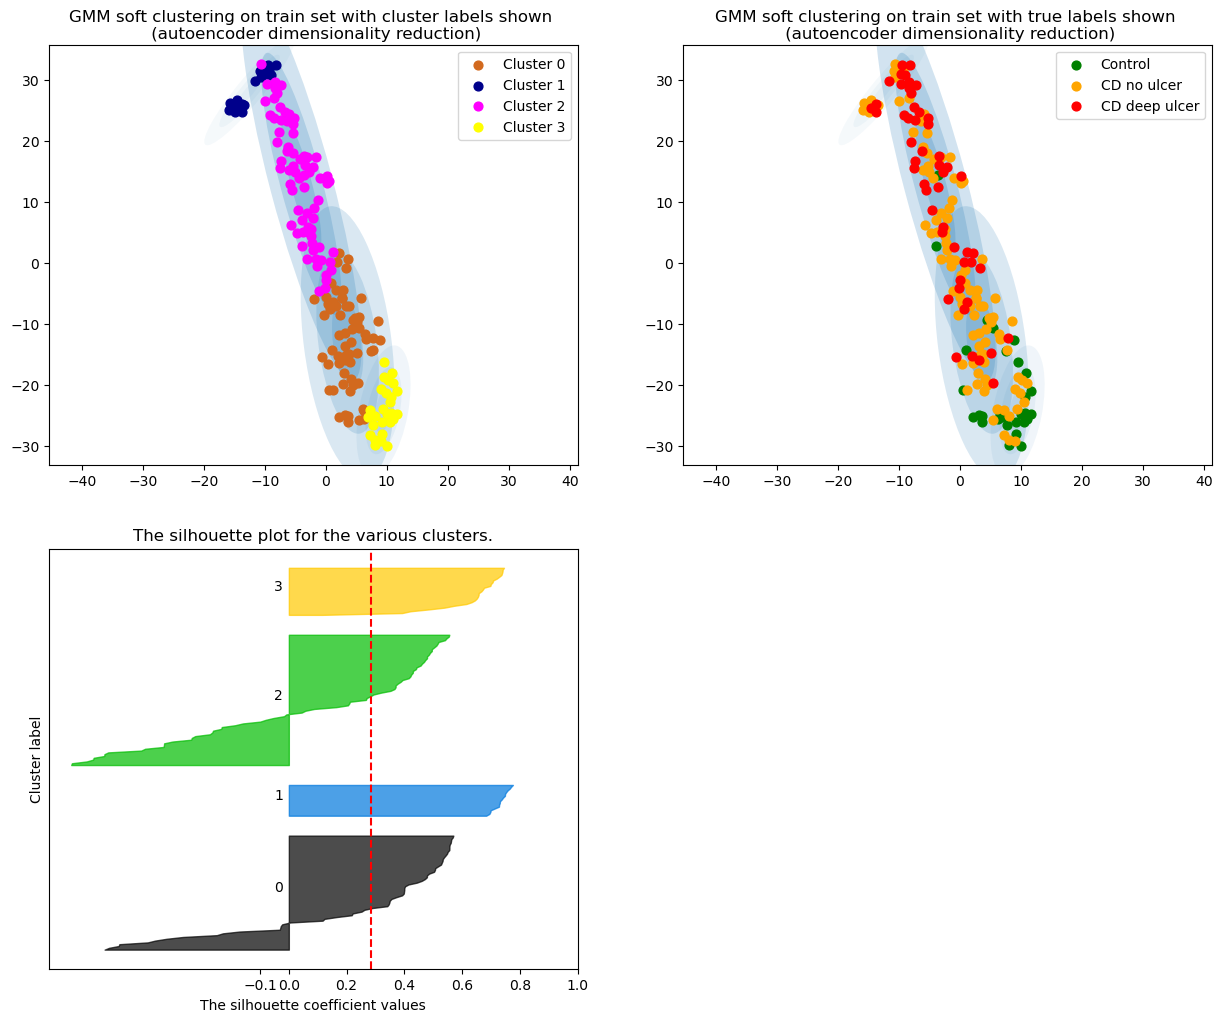

The average silhouette_score is : 0.2860834


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 50


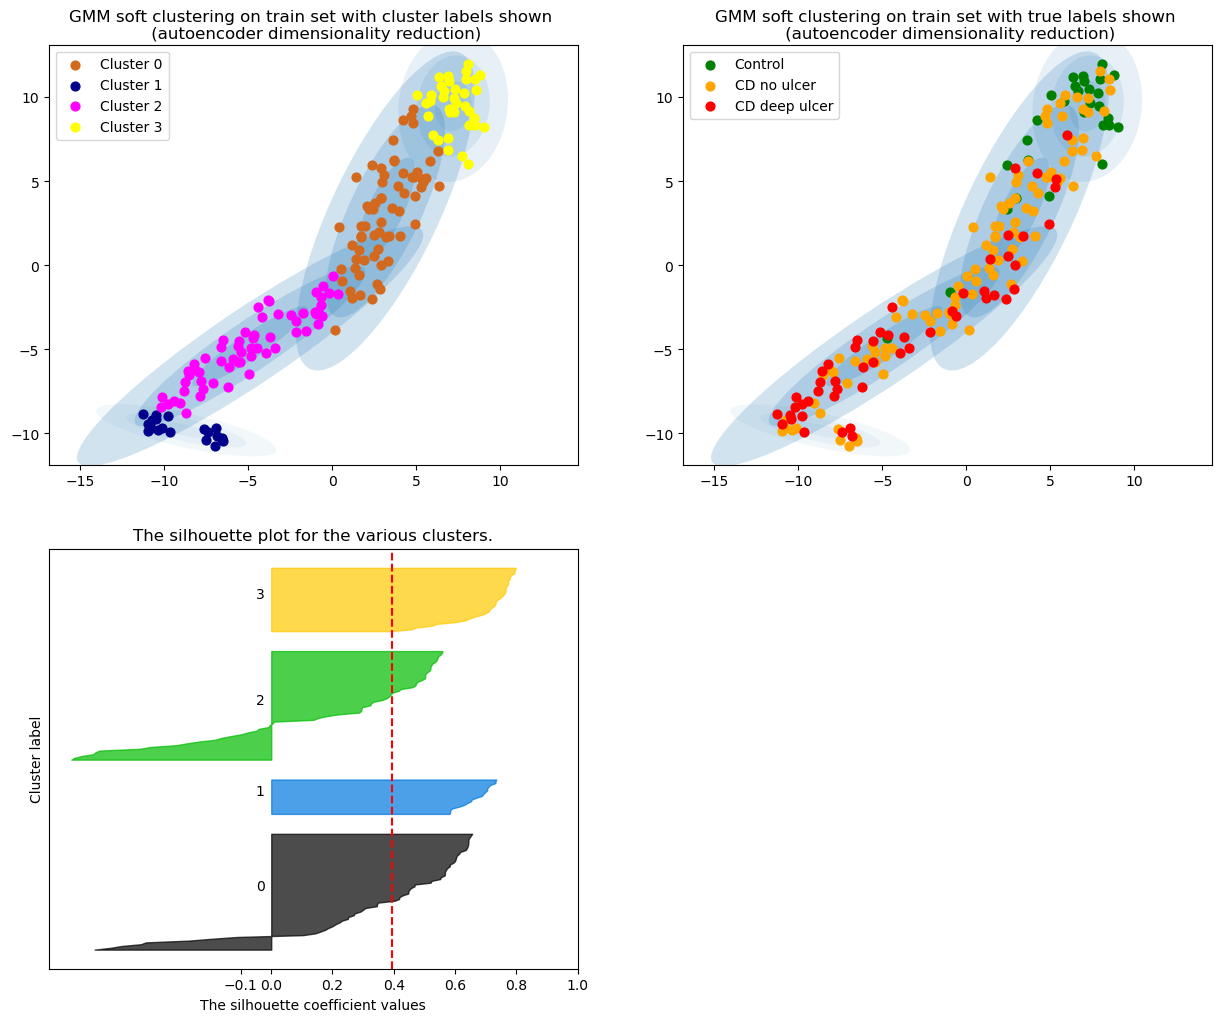

The average silhouette_score is : 0.39503098


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 70


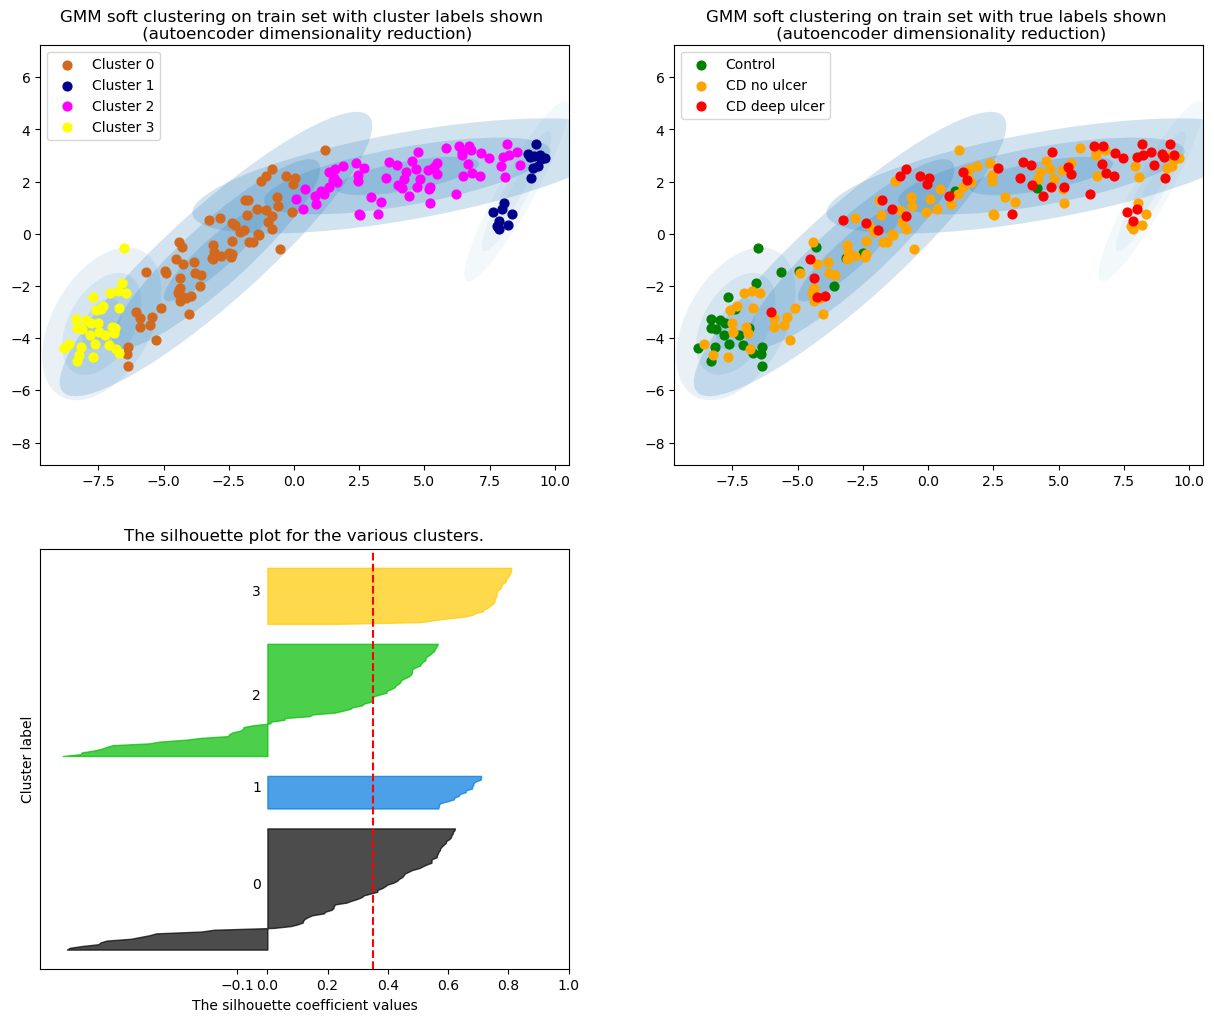

The average silhouette_score is : 0.35176048


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 100


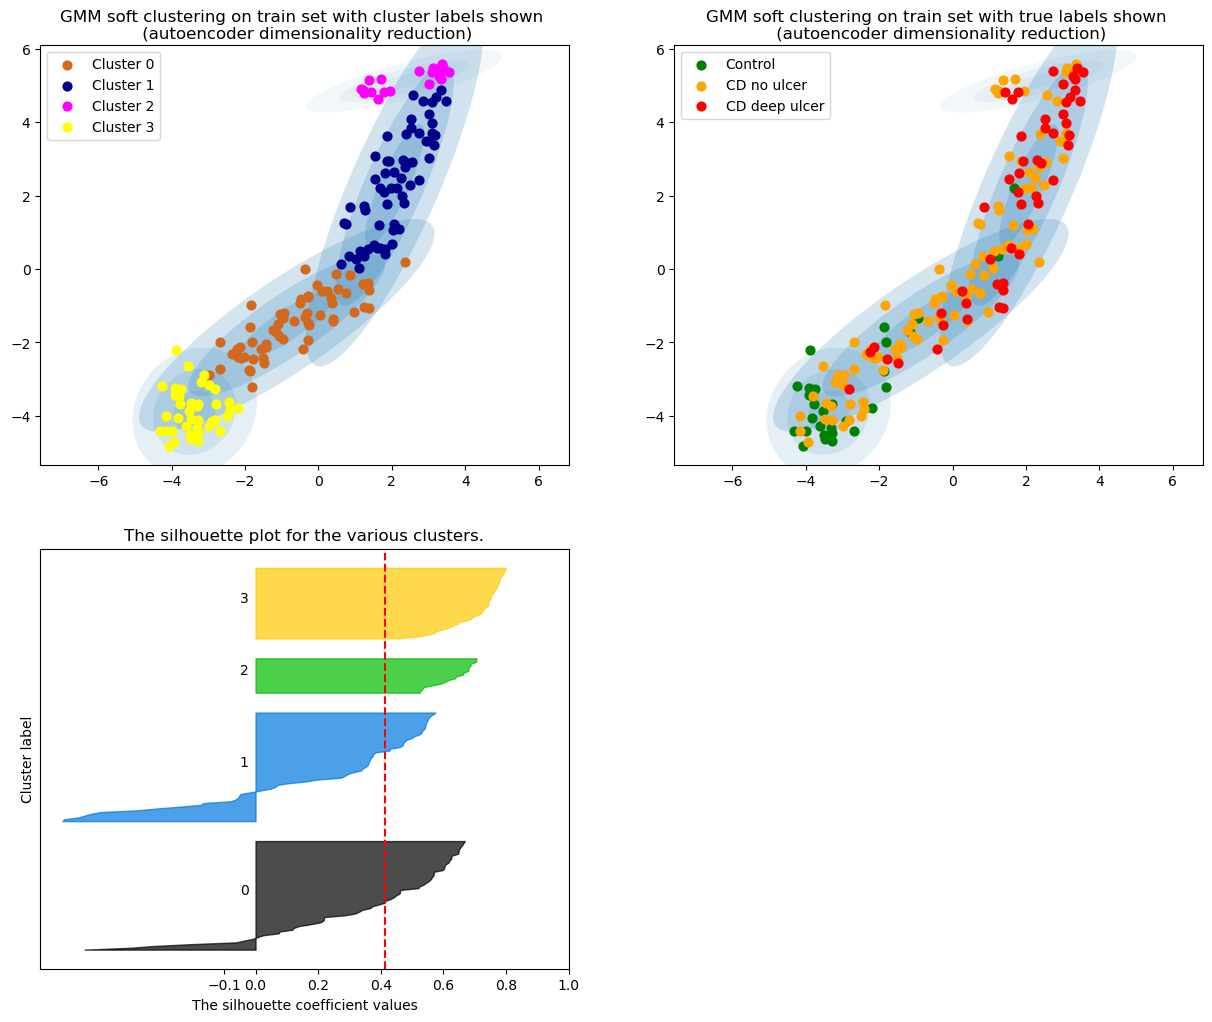

The average silhouette_score is : 0.4144919


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 150


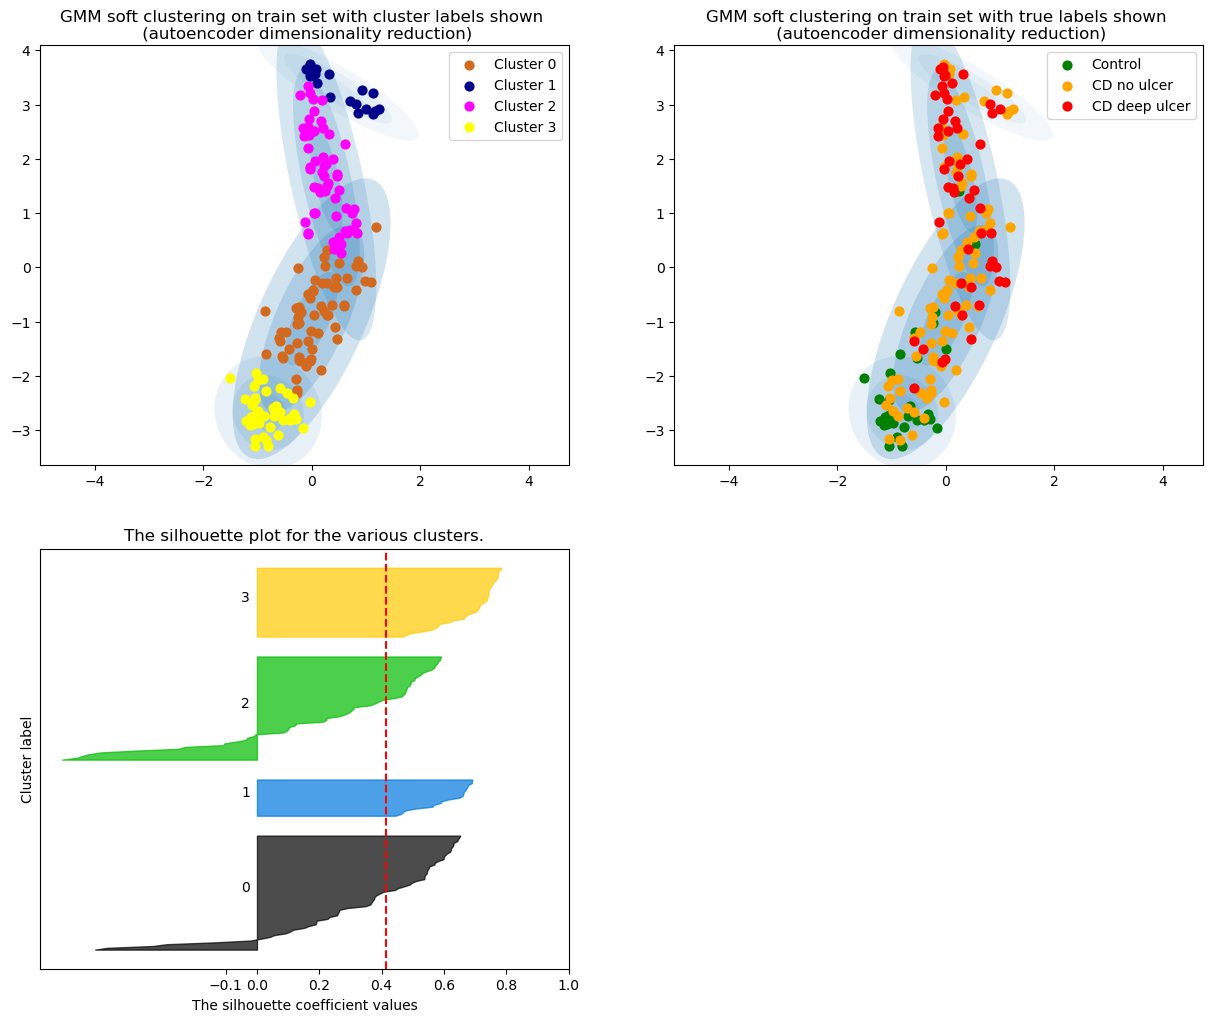

The average silhouette_score is : 0.41243324


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 200


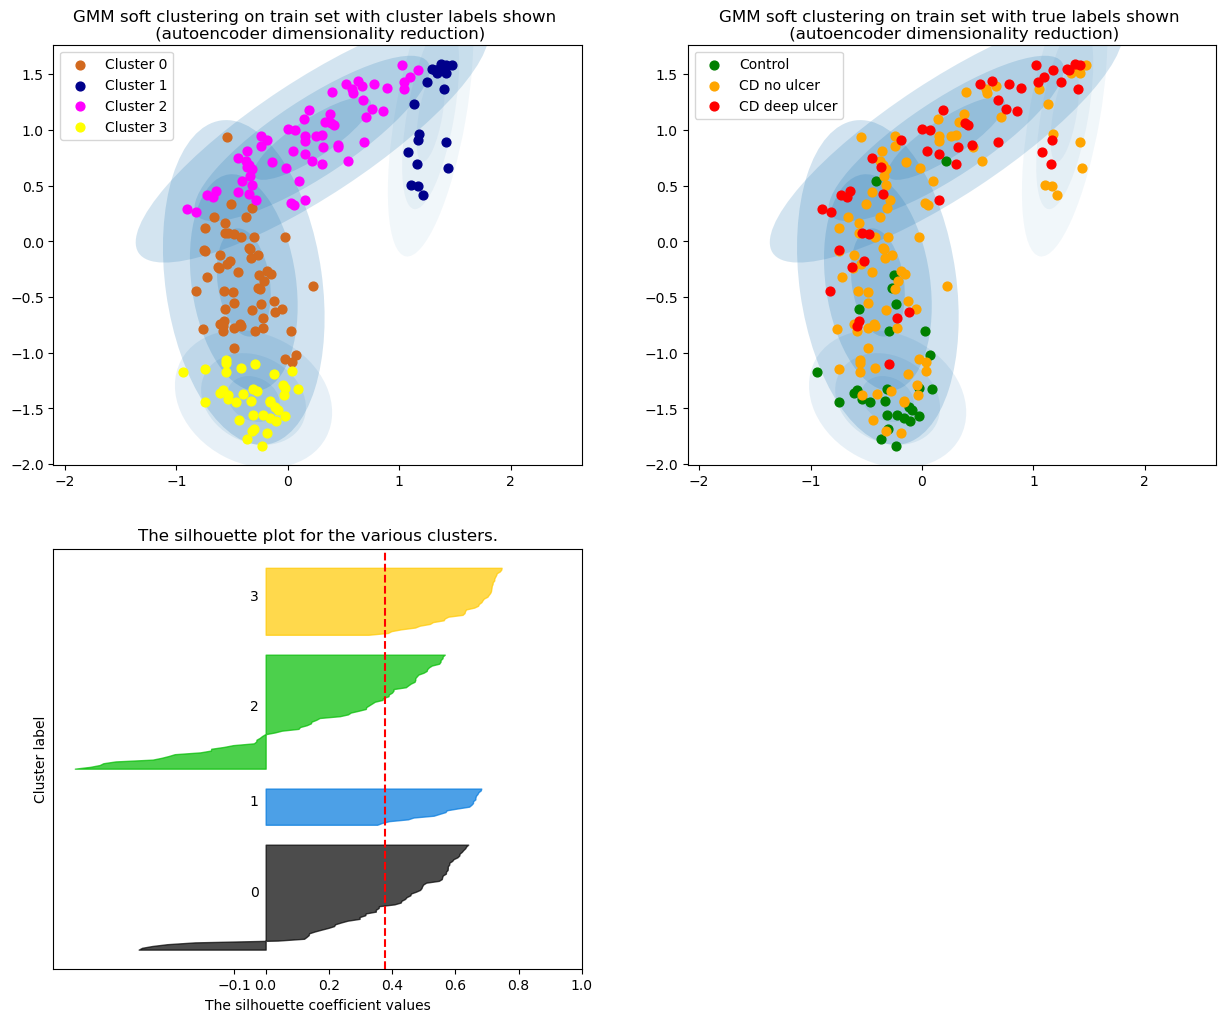

The average silhouette_score is : 0.3786658


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 250


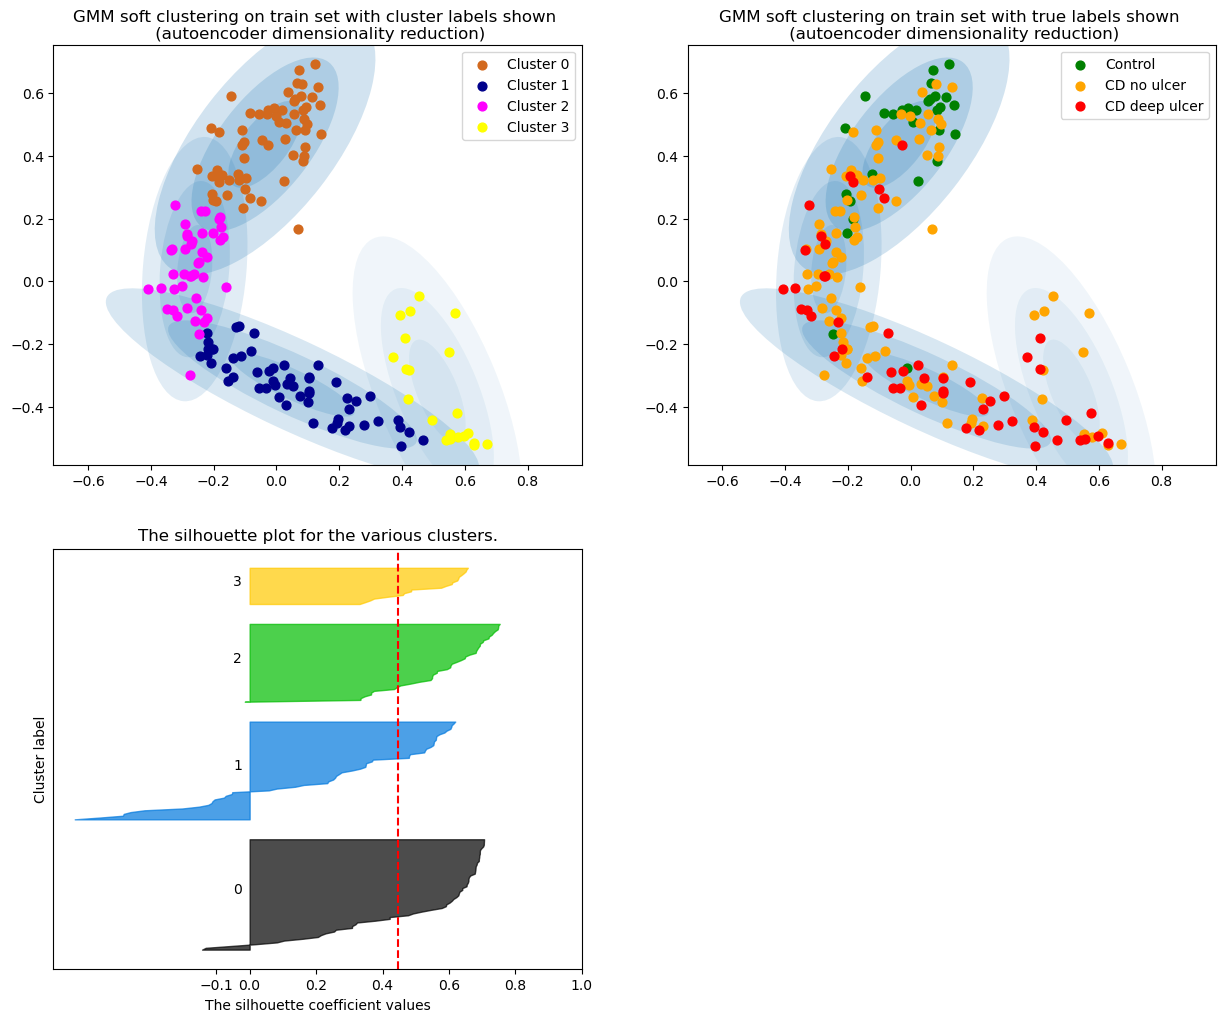

The average silhouette_score is : 0.44602388


In [57]:
# perplexities = [10, 20, 50, 70]
perplexities = [10, 20, 50, 70, 100, 150, 200, 250]
# perplexity = 24
for perplexity in perplexities:
    gmm_ae, X_train_ae, X_test_ae = fit_gmm(full_ae_dataset, perplexity, num_c)
    print("Perplexity =",perplexity)
    plot_gmm(gmm_ae, X_train_ae, train_disease_labels, "autoencoder", num_c=num_c, plot_sil=True)

### Testing

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


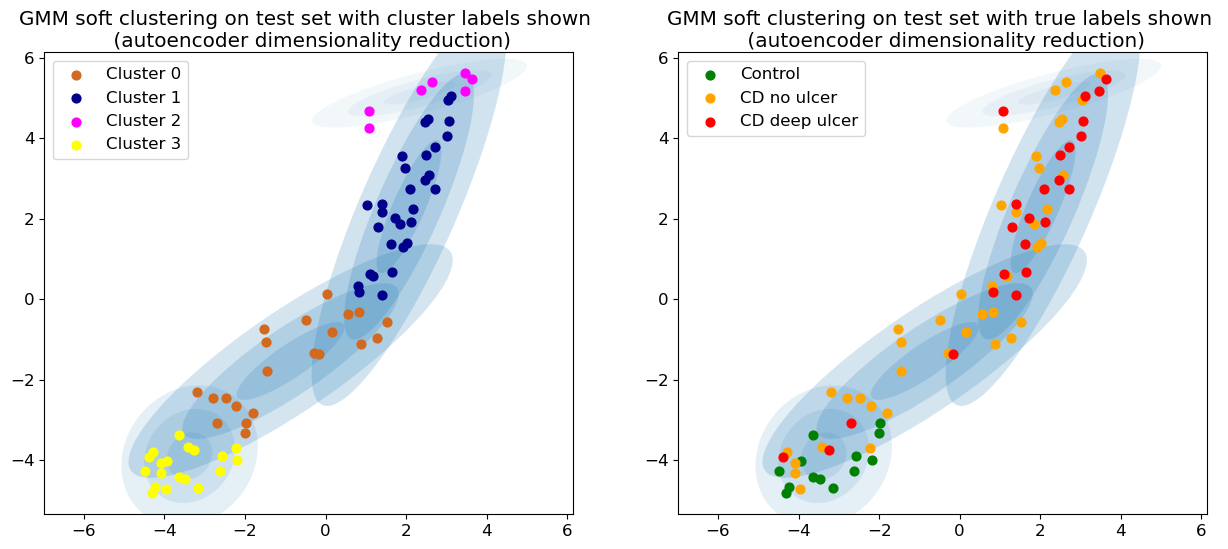

In [127]:
perplexity = 100
gmm_ae, X_train_ae, X_test_ae = fit_gmm(full_ae_dataset, perplexity, num_c)
gmm_labels_ae = plot_gmm(gmm_ae, X_test_ae, test_disease_labels, "autoencoder", num_c=num_c, test=True)

In [61]:
# np.where(X_test_ae >-30 )
# and X_test_ae[0] <-20
# (X_test_ae > -30 && X_test_ae < -20).all()
# y.logical_and(a, b)
# (X_test_ae[:,0] > -30) and (X_test_ae[:,1] < -20)
# arr = np.logical_and(X_test_ae[:,0] < -20, X_test_ae[:,1] < -12, X_test_ae[:,1] > -20)
# np.where(arr)

(array([], dtype=int64),)

In [62]:
# X_test_ae[18,:]

array([3.02093 , 4.051237], dtype=float32)

## Process GMM cluster models

In [65]:
import scipy.stats
from scipy.stats import multivariate_normal


In [66]:
# vis
# x, y = np.mgrid[0:30:.01, 0:30:.01]
# pos = np.dstack((x, y))
# fig2 = plt.figure()
# ax2 = fig2.add_subplot(111)
# # for i in range(2):
# ax2.contourf(x, y, comps[0].pdf(pos))
# ax2.contourf(x, y, comps[2].pdf(pos))

In [67]:
def get_amount_matrix_gmm(gmm, X_train, train_disease_labels):
    mu, covar, w = gmm.means_, gmm.covariances_, gmm.weights_
    # print("means:",mu)
    # print("covariances_:",covar)
    # print("weights_:",w)
    
    comps = [multivariate_normal(mu[i], covar[i]) for i in range(num_c)]
    
    # make matrix to record amount of each class in each mixture component
    amounts = np.zeros((3, num_c))
    
    
    classes = ["control", "CD_no_ulcer", "CD_deep_ulcer"]
    for c, cls in enumerate(classes):
        for i, comp in enumerate(comps): # add up contributions for each component
            weight = w[i]
            pts = X_train[train_disease_labels==c]
            curr_sum = np.sum(comp.pdf(pts)) * weight
            amounts[c][i] = curr_sum
    print(amounts)
    #                cluster 0, cluster 1, cluster 2, cluster 3
    # control 
    # CD no ulcer
    # CD deep ulcer
    
    return amounts


def sum_to_one(vals): 
#     print(t, u)
    for i in range(vals.shape[0]):
        row = vals[i,:]
        vals[i,:] = row / row.sum()
    
    return vals


In [68]:
def get_class_probs(X_test, gmm, assignments, couple):
    clus_probs = sum_to_one(gmm.predict_proba(X_test))
    print("clus_probs:",clus_probs)
    num_classes = 3
    
    arr = np.zeros((X_test.shape[0], num_classes))
    for c in range(num_classes):
        if assignments[c] == couple:
            arr[:,c] = np.max(clus_probs[:,couple], axis=1)
        else:
            cluster = assignments[c][0]
            arr[:,c] = clus_probs[:,cluster]
    arr = sum_to_one(arr)
            
    return np.argmax(arr, axis=1), arr

In [69]:
# gmm_prediction_ae(x_test_scaled)

In [70]:
# gmm_prediction_ae(x_test_scaled.iloc[[41],:])

In [71]:
def final_gmm_model_get_clusters(gmm, X_train, X_test, train_disease_labels):
    # process
    amounts = get_amount_matrix_gmm(gmm, X_train, train_disease_labels)
    assignments, couple = process_clusters(amounts, X_train, num_c)
    # retrieve clusters
#     gmm_labels = gmm.predict(X_test)
#     test_set_clusters = get_final_clusters(assignments, couple, gmm_labels)
    test_set_clusters, probs = get_class_probs(X_test, gmm, assignments, couple)
#     print(test_set_clusters)
#     print(probs)
    
    return test_set_clusters, probs



### Post-processed GMM models on test set

In [72]:
# gmm_labels_list = [gmm_labels_ae, gmm_labels_pca]
gmm_models_list = [gmm_ae, gmm_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]


In [73]:
# X_test_ae

C:\Users\shard\AppData\Local\Temp\ipykernel_27428\901889117.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\901889117.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_27428\1104872636.py:21: Matp

autoencoder
[[3.37408395e-01 9.45690775e-02 4.40535880e-56 9.75290766e-01]
 [2.02427782e+00 1.41158825e+00 4.71166218e-01 9.09952738e-01]
 [5.57510744e-01 1.21345169e+00 3.71776719e-01 4.13056086e-02]]
initial cls assignments: [3 0 1]
clus_probs: [[5.43215152e-002 4.70160068e-018 0.00000000e+000 9.45678485e-001]
 [8.67539154e-001 7.76218018e-012 2.54333199e-292 1.32460846e-001]
 [1.70649344e-020 3.25231014e-001 6.74768986e-001 2.26051721e-079]
 [6.30815155e-001 3.69184845e-001 3.28650493e-187 3.57551430e-018]
 [9.95412042e-001 4.58795762e-003 8.78274902e-178 1.97180674e-011]
 [1.06728302e-001 3.99788392e-020 0.00000000e+000 8.93271698e-001]
 [4.33271765e-017 4.79088789e-001 5.20911211e-001 1.77622406e-074]
 [8.88949106e-006 9.99991111e-001 3.91721063e-045 4.07979546e-047]
 [9.27305127e-011 1.00000000e+000 2.82239958e-015 9.23340109e-056]
 [9.10649781e-003 3.96391782e-014 0.00000000e+000 9.90893502e-001]
 [4.26246530e-007 9.99999574e-001 1.56291393e-039 3.66856577e-043]
 [9.86313941e-00

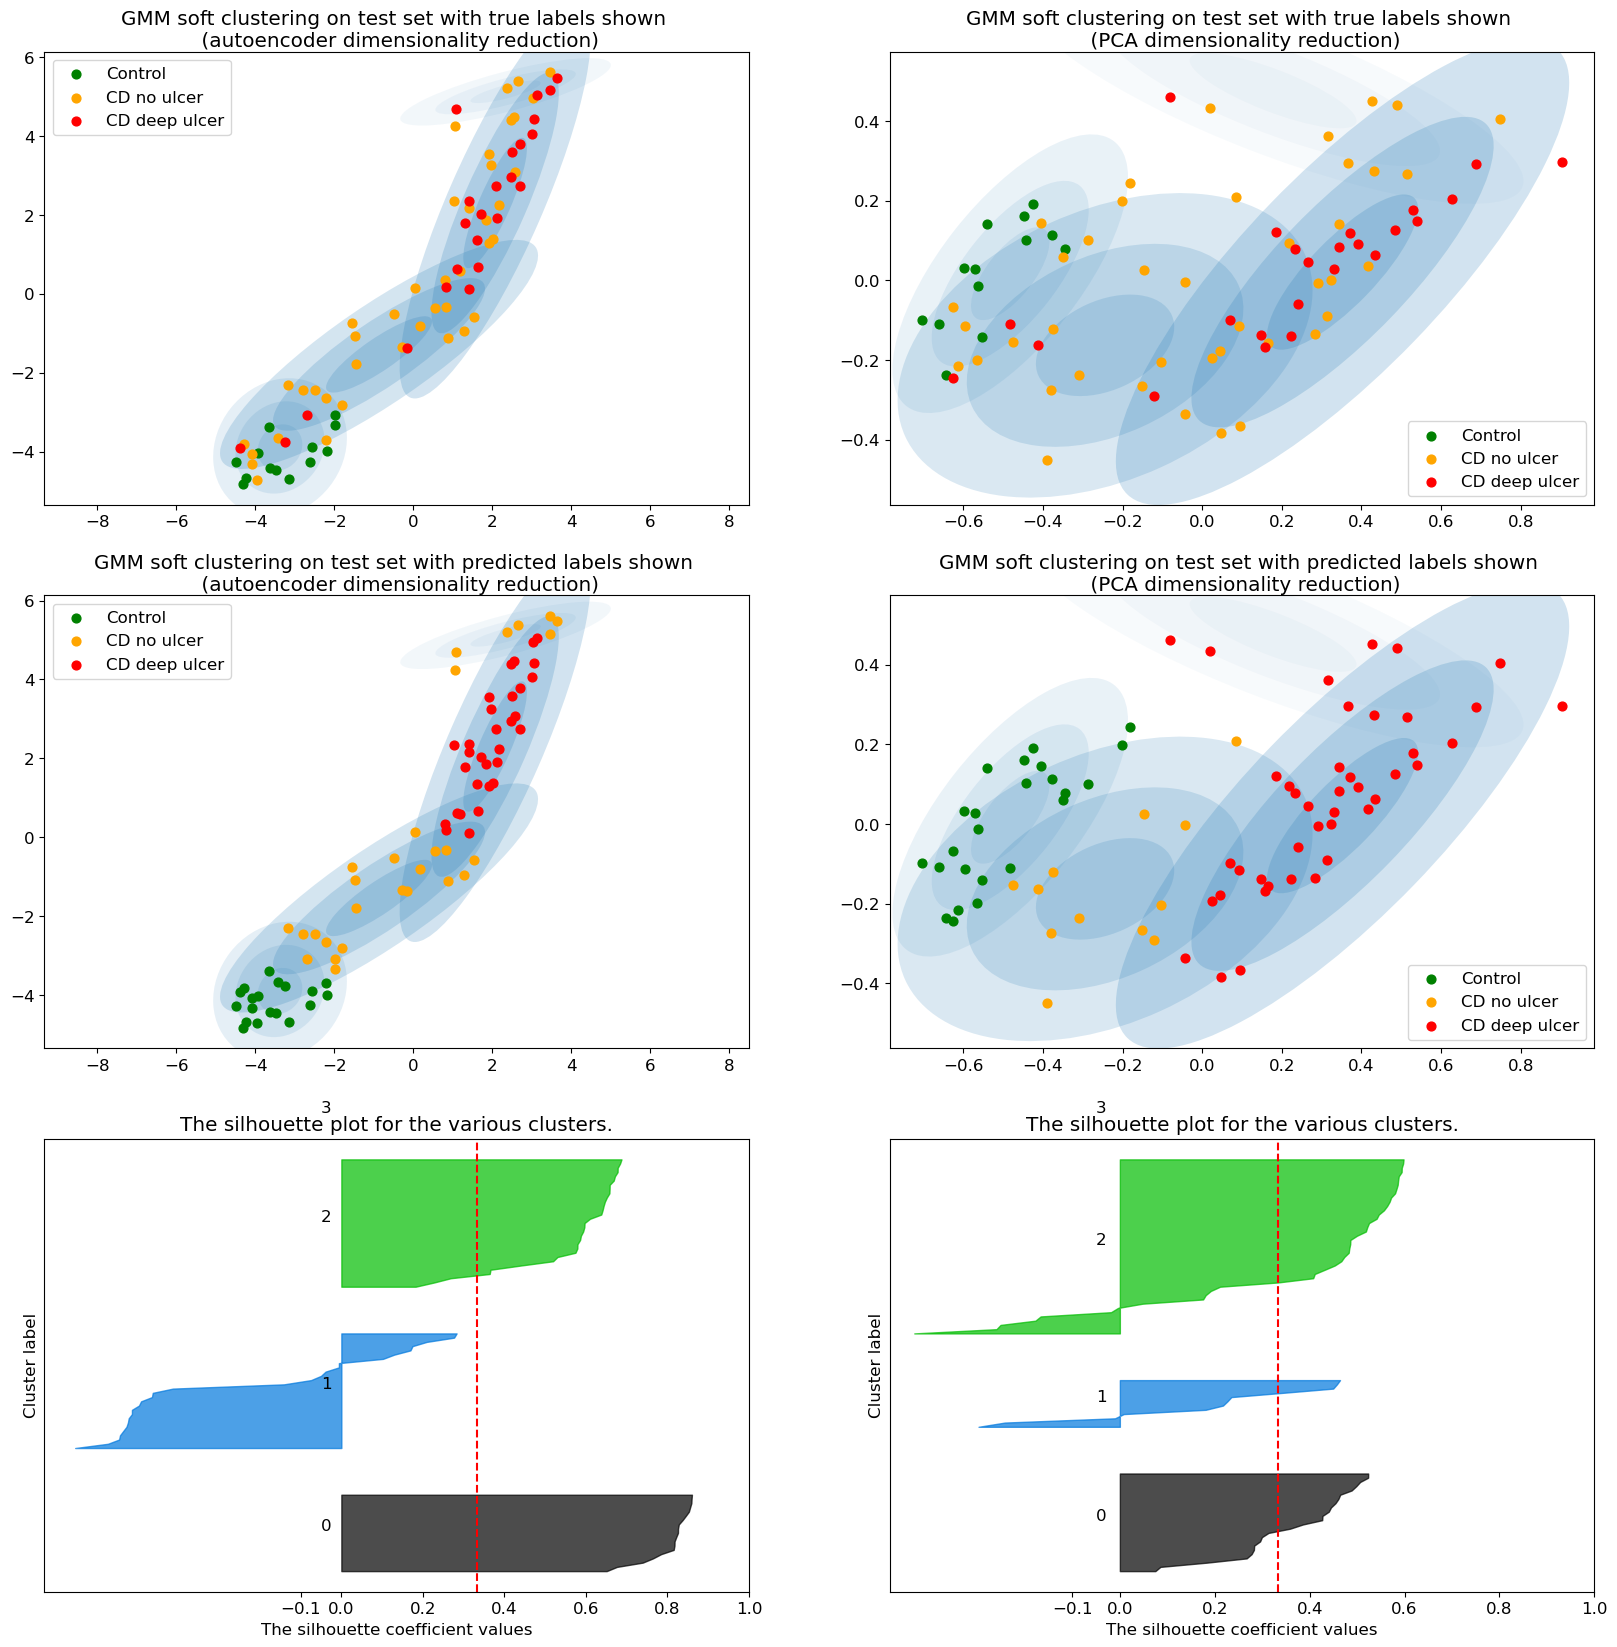

Autoencoder: average silhouette score = 0.3339695
PCA: average silhouette score = 0.3323274


In [74]:
plt.rcParams.update({'font.size': 12})

def plot_final_gmm_models(gmm_models_list, test_disease_labels, train_set_list, test_set_list, num_c):
#         left = -8
#         right = 8
#         ax.set_xlim(left, right)
#         ax.set_ylim(left, right)
        
        
#         if i==0:
#             num_clusters = num_c
#             cluster_names = ["Cluster " + str(i) for i in range(num_clusters)]
#             colours = ["chocolate", "darkblue", "magenta", "yellow", "blue"]
#             ax.set_title("GMM soft clustering on " + dset + " set with cluster labels shown \n (" + reduction + " dimensionality reduction)",
#                          wrap=True)
#         else:
#     fig, ax = plt.subplots()
    (fig, subplots) = plt.subplots(3, 2, figsize=(20, 20))
    reduction = ["autoencoder", "PCA"]
    final_clusters_lst = []
    final_probs_lst = []
    label_type = ["true","predicted"]
    for t in range(2):
        label = label_type[t]
        for i in range(len(gmm_models_list)):
    #         print(i)
            ax = subplots[t][i]
            gmm = gmm_models_list[i]
    #         gmm_labels = gmm_labels_list[i]
            X_train = train_set_list[i]
            X_test = test_set_list[i]
    #         amounts = get_amount_matrix_gmm(gmm, X_train, train_disease_labels)
    #         assignments, couple = process_clusters(amounts, X_train, num_c)
    #         test_set_clusters = get_final_clusters(assignments, couple, gmm_labels)
            if t > 0:
                print(reduction[i])
                test_set_clusters, probs = final_gmm_model_get_clusters(gmm, X_train, X_test, train_disease_labels)
                final_clusters_lst.append(test_set_clusters)
                final_probs_lst.append(probs)
            else:
                test_set_clusters = test_disease_labels




            reduc = reduction[i]
            num_clusters = 3
            cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
            colours = ["green", "orange", "red"]
            ax.set_title("GMM soft clustering on test set with "+ label +" labels shown \n (" + reduc + " dimensionality reduction)",
                        wrap=True)

            for i in range(num_clusters):
                ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 

            ax.axis('equal')


            w_factor = 0.2 / gmm.weights_.max()
            for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
                draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)
            ax.legend()

    s_avgs = []
    for j in range(2):
        ax = subplots[2][j]
        X_test = test_set_list[j]
        test_clusters = final_clusters_lst[j]

        silhouette_avg, sample_silhouette_values = compute_silh_scores(X_test, test_clusters)
        s_avgs.append(silhouette_avg)
        plot_silhouette(num_c, test_clusters, sample_silhouette_values, silhouette_avg, ax)
        
        
    plt.show()

    print("Autoencoder: average silhouette score =",s_avgs[0])
    print("PCA: average silhouette score =",s_avgs[1])

    return final_clusters_lst, final_probs_lst
        
final_clusters_lst, final_probs_lst = plot_final_gmm_models(gmm_models_list, test_disease_labels, train_set_list, test_set_list, num_c)

3rd graph - substructure clustering processed in combination with true labels to obtain final 3 cluster clustering; model can now be easily coupled to shap - why better than simple k=3 clustering

## Evaluation of final clustering models

In [75]:
final_clusters_gmm_ae, final_clusters_gmm_pca = final_clusters_lst
final_probs_gmm_ae, final_probs_gmm_pca = final_probs_lst

In [77]:
from sklearn.metrics import accuracy_score, f1_score

## CD vs control (binary classification)

### GMM

In [79]:
test_disease_labels_binary = test_disease_labels.copy()
test_disease_labels_binary[test_disease_labels_binary==2] = 1
test_disease_labels_binary

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [80]:
final_clusters_gmm_ae_binary = final_clusters_gmm_ae.copy()
final_clusters_gmm_ae_binary[final_clusters_gmm_ae_binary==2] = 1
final_clusters_gmm_ae_binary

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64)

In [81]:
final_clusters_gmm_pca_binary = final_clusters_gmm_pca.copy()
final_clusters_gmm_pca_binary[final_clusters_gmm_pca_binary==2] = 1
final_clusters_gmm_pca_binary

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1], dtype=int64)

In [82]:
# AE
accuracy_score(test_disease_labels_binary, final_clusters_gmm_ae_binary)

0.8717948717948718

In [83]:
f1_score(test_disease_labels_binary, final_clusters_gmm_ae_binary)

0.9193548387096773

In [84]:
# PCA
accuracy_score(test_disease_labels_binary, final_clusters_gmm_pca_binary)

0.8589743589743589

In [85]:
f1_score(test_disease_labels_binary, final_clusters_gmm_pca_binary)

0.907563025210084

### KMeans

In [86]:
final_clusters_km_ae_binary = final_clusters_ae.copy()
final_clusters_km_ae_binary[final_clusters_km_ae_binary==2] = 1
final_clusters_km_pca_binary = final_clusters_pca.copy()
final_clusters_km_pca_binary[final_clusters_km_pca_binary==2] = 1

In [87]:
# AE
accuracy_score(test_disease_labels_binary, final_clusters_km_ae_binary)

0.8589743589743589

In [88]:
f1_score(test_disease_labels_binary, final_clusters_km_ae_binary)

0.907563025210084

In [89]:
# PCA
accuracy_score(test_disease_labels_binary, final_clusters_km_pca_binary)

0.8461538461538461

In [90]:
f1_score(test_disease_labels_binary, final_clusters_km_pca_binary)

0.8983050847457628

## Control, CD no ulcer, CD deep ulcer (multiclass)

### GMM

In [91]:
accuracy = accuracy_score(test_disease_labels, final_clusters_gmm_ae)
accuracy

0.6282051282051282

In [92]:
f1_score(test_disease_labels, final_clusters_gmm_ae, average='weighted')

0.6247485304550522

In [93]:
accuracy = accuracy_score(test_disease_labels, final_clusters_gmm_pca)
accuracy

0.5512820512820513

In [94]:
f1_score(test_disease_labels, final_clusters_gmm_pca, average='weighted')

0.5019524076127849

### KMeans

In [95]:
km_ae_accuracy = accuracy_score(test_disease_labels, final_clusters_ae)
km_ae_accuracy

0.6025641025641025

In [96]:
f1_score(test_disease_labels, final_clusters_ae, average='weighted')

0.5942942942942944

In [97]:
km_pca_accuracy = accuracy_score(test_disease_labels, final_clusters_pca)
km_pca_accuracy

0.6025641025641025

In [98]:
f1_score(test_disease_labels, final_clusters_pca, average='weighted')

0.594631068315279

## Find class probabilities from cluster model

In [99]:
def get_probs(point, comps, assignments, w):
    probs = []
    for elem in assignments:
        p_cand = []
        for cluster in elem:
            p = comps[cluster].pdf(point) * w[cluster]
#             print("p:",p)
            p_cand.append(p)
#         print(p_cand)
        p = max(p_cand)
        probs.append(p)
        
    return probs

def sum_to_one(vals): 
#     print(t, u)
    for i in range(vals.shape[0]):
        row = vals[i,:]
        vals[i,:] = row / row.sum()
    
    return vals




In [100]:
def get_proba(gmm, assignments, X_test):
    # GMM mixture component distributions
    mu, covar, w = gmm.means_, gmm.covariances_, gmm.weights_
    # print("means:",mu)
    # print("covariances_:",covar)
    # print("weights_:",w)
    comps = [multivariate_normal(mu[i], covar[i]) for i in range(num_c)]

    X_test = X_test.tolist()
    new_list = []
    for point in X_test:
        probs = get_probs(point, comps, assignments, gmm.weights_)
#         print(probs)
        new_list.append(probs)
    pdf_vals = np.asarray(new_list)
#     pdf_vals = -np.log(pdf_vals)
    
#     plt.figure()
#     xr = np.arange(len(pdf_vals))
#     plt.scatter(xr, pdf_vals[:,0])
#     plt.scatter(xr, pdf_vals[:,1])
#     plt.scatter(xr, pdf_vals[:,2])
#     plt.show()

    # rescale so adds up to 1
#     proba = pdf_vals.copy()
#     for i in range(len(proba)):
#         row = proba[i,:]
#         rescaled = softmax(row)

#         proba[i,:] = rescaled
    proba = pdf_vals
    
    return proba

In [101]:
# amounts = get_amount_matrix_gmm(gmm_ae, X_train_ae, train_disease_labels)
# assignments_ae, couple_ae = process_clusters(amounts, X_train_ae, num_c)
# assignments_ae

In [102]:
# amounts = get_amount_matrix_gmm(gmm_pca, X_train_pca, train_disease_labels)
# assignments_pca, couple_pca = process_clusters(amounts, X_train_pca, num_c)
# assignments_pca

In [103]:
# gmm = gmm_ae
# assignments = assignments_ae

In [104]:
# gmm_ae_prob = get_proba(gmm_ae, assignments_ae, X_test_ae)

In [105]:
# gmm_pca_prob = get_proba(gmm_pca, assignments_pca, X_test_pca)

## Retrieving probabilities across classes using GMM model

In [106]:
def save_gmm(gmm, reduction_type):
    path = "data/models/"
    # save to file
    gmm_name = path + 'gmm_' + reduction_type
    np.save(gmm_name + '_weights', gmm.weights_, allow_pickle=False)
#     print('Saved ' + gmm_name + '_weights.npy')
    np.save(gmm_name + '_means', gmm.means_, allow_pickle=False)
    np.save(gmm_name + '_covariances', gmm.covariances_, allow_pickle=False)
    
def load_gmm(gmm_name):
    # reload
    means = np.load(gmm_name + '_means.npy')
    covar = np.load(gmm_name + '_covariances.npy')
    loaded_gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
    loaded_gmm.means_ = means
    loaded_gmm.covariances_ = covar
    
    return loaded_gmm


In [107]:
full_pca_dataset.iloc[split_pt:,:] = full_pca_dataset.iloc[split_pt:,:]
full_pca_dataset

0         1         2         3         4         5   \
Patient_ID                                                                      
55_control        -1.442102  0.423583 -0.771329  1.259458 -0.649900  0.528059   
168_CD_plain       0.391899 -0.779308  0.090023  0.396271 -0.589533 -0.446545   
72_control        -2.578385 -0.278593  0.888523  1.465165  0.252230  0.456526   
120_control        0.447236 -1.043545 -0.527135 -0.335315  0.451502 -0.135029   
258_CD_plain      -0.987156  0.075976 -0.810296 -0.325627  0.190557 -0.418370   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain      -0.551862  1.229653 -0.659463  0.367187 -0.690286 -0.194535   
279_CD_plain       3.329993  1.245848  1.981033 -0.304588  0.442937  0.047697   
179_CD_plain      -1.176429  0.735936 -1.163104 -0.267260 -0.272239 -0.246357   
70_CD_deep_ulcer   1.251434  0.174954 -0.288986  0.507840 -0.935215  0.320637   
256_CD_deep_ulcer  0.235697 -0.384259  0.042556 -0.706278 -0.442257 -0.350391   

                         6         7         8         9   ...        22  \
Patient_ID                                                 ...             
55_control        -0.470250  0.878353  0.827023 -0.342229  ...  0.107015   
168_CD_plain       0.371764  0.265636  0.022147 -0.104053  ...  0.008378   
72_control         0.056637 -0.331665 -0.217561 -0.181177  ...  0.218739   
120_control       -0.021976 -0.186347  0.129778 -0.154341  ... -0.114079   
258_CD_plain      -0.346951  0.060615  0.091755 -0.025873  ...  0.058848   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.293040  0.186499 -0.664832  0.312422  ... -0.221131   
279_CD_plain      -0.967575  0.631767 -0.262619 -0.058613  ... -0.018253   
179_CD_plain       0.153212  0.113274 -0.050833  0.168465  ...  0.127032   
70_CD_deep_ulcer   0.231946 -0.237319  0.073773  0.231166  ... -0.135359   
256_CD_deep_ulcer  0.125725  0.283907 -0.001375  0.014056  ... -0.027111   

                         23        24        25        26        27        28  \
Patient_ID                                                                      
55_control        -0.368678  0.159819  0.048672  0.034202  0.580354  0.339282   
168_CD_plain      -0.197563 -0.144208 -0.394304  0.021647 -0.560333  0.057313   
72_control        -0.121655 -0.007930 -0.314677  0.217659 -0.089813  0.123012   
120_control        0.114948  0.052603 -0.259390 -0.002918  0.297557 -0.173319   
258_CD_plain       0.071869 -0.004576 -0.013813 -0.317813 -0.029274  0.018820   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain      -0.151494 -0.101613  0.132019  0.243812 -0.190966  0.123704   
279_CD_plain      -0.223991 -0.254559 -0.037459 -0.390738 -0.061000  0.235414   
179_CD_plain       0.081638  0.182571 -0.003060 -0.208766 -0.176130  0.044101   
70_CD_deep_ulcer  -0.029732 -0.013800 -0.096897  0.145837 -0.081507 -0.024819   
256_CD_deep_ulcer  0.391081  0.245489  0.079577 -0.222733  0.100795 -0.044668   

                         29        30        31  
Patient_ID                                       
55_control         0.179175  0.152994  0.016017  
168_CD_plain      -0.022891 -0.017347 -0.354982  
72_control        -0.183375 -0.352774  0.069533  
120_control       -0.124066 -0.018911  0.104921  
258_CD_plain       0.272456 -0.052392 -0.002692  
...                     ...       ...       ...  
107_CD_plain       0.297175 -0.010488 -0.083618  
279_CD_plain      -0.329411 -0.133009  0.504141  
179_CD_plain      -0.121416  0.139506 -0.211132  
70_CD_deep_ulcer   0.007137 -0.034567  0.063264  
256_CD_deep_ulcer -0.048754  0.190394 -0.013115  

[260 rows x 32 columns]

In [108]:
full_ds

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
55_control         0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain       0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control         0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control        0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain       0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                 ...             
55_control         1.000000  0.363133  0.374212  0.611161  ...  0.529274   
168_CD_plain       0.311962  0.251356  0.553554  0.441131  ...  0.485551   
72_control         0.648401  0.134017  0.200420  0.679453  ...  0.682864   
120_control        0.579519  0.248934  0.759250  0.755407  ...  0.760504   
258_CD_plain       0.370517  0.244987  0.445387  0.798000  ...  0.601023   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.273104   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.540150   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.561707   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.260826   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.598137   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
55_control               0.0        0.0  0.364776  0.465986  0.922559   
168_CD_plain             0.0        0.0  0.522378  0.578564  0.522145   
72_control               0.0        0.0  0.042221  0.025102  0.789751   
120_control              0.0        0.0  0.517359  0.672548  0.565864   
258_CD_plain             0.0        0.0  0.490289  0.858259  0.686037   
...                      ...        ...       ...       ...       ...   
107_CD_plain             0.0        0.0  0.511460  0.571813  0.718136   
279_CD_plain             0.0        0.0  0.967121  0.690670  0.586834   
179_CD_plain             0.0        0.0  0.532892  0.827410  0.584298   
70_CD_deep_ulcer         0.0        0.0  0.353435  0.470313  0.693233   
256_CD_deep_ulcer        0.0        0.0  0.550635  0.712620  0.543815   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
55_control         0.854193   0.224260  0.883418       0.0  
168_CD_plain       0.692076   0.021080  0.517763       0.0  
72_control         0.878183   0.048352  0.429987       0.0  
120_control        0.505961   0.021080  0.490510       0.0  
258_CD_plain       0.392018   0.021080  0.633386       0.0  
...                     ...        ...       ...       ...  
107_CD_plain       0.624635   0.021080  0.939056       0.0  
279_CD_plain       0.731743   0.021080  0.312015       0.0  
179_CD_plain       0.217127   0.195470  0.876301       0.0  
70_CD_deep_ulcer   0.466546   0.045757  0.799992       0.0  
256_CD_deep_ulcer  0.510634   0.021080  0.597887       0.0  

[260 rows x 220 columns]

In [109]:

def gmm_prediction_ae(x_test_scaled):
    # preprocessing

    full_dataset = full_ds.copy()
    split_pt = len(full_dataset) - len(x_test_scaled)
    full_dataset.iloc[split_pt:,:] = x_test_scaled

        
    # dim redction - autoencoder
    full_ae_dataset = ae_encode_dataset(full_dataset)
    
    # tsne
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=24,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_ae_dataset)
    X_test = X[split_pt:]
    
    path = "data/models/"
    filename_assignments = path + "autoencoder_assignments"
    filename_couple = path + "autoencoder_couple"
    load_gmm_name = path + "gmm_autoencoder"
    # load gmm model
    gmm = load_gmm(load_gmm_name)
    # load assignments
    with open(filename_assignments, "rb") as fp:   # Unpickling
        assignments = pickle.load(fp)
    with open(filename_couple, "rb") as fp:   # Unpickling
        couple = pickle.load(fp)
    _, probs = get_class_probs(X_test, gmm, assignments, couple)
    return probs

def gmm_model_get_prediction_ae(x_test_scaled):
    if len(x_test_scaled) <= len(full_ds):
        return gmm_prediction_ae(x_test_scaled)
    else:
        full_resp = np.empty((0,3))
        for i in range(0, len(x_test_scaled), len(full_ds)):
            end = i + len(full_ds)
            if end > len(x_test_scaled):
                end = len(x_test_scaled)
            next_resp = gmm_prediction_ae(x_test_scaled[i:end])
            full_resp = np.concatenate([full_resp, next_resp])
        return full_resp

In [110]:
def gmm_prediction_pca(x_test_scaled):
    # preprocessing
    full_dataset = full_ds.copy()
    split_pt = len(full_dataset) - len(x_test_scaled)
    full_dataset.iloc[split_pt:,:] = x_test_scaled
    
    # dim redction - PCA
    full_pca_dataset, _ = encode_pca(full_dataset)
    
    # tsne
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=24,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_pca_dataset)
    X_test = X[split_pt:]

    path = "data/models/"
    filename_assignments = path + "PCA_assignments"
    filename_couple = path + "PCA_couple"
    load_gmm_name = path + "gmm_PCA"
    # load gmm model
    gmm = load_gmm(load_gmm_name)
    # load assignments
    with open(filename_assignments, "rb") as fp:   # Unpickling
        assignments = pickle.load(fp)
    with open(filename_couple, "rb") as fp:   # Unpickling
        couple = pickle.load(fp)
    _, probs = get_class_probs(X_test, gmm, assignments, couple)
    return probs

def gmm_model_get_prediction_pca(x_test_scaled):
    if len(x_test_scaled) <= len(full_ds):
        return gmm_prediction_pca(x_test_scaled)
    else:
        full_resp = np.empty((0,3))
        for i in range(0, len(x_test_scaled), len(full_ds)):
            end = i + len(full_ds)
            if end > len(x_test_scaled):
                end = len(x_test_scaled)
            next_resp = gmm_prediction_pca(x_test_scaled[i:end])
            full_resp = np.concatenate([full_resp, next_resp])
        return full_resp

In [111]:
def final_gmm_model_get_prob(gmm, X_train, X_test, train_disease_labels, reduction_type, save = False):
    # process
    amounts = get_amount_matrix_gmm(gmm, X_train, train_disease_labels)
    assignments, couple = process_clusters(amounts, X_train, num_c)
    path = "data/models/"
    if save:
        # save gmm model
        save_gmm(gmm, reduction_type)
        # save assignments
        filename = path + reduction_type + "_assignments"
        filename_c = path + reduction_type + "_couple"
        with open(filename, "wb") as fp:   #Pickling
            pickle.dump(assignments, fp)
        with open(filename_c, "wb") as fp:   #Pickling
            pickle.dump(couple, fp)
    # retrieve clusters
#     probs = get_proba(gmm, assignments, X_test)
    _, probs = get_class_probs(X_test, gmm, assignments, couple)
    
    return probs



## GMM prediction with autoencoder dimensionality reduction

In [112]:
# save required components
gmm_ae_prob = final_gmm_model_get_prob(gmm_ae, X_train_ae, X_test_ae, train_disease_labels, "autoencoder", save=False)
# gmm_ae_prob

[[3.37408395e-01 9.45690775e-02 4.40535880e-56 9.75290766e-01]
 [2.02427782e+00 1.41158825e+00 4.71166218e-01 9.09952738e-01]
 [5.57510744e-01 1.21345169e+00 3.71776719e-01 4.13056086e-02]]
initial cls assignments: [3 0 1]
clus_probs: [[5.43215152e-002 4.70160068e-018 0.00000000e+000 9.45678485e-001]
 [8.67539154e-001 7.76218018e-012 2.54333199e-292 1.32460846e-001]
 [1.70649344e-020 3.25231014e-001 6.74768986e-001 2.26051721e-079]
 [6.30815155e-001 3.69184845e-001 3.28650493e-187 3.57551430e-018]
 [9.95412042e-001 4.58795762e-003 8.78274902e-178 1.97180674e-011]
 [1.06728302e-001 3.99788392e-020 0.00000000e+000 8.93271698e-001]
 [4.33271765e-017 4.79088789e-001 5.20911211e-001 1.77622406e-074]
 [8.88949106e-006 9.99991111e-001 3.91721063e-045 4.07979546e-047]
 [9.27305127e-011 1.00000000e+000 2.82239958e-015 9.23340109e-056]
 [9.10649781e-003 3.96391782e-014 0.00000000e+000 9.90893502e-001]
 [4.26246530e-007 9.99999574e-001 1.56291393e-039 3.66856577e-043]
 [9.86313941e-001 1.36860589

In [113]:
# x_test_scaledvv = np.empty((0,219))
# for i in range(100):
#     x_test_scaledvv = np.concatenate([x_test_scaledvv, x_test_scaled.values])
# x_test_scaledvv.shape

In [114]:
# x_test_scaledvv = pd.concat([x_test_scaled,x_test_scaled,x_test_scaled,x_test_scaled])
# x_test_scaledvv.shape

In [115]:
# x_test_scaledv = x_test_scaled.copy()
# for i in range(5):
#     x_test_scaledv = pd.concat([x_test_scaledv,x_test_scaledv])
    
# x_test_scaled.shape

In [116]:

gmm_ae_prob = gmm_model_get_prediction_ae(x_test_scaled)
# gmm_ae_prob

<class 'pandas.core.frame.DataFrame'>
clus_probs: [[1.51437015e-001 0.00000000e+000 1.17976334e-003 8.47383222e-001]
 [9.79895200e-001 0.00000000e+000 2.01047959e-002 3.94719564e-009]
 [4.51648589e-011 4.01325499e-001 5.98674501e-001 1.86963882e-154]
 [1.85498420e-001 0.00000000e+000 8.14501580e-001 3.49680370e-033]
 [9.23618401e-001 0.00000000e+000 7.63815992e-002 6.06798183e-014]
 [9.00644985e-001 0.00000000e+000 3.69380428e-003 9.56612108e-002]
 [9.21524159e-010 3.97343155e-001 6.02656844e-001 4.74652989e-138]
 [2.86792404e-006 1.39491845e-047 9.99997132e-001 9.52884108e-097]
 [4.67508566e-007 6.23517765e-029 9.99999532e-001 6.32129441e-106]
 [2.33783121e-002 0.00000000e+000 8.35056613e-005 9.76538182e-001]
 [1.75279932e-005 1.03677304e-067 9.99982472e-001 1.50531719e-085]
 [6.38185001e-001 0.00000000e+000 3.61814999e-001 5.25459887e-025]
 [9.75188995e-001 0.00000000e+000 3.64287733e-003 2.11681275e-002]
 [2.23224728e-003 6.14289494e-123 9.97767753e-001 1.84441511e-062]
 [2.75444793

In [117]:
x_test_scaled.iloc[41,:]

AADAC        0.588189
APOA1        0.625309
APOA4        0.750597
APOB         0.746795
APOC3        0.678619
               ...   
ASPN         0.569272
TMEM97       0.530402
LOC389458    0.282220
PTPN7        0.529513
RPS12P31     0.000000
Name: 260_CD_deep_ulcer, Length: 220, dtype: float64

In [118]:
gmm_model_get_prediction_ae(x_test_scaled.head(1))

<class 'pandas.core.frame.DataFrame'>
clus_probs: [[0.80744578 0.         0.00375913 0.18879509]]


array([[0.18879509, 0.80744578, 0.00375913]])

In [119]:
gmm_ae_prob

array([[8.47383222e-001, 1.51437015e-001, 1.17976334e-003],
       [3.94719564e-009, 9.79895200e-001, 2.01047959e-002],
       [1.86963882e-154, 4.01325499e-001, 5.98674501e-001],
       [3.49680370e-033, 1.85498420e-001, 8.14501580e-001],
       [6.06798183e-014, 9.23618401e-001, 7.63815992e-002],
       [9.56612108e-002, 9.00644985e-001, 3.69380428e-003],
       [4.74652989e-138, 3.97343156e-001, 6.02656844e-001],
       [9.52884108e-097, 2.86792404e-006, 9.99997132e-001],
       [6.32129441e-106, 4.67508566e-007, 9.99999532e-001],
       [9.76538182e-001, 2.33783121e-002, 8.35056613e-005],
       [1.50531719e-085, 1.75279932e-005, 9.99982472e-001],
       [5.25459887e-025, 6.38185001e-001, 3.61814999e-001],
       [2.11681275e-002, 9.75188995e-001, 3.64287733e-003],
       [1.84441511e-062, 2.23224728e-003, 9.97767753e-001],
       [1.90240305e-047, 2.75444793e-002, 9.72455521e-001],
       [4.18407630e-137, 8.48222598e-002, 9.15177740e-001],
       [6.35348545e-158, 9.90800707e-001

## GMM prediction with PCA dimensionality reduction

In [120]:
# save required components
gmm_pca_prob = final_gmm_model_get_prob(gmm_pca, X_train_pca, X_test_pca, train_disease_labels, "PCA", save=False)

[[3.52051766e+01 3.16512295e+00 8.13561306e-11 1.01305949e+01]
 [2.89633409e+01 5.84759651e+01 2.56509696e+00 6.38036207e+01]
 [1.22965313e+00 5.26564716e+01 2.61502143e+00 1.51736078e+01]]
initial cls assignments: [0 3 1]
clus_probs: [[5.65494962e-01 2.43656542e-10 3.21429644e-63 4.34505037e-01]
 [7.60882621e-05 2.32720591e-05 2.83293541e-63 9.99900640e-01]
 [6.78473800e-45 9.95725950e-01 4.27402373e-03 2.64104005e-08]
 [2.56817089e-18 5.96717998e-01 5.18006564e-34 4.03282002e-01]
 [8.83704456e-05 1.20596554e-04 7.34188816e-23 9.99791033e-01]
 [6.66622292e-01 3.31271255e-11 6.00284031e-68 3.33377708e-01]
 [1.55120847e-44 9.37470244e-01 6.25292914e-02 4.64926969e-07]
 [2.98797085e-34 9.99556562e-01 1.70591662e-08 4.43421401e-04]
 [1.69372762e-35 9.99865932e-01 1.69132843e-05 1.17155145e-04]
 [9.78974908e-01 1.80758965e-16 7.42650924e-39 2.10250918e-02]
 [4.45890366e-27 9.97536307e-01 8.59832121e-09 2.46368436e-03]
 [4.81950418e-12 3.47329829e-02 3.37929190e-51 9.65267017e-01]
 [8.21012

In [121]:

gmm_pca_prob = gmm_model_get_prediction_pca(x_test_scaled)
gmm_pca_prob.shape

clus_probs: [[9.83133525e-07 1.96767975e-12 6.91332099e-03 9.93085696e-01]
 [2.00830753e-10 5.58361553e-10 6.63780379e-02 9.33621961e-01]
 [3.93817504e-22 9.99995929e-01 4.07115386e-06 2.91241591e-44]
 [7.26271100e-03 3.98274012e-03 9.88753893e-01 6.56290606e-07]
 [4.47900624e-01 4.97008462e-04 5.51558575e-01 4.37924953e-05]
 [4.19559226e-09 8.78762231e-12 1.68447469e-02 9.83155249e-01]
 [1.88585722e-21 9.99989932e-01 1.00683800e-05 9.74454748e-44]
 [3.27153254e-10 9.76939523e-01 2.30604771e-02 4.23562639e-24]
 [1.38540756e-10 9.78546908e-01 2.14530914e-02 1.74118395e-24]
 [7.56708682e-01 2.51081806e-08 3.15880236e-02 2.11703270e-01]
 [1.72329144e-08 9.50573369e-01 4.94266136e-02 1.99887618e-21]
 [9.67647074e-05 1.78062804e-05 9.85428342e-01 1.44570865e-02]
 [9.97669161e-01 3.20851269e-07 2.19132869e-03 1.39189673e-04]
 [2.06064611e-06 9.59371186e-01 4.06267534e-02 3.86609114e-19]
 [3.44526129e-03 6.61895319e-02 9.30365206e-01 3.71164512e-10]
 [7.84313171e-17 9.99925589e-01 7.44112191e

(78, 3)

In [122]:
np.sum(gmm_pca_prob, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [123]:
gmm_pca_prob

array([[9.93086672e-01, 6.91332779e-03, 1.96768169e-12],
       [9.33621961e-01, 6.63780380e-02, 5.58361553e-10],
       [2.91241591e-44, 4.07115386e-06, 9.99995929e-01],
       [6.61091925e-07, 9.95987462e-01, 4.01187723e-03],
       [7.93199507e-05, 9.99020464e-01, 9.00215583e-04],
       [9.83155253e-01, 1.68447470e-02, 8.78762235e-12],
       [9.74454748e-44, 1.00683800e-05, 9.99989932e-01],
       [4.23562639e-24, 2.30604771e-02, 9.76939523e-01],
       [1.74118395e-24, 2.14530914e-02, 9.78546909e-01],
       [2.18608686e-01, 7.81391288e-01, 2.59271686e-08],
       [1.99887622e-21, 4.94266145e-02, 9.50573386e-01],
       [1.44584856e-02, 9.85523706e-01, 1.78080036e-05],
       [1.39495353e-04, 9.99860183e-01, 3.21555904e-07],
       [3.86609911e-19, 4.06268371e-02, 9.59373163e-01],
       [3.72447692e-10, 9.33581639e-01, 6.64183605e-02],
       [1.51930622e-36, 7.44112191e-05, 9.99925589e-01],
       [6.18413122e-29, 5.97075990e-03, 9.94029240e-01],
       [6.31454862e-14, 6.40613

In [124]:
gmm_pca_prob

array([[9.93086672e-01, 6.91332779e-03, 1.96768169e-12],
       [9.33621961e-01, 6.63780380e-02, 5.58361553e-10],
       [2.91241591e-44, 4.07115386e-06, 9.99995929e-01],
       [6.61091925e-07, 9.95987462e-01, 4.01187723e-03],
       [7.93199507e-05, 9.99020464e-01, 9.00215583e-04],
       [9.83155253e-01, 1.68447470e-02, 8.78762235e-12],
       [9.74454748e-44, 1.00683800e-05, 9.99989932e-01],
       [4.23562639e-24, 2.30604771e-02, 9.76939523e-01],
       [1.74118395e-24, 2.14530914e-02, 9.78546909e-01],
       [2.18608686e-01, 7.81391288e-01, 2.59271686e-08],
       [1.99887622e-21, 4.94266145e-02, 9.50573386e-01],
       [1.44584856e-02, 9.85523706e-01, 1.78080036e-05],
       [1.39495353e-04, 9.99860183e-01, 3.21555904e-07],
       [3.86609911e-19, 4.06268371e-02, 9.59373163e-01],
       [3.72447692e-10, 9.33581639e-01, 6.64183605e-02],
       [1.51930622e-36, 7.44112191e-05, 9.99925589e-01],
       [6.18413122e-29, 5.97075990e-03, 9.94029240e-01],
       [6.31454862e-14, 6.40613